# Построение прогнозной модели для отбора бурёнок в поголовье

## Резюме исследования

**Заголовок:** Исследование молочного хозяйства фермера с целью покупки новых бурёнок на основе показателей - удой в кг за год и вкус молока.

**Описание проекта:** Владелец молочного хозяйства обратился с запросом на отбор новых бурёнок по показателям удой и вкус молока в рамках заключения соглашения с ассоциацией пастбищ "ЭкоФерма". Чтобы определить подходящих бурёнок, необходимо построить прогнозные модели линейной регрессии (прогноз удоя) и логистической регрессии (прогноз вкуса молока).

**Цель исследования:** Выявить закономерности и факторы, определяющие объём удоя коров на исторических данных заказчика. Спрогнозировать заданные показатели на новой выборке. Дать рекомендации о покупке новых бурёнок.

**Ход исследования:**
* Загрузка датасета и анализ общей информации
* Предобработка данных: выявление дубликатов, замена пропущенных значений, корректировка типов данных
* Исследовательский анализ данных: анализ удоя в разрезе количественных и категриальных признаков, корреляционный анализ признаков
* Обучение модели линейной регрессии, оценка модели на основе метрик
* Прогнозирование удоя
* Обучение модели логистической регрессии, оценка модели на основе метрик
* Прогнозирование маркера вкуса молока

**Общий вывод:** резюмирование полученных результатов, формулировка ключевых выводов и рекомендаций.

## Описание данных

**ferma\_main.csv**

* `id` — уникальный идентификатор коровы.
* `Удой, кг` — масса молока, которую корова даёт в год (в килограммах).
* `ЭКЕ (Энергетическая кормовая единица)` — показатель питательности корма коровы.
* `Сырой протеин, г` — содержание сырого протеина в корме (в граммах).
* `СПО (Сахаро-протеиновое соотношение)` — отношение сахара к протеину в корме коровы.
* `Порода` — порода коровы.
* `Тип пастбища` — ландшафт лугов, на которых паслась корова.
* `порода папы_быка` — порода папы коровы.
* `Жирность,%` — содержание жиров в молоке (в процентах).
* `Белок,%` — содержание белков в молоке (в процентах).
* `Вкус молока` — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
* `Возраст` — возраст коровы, бинарный признак (менее\_2\_лет, более\_2\_лет).

---

**ferma\_dad.csv**

* `id` — уникальный идентификатор коровы.
* `Имя Папы` — имя папы коровы.

---

**cow\_buy.csv**

* `Порода` — порода коровы.
* `Тип пастбища` — ландшафт лугов, на которых паслась корова.
* `порода папы_быка` — порода папы коровы.
* `Имя_папы` — имя папы коровы.
* `Текущая_жирность,%` — содержание жиров в молоке (в процентах).
* `Текущий_уровень_белок,%` — содержание белков в молоке (в процентах).
* `Возраст` — возраст коровы, бинарный признак (менее\_2\_лет, более\_2\_лет).


## Импорт библиотек

In [1]:
# Импортируем библиотеки для работы над проектом

import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import math
import random

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, accuracy_score, confusion_matrix

from typing import Union

from statsmodels.stats.outliers_influence import variance_inflation_factor # Для расчета коэффициента инфляции дисперсии
from statsmodels.tools.tools import add_constant # Для добавления константа при проверке признаков на мультиколлениарность

# Устанавливаем размер для всех графиков
plt.rcParams['figure.figsize'] = (12, 8);

pd.set_option('display.max_columns', None) # Вывод без ограничений по количеству столбцов
pd.set_option('display.width', None) # Вывод без ограничений по ширине
pd.set_option('display.max_colwidth', None)

/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/sklearn/utils/fixes.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version  # type: ignore


## Разработка классов и функций

### Класс для обработки датасета

In [2]:
# Создадим классы для работы с датасетами и колонками

# Класс (датафрейм)
class Data:
    def __init__(self, data: pd.DataFrame):
        if not isinstance(data, pd.DataFrame):
            raise TypeError('Данные должны быть типа pd.DataFrame')
        
        self.data = data
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        
        self.selected_features = list(self.data.columns)
        
    def show_info(self): # Функция для анализа общей информации по датасету
        self.data.info()

    def print_head(self, n: int = 5): # Функция для ознакомления с данными
        if not isinstance(n, int) or n <= 0:
            raise ValueError('Параметр n должен быть положительным целым числом больше нуля')
        return self.data.head(n)

    def unify_columns(self, df: pd.DataFrame) -> None: # Функция для перевода имён столбцов по словарю
        new_cols = {}
        for eng_key, ru_names in dict_column_translations.items():
            for ru_name in ru_names:
                if ru_name in df.columns:
                    new_cols[ru_name] = eng_key
                    break
        df.rename(columns=new_cols, inplace=True)
    
    def get_numeric_columns(self) -> list: # Функция для получения списка столбцов с числовыми данными
        return self.data.select_dtypes(include=['number']).columns.tolist()
    
    def describe_numeric(self, percentiles=[0.25, 0.5, 0.75, 1.0]): # Функция для ознакомления с количественными показателями
        numeric_columns = self.get_numeric_columns()
        return self.data[numeric_columns].describe(percentiles=percentiles)
    
    def count_duplicates(self): # Функция для подсчета явных дубликатов
        return self.data.duplicated().sum()
    
    def get_duplicate_rows(self): # Функция для вывода явных дубликатов
        return self.data[self.data.duplicated() == True]
    
    def get_string_columns(self): # Возвращает список строковых столбцов
        return self.data.select_dtypes(include=['object', 'string']).columns
    
    def show_unique_vals_string_columns(self, column_name=None): # Выводит уникальные значения в строковых столбцах
        if column_name:
            columns = [column_name]
        else:
            columns = self.get_string_columns()
        
        for col in columns:
            unique_values = sorted(self.data[col].dropna().unique())
            print(f'Уникальные значения для столбца: {col}')
            print(f'Количество уникальных значений: {len(unique_values)}')
            print(unique_values)
            print('-' * 30)
    
    def drop_duplicate_rows(self): # Функция для удаления явных дубликатов
        self.data.drop_duplicates(keep='first', inplace=True)
        return self.data

    def count_missing_values(self): # Функция для подсчета строк с пропущенными значениями
        return self.data.isna().sum()
    
    def drop_na(self, column_name: str): # Функция для удаления строк с пропущенными значениями
        self.data.dropna(subset=[column_name], inplace=True)
        return self.data
    
    def count_rows(self): # Функция для подсчета строк
        return len(self.data)
    
    def to_lowercase_columns(self): # Фунция для приведения имен столбцов в нижний регистр
        self.data.columns = self.data.columns.str.lower()
        print(self.data.columns)
    
    def replace_multiple_column_name(self, replacements: dict): # Функция для множественной замены символов в названиях столбцов
        def replace_chars(value):
            for old, new in replacements.items():
                value = value.replace(old, new)
            return value
        
        self.data.columns = self.data.columns.map(replace_chars)
        print(self.data.columns)
        
    def process_string_columns(self, columns, replacements=dict, lowercase_list=None):
        for col in columns:
            col_obj = Column(self.data, col)
            
            if lowercase_list and col in lowercase_list:
                col_obj.to_lowercase_rows()
                
            if replacements:
                col_obj.replace_strings(replacements)
                
            self.show_unique_vals_string_columns(column_name=col)
    
    def convert_columns_to_float(self, column_names: list, replacements: dict = None): # Функция для замены типа данных на 'float'
        for col in column_names:
            if col in self.data.columns:
                col_obj = Column(self.data, col)
                if replacements:
                    col_obj.replace_strings(replacements)
                col_obj.change_type('float')
                print(f'Тип данных для столбца {col} изменен на {col_obj.get_type()}')

    
    # Подготовка данных для тестирование модели, оценка качества модели
    
    def split(self, target_column: str, random_state=42, stratify=None): # Функция для разделения выборки на тренировочную и тестовую
        if target_column not in self.data.columns:
            raise ValueError(f"Целевая колонка '{target_column}' отсутствует в данных")
        
        X = self.data.drop(columns=target_column)
        y = self.data[target_column]
        
        stratify_param = y if stratify else None
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, random_state=random_state, stratify=stratify_param
        )
        
        print(f'Разделение завершено: обучающая выборка - {self.X_train.shape}, тестовая - {self.X_test.shape}')

        
    def select_features(self, features: list[str]): # Функция для отбора фичей
        # Проверяем, все ли запрошенные признаки есть в исходных данных
        missing = [f for f in features if f not in self.data.columns]
        if missing:
              raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        # Отбираем только нужные признаки
        self.selected_features = features
        print(f'Выбраны следующие признаки: {features}')
        
    def reset_features(self):
        self.selected_features = list(self.data.columns)
        print('Сброшен выбор признаков — используются все признаки.')
        
    def count_linear_regression_metrics(self, y_true_list: list, y_pred_list: list, model_names: list[str]) -> pd.DataFrame: # Функция для подсчета метрик линейной регресии
        if not (len(y_true_list) == len(y_pred_list) == len(model_names)):
            raise ValueError('Все входные списки должны быть одинаковой длины.')

        results = []

        for y_true, y_pred, name in zip(y_true_list, y_pred_list, model_names):
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            results.append({
                'Model': name,
                'MSE': round(mse, 2),
                'RMSE': round(rmse, 2),
                'MAE': round(mae, 2),
                'R2': round(r2, 2)
            })

        return pd.DataFrame(results)

    
    def count_logistic_regression_metrics(self, y_true: np.array, y_pred: np.array): # Функция для подсчета метрик логистической регресии
    
        accuracy = accuracy_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
    
        results = {
            'accuracy': round(accuracy, 2),
            'recall': round(recall, 2),
            'precision': round(precision, 2)
        }

        return pd.DataFrame([results])


    def threshold_table(self, y_true: np.array, y_proba): # Функция для вывода таблицы метрик Precision, Recall при разных порогах
        
        thresholds = np.arange(0.0, 1.0, 0.02)  # от 0 до 1 с шагом 0.02
        rows = []
    
        total_class_1 = (y_true == 1).sum()  # сколько всего объектов класса 1
    
        for thr in thresholds:
            y_pred = (y_proba >= thr).astype(int)  # применяем порог
            recall = recall_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)
            predicted_count = y_pred.sum()
            accuracy = accuracy_score(y_true, y_pred)

            # Считаем False Positive и False Negative
            fp = ((y_pred == 1) & (y_true == 0)).sum()
            fn = ((y_pred == 0) & (y_true == 1)).sum()
    
            rows.append({
                'Порог': round(thr, 2),
                'Recall': round(recall, 3),
                'Precision': round(precision, 3),
                'Accuracy':accuracy,
                'Количество False Positive':fp,
                'Количество False Negative':fn,
                'Число предсказанных объектов': predicted_count,
                'Всего объектов класса 1': total_class_1
            })

        return pd.DataFrame(rows)

### Класс для обработки столбцов

In [3]:
# Класс (столбец датафрейма)
class Column():
    def __init__(self, data: pd.DataFrame, column_name: str):
        self.data = data
        self.column_name = column_name
        self.series = data[column_name]
        
        if column_name not in self.data.columns:
            raise KeyError(f'Столбец "{column_name}" не найден в датафрейме')
    
    def describe_numeric(self): # Функция для ознакомления с количественными показателями
        return self.series.describe()
    
    def count_values(self): # Функция для вывода и подсчета уникальных значений
        return self.series.value_counts()
    
    def fill_na(self, new_value): # Функция для заполнения пропущенных значений
        self.data[self.column_name].fillna(new_value, inplace=True)
        self.series = self.data[self.column_name]
        return self.series
    
    def replace_strings(self, replacements):
        for old, new in replacements.items():
            self.data[self.column_name] = self.data[self.column_name].str.replace(old, new, regex=False)
            self.series = self.data[self.column_name]
        return self.series
    
    def change_type(self, new_type): # Функция для изменения типов данных
        self.data[self.column_name] = self.data[self.column_name].astype(new_type)
        self.series = self.data[self.column_name]
        return self.series
    
    def get_type(self): # Функция для выводы типа данных
        return self.series.dtype
    
    def to_lowercase_rows(self): # Фунция для приведения значений в нижний регистр
        self.data[self.column_name] = self.data[self.column_name].str.lower()
        self.series = self.data[self.column_name]
        return self.series
    
    def print_unique(self): # Функция для отображения уникальных значений в колонке
        return self.series.unique()

### Класс для обработки групп датасетов

In [4]:
# Создадим класс для работы с группой датасетов

class DatasetManager:
    def __init__(self, datasets: dict[str, Data]):
        self.datasets = datasets
        
    def show_info_all(self): # Выводит общую информацию о каждом датасете
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.show_info()
            print('-' * 30)
            print()
            
    def print_head_all(self, n = 5): # Выводит заданное количество строк в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            display(df.print_head(n))
            print('-' * 30)
            
    def to_lowercase_columns_all(self): # Приводит имена столбцов к виду snake_case в разрезе каждого датасета
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.to_lowercase_columns()
            print('-' * 30)
            
    def replace_multiple_column_name_all(self, replacements): # Проводит замену символов в именах столбцов с использованием словаря
        for name, df in self.datasets.items():
            print(f'Датасет: {name}')
            print()
            df.replace_multiple_column_name(replacements)
            print('-' * 30)
            
    def drop_duplicate_rows_all(self, exclude: list[str] = None):
        exclude = exclude or []  # если None, то делаем пустой список
        
        for name, df in self.datasets.items():
            if name in exclude:
                print(f'Пропущен датасет: {name}')
                print('-' * 30)
                continue
            
            print(f'Имя датасета: {name}')
            print(f'Количество строк всего: {df.count_rows()}')
            print(f'Количество дубликатов в {name}: {df.count_duplicates()}')
            df.drop_duplicate_rows()
            print(f'Количество строк после удаления дубликатов: {df.count_rows()}')
            print('-' * 30)
            
    def show_unique_vals_string_columns_all(self): # Выводит уникальные значения в столбцах с строковым типом данных в разрезе датасета
        for name, df in datasets.items():
            print(f'Имя датасета: {name}')
            print()
            df.show_unique_vals_string_columns()
            print()
            print('/-' * 30)
            print()

### Класс для построения графиков

In [5]:
# Создадим класс для визуализаций

class Visualizer:
    def __init__(self, data: pd.DataFrame, translations: dict = None):
        self.translations = translations or {}
        self.data = data.rename(columns=self.translations)
        
    def boxplot(self, y: Union[str, list[str]], x: str = None, hue: str = None): # Функция для построения ящика с усами
        # Приводим y к списку
        y_list = [y] if isinstance(y, str) else y
        
        columns_to_check = y_list.copy()
        
        if hue:
            columns_to_check.append(hue)
        elif x:
            columns_to_check.append(x)

        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')

        df = self.data

        # Создание сабплотов
        n = len(y_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации

        # Рисуем несколько графиков
        for i, y_label in enumerate(y_list):
            ax = axes[i]

            sns.boxplot(
                data=df,
                x=x,
                y=y_label,
                hue=hue,
                ax=ax
            )

            
            title = f'Boxplot: {y_label}'
            if x:
                title += f', срез: {x}'
            elif hue:
                title += f' и {hue}'
            ax.set_title(title)

        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()
        
        
    def barplot(self, x: Union[str, list[str]], hue: str = None): # Функция для построения столбчатой диаграммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        
        columns_to_check = x_list.copy()
        
        if hue:
            columns_to_check.append(hue)
            
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data
            
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации

        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
                    
            # Подсчет частот
            if hue:
                df_count = df.groupby([x_label, hue]).size().sort_values().reset_index(name='count')
            else:
                df_count = df.groupby(x_label).size().sort_values().reset_index(name='count')
               
            sns.barplot(
                data=df_count,
                x=x_label,
                y='count',
                hue=hue,
                color='blue' if not hue else None, # Синий цвет, если hue не задан
                ax=ax
            )

            # Заголовок и подписи осей
            ax.set_title(f'Частота {x_label} в разрезе {hue}')
            ax.set_xlabel(f'{x_label}')
            ax.set_ylabel('Количество')

            # Наклон подписи для оси X
            ax.tick_params(axis='x', labelrotation=45)
            
            # Прореживание подписей оси X
            x_ticklabels = ax.get_xticklabels()
            if len(x_ticklabels) > 10:
                labels = [label.get_text() if i % 2 == 0 else '' for i, label in enumerate(ax.get_xticklabels())]
                ax.set_xticklabels(labels)

                
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        plt.tight_layout()
        plt.show()
         
        
    def histplot(self, x: Union[str, list[str]], hue: str): # Функция для построения гистограммы
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        
        columns_to_check = x_list + [hue] # Формируем список столбцов для проверки
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in columns_to_check if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
            
        df = self.data
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        if n == 1:
            fig, axes = plt.subplots(figsize=(8, 6))
            axes = [axes]
        else:
            fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
            axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
            
            sns.histplot(
                data=df,
                x=x_label,
                hue=hue,
                kde=True, # Показать плотность распределения
                element='step',
                ax=ax
            )
                        
            # Добавляем подписи осей
            ax.set_title(f'Распределение {x_label} в разрезе {hue}')
            ax.set_ylabel(f'Количество')
            
        # Удаляем лишние оси
        for j in range(n, len(axes)):
            fig.delaxes(axes[j])

        # Вывод графика
        plt.tight_layout()
        plt.show()
        
        
    def scatterplot(self, x: Union[str, list[str]], y: str, hue: str): # Функция для построения диаграммы рассеяния
        # Приводим x к списку
        x_list = [x] if isinstance(x, str) else x
        
        # Проверка наличия всех нужных столбцов
        missing = [col for col in x_list + [y, hue] if col not in self.data.columns]
        if missing:
            raise ValueError(f'Следующие столбцы отсутствуют в данных: {", ".join(missing)}')
        
        df = self.data
        
        # Создание сабплотов
        n = len(x_list)
        ncols = 2
        nrows = math.ceil(n / ncols)
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
        axes = axes.flatten() # Преобразуем в 1D-массив для итерации
        
        # Рисуем несколько графиков
        for i, x_label in enumerate(x_list):
            ax = axes[i]
            
            # Добавляем диаграмму рассеивания
            sns.scatterplot(
                data=df,
                x=x_label,
                y=y,
                hue=hue,
                alpha=0.7,
                palette='Set2',
                ax=ax
            )
            
            # Добавляем линию регрессии по каждой категории
            for category in df[hue].unique():
                subset = df[df[hue] == category]
                sns.regplot(
                    data=subset,
                    x=x_label,
                    y=y,
                    scatter=False,
                    ax=ax,
                    label=category
                )
                
            ax.set_title(f'Зависимость {y} от {x_label}')
            ax.legend().set_title(hue)
            
        # Удаляем лишние оси (если графиков меньше, чем ячеек)
        for j in range (n, len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout()
        plt.show()

## Загрузка данных и анализ общей информации

### Загрузка данных

In [6]:
# Загрузим датафреймы
ferma_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep=';')

ferma_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep=';')

cow_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep=';')

In [7]:
# Инициализируем все датафреймы
ferma = Data(ferma_main)
dad = Data(ferma_dad)
cow = Data(cow_buy)

# Составим словарь с именами датафреймов
datasets = {
    'ferma_main': ferma, 
    'ferma_dad': dad, 
    'cow_buy': cow
}

# Составим словарь перевода имен столбцов
dict_column_translations = {
    'спо_сахаро-протеиновое_соотношение': 'sugar_protein_relationship',
    'порода_папы_быка': 'breed_of_papa_bull',
    'эке_энергетическая_кормовая_единица': 'energy_feed_unit',
    'текущая_жирность_%':'fat_percentage',
    'текущий_уровень_белок_%':'protein_percentage',
    'сырой_протеин_г': 'raw_protein_gram',
    'удой_кг': 'milk_weight_kilogram',
    'тип_пастбища': 'type_of_pasture',
    'вкус_молока': 'taste_of_milk',
    'имя_папы': 'papa_bull_name',
    'жирность_%': 'fat_percentage',
    'возраст': 'age',
    'порода': 'breed',
    'белок_%': 'protein_percentage'
}


# Передаем объекты для последующего вывода информации
manager = DatasetManager(datasets)

### Знакомство с данными

In [8]:
# Ознакомимся с данными
manager.print_head_all(10)

Датасет: ferma_main



id  Удой, кг ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                  14,2              1743   
1   2      5529                                  12,8              2138   
2   3      5810                                    14              1854   
3   4      5895                                  12,4              2012   
4   5      5302                                  12,8              1675   
5   6      5254                                  12,7              1806   
6   7      5910                                  13,2              1792   
7   8      6179                                  14,7              1806   
8   9      6783                                  14,2              1918   
9  10      5339                                  13,4              1791   

  СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0,89   Вис Бик Айдиал    Равнинное   
1                                 0,89   Вис Бик Айдиал    Равнинные   
2                                0,885  РефлешнСоверинг    Холмистое   
3                                0,885  РефлешнСоверинг    Холмистое   
4                                0,885   Вис Бик Айдиал    Равнинные   
5                                0,885  РефлешнСоверинг    Холмистое   
6                                0,885   Вис Бик Айдиал    Равнинные   
7                                 0,93   Вис Бик Айдиал    Равнинные   
8                                 0,94  РефлешнСоверинг    Холмистое   
9                                0,895   Вис Бик Айдиал    Холмистое   

  порода папы_быка Жирность,% Белок,% Вкус молока      Возраст  
0           Айдиал       3,58   3,076      вкусно  более_2_лет  
1          Соверин       3,54   3,079      вкусно  менее_2_лет  
2          Соверин       3,59   3,074   не вкусно  более_2_лет  
3           Айдиал        3,4   3,075   не вкусно  более_2_лет  
4          Соверин       3,73   3,073      вкусно  менее_2_лет  
5          Соверин       3,13   3,078      вкусно  менее_2_лет  
6          Соверин       3,48   3,077      вкусно  более_2_лет  
7           Айдиал       3,55   3,076      вкусно  более_2_лет  
8           Айдиал       3,71   3,077      вкусно  более_2_лет  
9          Соверин       3,13   3,075      вкусно  менее_2_лет

------------------------------
Датасет: ferma_dad



id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин
5   6     Барин
6   7  Соловчик
7   8  Геркулес
8   9    Буйный
9  10     Барин

------------------------------
Датасет: cow_buy



Порода Тип пастбища порода папы_быка  Имя_папы Текущая_жирность,%  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес               3,58   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный               3,54   
2  РефлешнСоверинг    равнинное          Соверин     Барин               3,59   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный                3,4   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный               3,64   
5  РефлешнСоверинг    равнинное          Соверин  Геркулес               3,63   
6   Вис Бик Айдиал    холмистое           Айдиал  Геркулес               3,58   
7   Вис Бик Айдиал    равнинное          Соверин    Буйный               3,57   
8  РефлешнСоверинг    равнинное          Соверин     Барин               3,59   
9  РефлешнСоверинг    холмистое           Айдиал    Буйный                3,4   

  Текущий_уровень_белок,%      Возраст  
0                   3,076  более_2_лет  
1                   3,081  менее_2_лет  
2                   3,074  более_2_лет  
3                   3,061  более_2_лет  
4                   3,074  более_2_лет  
5                   3,053  менее_2_лет  
6                   3,076  более_2_лет  
7                   3,079  более_2_лет  
8                   3,074  более_2_лет  
9                   3,079  менее_2_лет

------------------------------


### Анализ общей информации

In [9]:
# Проанализируем общую информацию
manager.show_info_all()

Датасет: ferma_main

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11

### Промежуточные выводы

**ferma_main**
* 634 строки
* отсутствуют пропущенные значения
* наименования столбцов необходимо перевести на английский и привести к типу snake_case
* необходимо скорректировать типы данных на следующие:
    * ЭКЕ (Энергетическая кормовая единица) -> float
    * СПО (Сахаро-протеиновое соотношение) -> float
    * Жирность,% -> float
    * Белок,% -> float

**ferma_dad**
* 629 строк
* отсутствуют пропущенные значения
* наименования столбцов необходимо перевести на английский и привести к типу snake_case

**cow_buy**
* 20 строк
* отсутствуют пропущенные значения
* наименования столбцов необходимо перевести на английский и привести к типу snake_case
* необходимо скорректировать типы данных на следующие:
    * Текущая_жирность,% -> float
    * Текущий_уровень_белок,% -> float

##  Предобработка данных

### Изменение типов данных

In [10]:
# Изменение типа данных для датасета ferma
ferma.convert_columns_to_float(
    ['ЭКЕ (Энергетическая кормовая единица)', 'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%', 'Белок,%'],
    replacements={',':'.'}
)

# Изменение типа данных для датасета cow
cow.convert_columns_to_float(
    ['Текущая_жирность,%', 'Текущий_уровень_белок,%'],
    replacements={',':'.'}
)

Тип данных для столбца ЭКЕ (Энергетическая кормовая единица) изменен на float64
Тип данных для столбца СПО (Сахаро-протеиновое соотношение) изменен на float64
Тип данных для столбца Жирность,% изменен на float64
Тип данных для столбца Белок,% изменен на float64
Тип данных для столбца Текущая_жирность,% изменен на float64
Тип данных для столбца Текущий_уровень_белок,% изменен на float64


Типы данных для столбцов `ЭКЕ (Энергетическая кормовая единица)`, `СПО (Сахаро-протеиновое соотношение)`, `Жирность,%`, `Белок,%`, `Текущая_жирность,%`, `Текущий_уровень_белок,%` изменены на float64

### Изменение имен столбцов

#### ч.1 -  Приведение к виду snake_case

In [11]:
# Приведем имена столбцов к виду snake_case
manager.to_lowercase_columns_all()

Датасет: ferma_main

Index(['id', 'удой, кг', 'эке (энергетическая кормовая единица)',
       'сырой протеин, г', 'спо (сахаро-протеиновое соотношение)', 'порода',
       'тип пастбища', 'порода папы_быка', 'жирность,%', 'белок,%',
       'вкус молока', 'возраст'],
      dtype='object')
------------------------------
Датасет: ferma_dad

Index(['id', 'имя папы'], dtype='object')
------------------------------
Датасет: cow_buy

Index(['порода', 'тип пастбища', 'порода папы_быка', 'имя_папы',
       'текущая_жирность,%', 'текущий_уровень_белок,%', 'возраст'],
      dtype='object')
------------------------------


#### ч.2 - Замена символов

In [12]:
# Создаем словарь изменений
replacements = {
    ' ':'_',
    ',':'',
    '(':'',
    ')':'',
    '%':'_%'
}

# Запустим функцию замены символов по всем датасетам
manager.replace_multiple_column_name_all(replacements)

Датасет: ferma_main

Index(['id', 'удой_кг', 'эке_энергетическая_кормовая_единица',
       'сырой_протеин_г', 'спо_сахаро-протеиновое_соотношение', 'порода',
       'тип_пастбища', 'порода_папы_быка', 'жирность_%', 'белок_%',
       'вкус_молока', 'возраст'],
      dtype='object')
------------------------------
Датасет: ferma_dad

Index(['id', 'имя_папы'], dtype='object')
------------------------------
Датасет: cow_buy

Index(['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы',
       'текущая_жирность_%', 'текущий_уровень_белок_%', 'возраст'],
      dtype='object')
------------------------------


#### ч.1 - Перевод на английский

In [13]:
# Запустим функцию замены символов по всем датасетам
manager.replace_multiple_column_name_all(dict_column_translations)

Датасет: ferma_main

Index(['id', 'milk_weight_kilogram', 'energy_feed_unit', 'raw_protein_gram',
       'sugar_protein_relationship', 'breed', 'type_of_pasture',
       'breed_of_papa_bull', 'fat_percentage', 'protein_percentage',
       'taste_of_milk', 'age'],
      dtype='object')
------------------------------
Датасет: ferma_dad

Index(['id', 'papa_bull_name'], dtype='object')
------------------------------
Датасет: cow_buy

Index(['breed', 'type_of_pasture', 'breed_of_papa_bull', 'papa_bull_name',
       'fat_percentage', 'protein_percentage', 'age'],
      dtype='object')
------------------------------


Имена столбцов унифицированы: приведены к виду snake_case, переведены на английский язык

### Обработка дубликатов

#### ч.1 - Явные дубликаты

In [14]:
# Посмотрим на явные дубликаты ferma_main
ferma_main[ferma_main.duplicated(keep=False)]

id  milk_weight_kilogram  energy_feed_unit  raw_protein_gram  \
626  627                  5970              14.4              1837   
629  627                  5970              14.4              1837   
630  627                  5970              14.4              1837   
631  627                  5970              14.4              1837   
632  627                  5970              14.4              1837   
633  627                  5970              14.4              1837   

     sugar_protein_relationship            breed type_of_pasture  \
626                        0.88  РефлешнСоверинг       Холмистое   
629                        0.88  РефлешнСоверинг       Холмистое   
630                        0.88  РефлешнСоверинг       Холмистое   
631                        0.88  РефлешнСоверинг       Холмистое   
632                        0.88  РефлешнСоверинг       Холмистое   
633                        0.88  РефлешнСоверинг       Холмистое   

    breed_of_papa_bull  fat_percentage  protein_percentage taste_of_milk  \
626            Соверин            3.64               3.075     не вкусно   
629            Соверин            3.64               3.075     не вкусно   
630            Соверин            3.64               3.075     не вкусно   
631            Соверин            3.64               3.075     не вкусно   
632            Соверин            3.64               3.075     не вкусно   
633            Соверин            3.64               3.075     не вкусно   

             age  
626  более_2_лет  
629  более_2_лет  
630  более_2_лет  
631  более_2_лет  
632  более_2_лет  
633  более_2_лет

In [15]:
# Обработаем явные дубликаты за исключением датасета cow_buy, в котором отсутствует признак уникальности записи
manager.drop_duplicate_rows_all(exclude=['cow_buy'])

Имя датасета: ferma_main
Количество строк всего: 634
Количество дубликатов в ferma_main: 5
Количество строк после удаления дубликатов: 629
------------------------------
Имя датасета: ferma_dad
Количество строк всего: 629
Количество дубликатов в ferma_dad: 0
Количество строк после удаления дубликатов: 629
------------------------------
Пропущен датасет: cow_buy
------------------------------


#### ч.1 - Неявные дубликаты

In [16]:
# Выводим уникальные значения в столбцах с строковым типом данных
manager.show_unique_vals_string_columns_all()

Имя датасета: ferma_main

Уникальные значения для столбца: breed
Количество уникальных значений: 2
['Вис Бик Айдиал', 'РефлешнСоверинг']
------------------------------
Уникальные значения для столбца: type_of_pasture
Количество уникальных значений: 3
['Равнинное', 'Равнинные', 'Холмистое']
------------------------------
Уникальные значения для столбца: breed_of_papa_bull
Количество уникальных значений: 3
['Айдиал', 'Айдиалл', 'Соверин']
------------------------------
Уникальные значения для столбца: taste_of_milk
Количество уникальных значений: 2
['вкусно', 'не вкусно']
------------------------------
Уникальные значения для столбца: age
Количество уникальных значений: 2
['более_2_лет', 'менее_2_лет']
------------------------------

/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-/-

Имя датасета: ferma_dad

Уникальные значения для столбца: papa_bull_name
Количество уникальных значений: 4
['Барин', 'Буйный', 'Геркулес', 'Соловчик']
------------------------------

/-/-/-/-/-/-/

Мы видим, что с столбцах `type_of_pasture` и `breed_of_papa_bull` в датафреймах **ferma_main** и **cow_buy** есть совпадающие значения, но они написаны по-разному. Приведем их к одному виду.

In [17]:
# Замена значений из словаря на корректный вариант
ferma.process_string_columns(
    columns=['breed', 'type_of_pasture', 'breed_of_papa_bull'],
    replacements={'РефлешнСоверинг':'Рефлешн Соверин', 'равнинные': 'равнинное', 'Айдиалл': 'Айдиал'},
    lowercase_list=['type_of_pasture']
)

Уникальные значения для столбца: breed
Количество уникальных значений: 2
['Вис Бик Айдиал', 'Рефлешн Соверин']
------------------------------
Уникальные значения для столбца: type_of_pasture
Количество уникальных значений: 2
['равнинное', 'холмистое']
------------------------------
Уникальные значения для столбца: breed_of_papa_bull
Количество уникальных значений: 2
['Айдиал', 'Соверин']
------------------------------


In [18]:
# Замена значений из словаря на корректный вариант
cow.process_string_columns(
    columns=['breed'],
    replacements={'РефлешнСоверинг':'Рефлешн Соверин'}
)

Уникальные значения для столбца: breed
Количество уникальных значений: 2
['Вис Бик Айдиал', 'Рефлешн Соверин']
------------------------------


Явные и неявные дубликаты обработаны

### Промежуточные выводы

* Типы данных для столбцов `ЭКЕ (Энергетическая кормовая единица)`, `СПО (Сахаро-протеиновое соотношение)`, `Жирность,%`, `Белок,%`, `Текущая_жирность,%`, `Текущий_уровень_белок,%` изменены на float64

* Имена столбцов унифицированы: приведены к виду snake_case, переведены на английский язык

* Явные и неявные дубликаты обработаны

## Исследовательский анализ данных

### Статистический анализ данных

#### Описательная статистика

In [19]:
# Посмотрим на параметра столбцов с числовыми значениями (кроме столбца id)
ferma.describe_numeric(percentiles=[0.25, 0.40, 0.45, 0.5, 0.75, 0.95, 0.97, 0.99]).iloc[:, 1:]

milk_weight_kilogram  energy_feed_unit  raw_protein_gram  \
count            629.000000        629.000000        629.000000   
mean            6188.750397         14.543879       1923.364070   
std             1644.795489          1.306408        182.956251   
min             5204.000000         10.900000       1660.000000   
25%             5751.000000         13.500000       1771.000000   
40%             5988.200000         14.200000       1835.000000   
45%             6060.600000         14.500000       1857.200000   
50%             6133.000000         14.700000       1888.000000   
75%             6501.000000         15.600000       2062.000000   
95%             6871.600000         16.500000       2261.000000   
97%             7016.240000         16.516000       2303.800000   
99%             7164.040000         16.700000       2337.440000   
max            45616.000000         16.800000       2349.000000   

       sugar_protein_relationship  fat_percentage  protein_percentage  
count                  629.000000      629.000000          629.000000  
mean                     0.913116        3.603657            3.075671  
std                      0.032203        0.168656            0.002549  
min                      0.840000        2.990000            3.069000  
25%                      0.890000        3.590000            3.074000  
40%                      0.895000        3.630000            3.075000  
45%                      0.930000        3.640000            3.075000  
50%                      0.930000        3.650000            3.076000  
75%                      0.940000        3.720000            3.077000  
95%                      0.950000        3.730000            3.080000  
97%                      0.950000        3.730000            3.080000  
99%                      0.950000        3.740000            3.081000  
max                      0.960000        3.750000            3.085000

По показателю удоя `milk_weight_kilogram` имеется явно выраженный выброс. В остальных столбцах выбросы не обнаружены. Посмотрим на аномалию.

Следует отметить, что целевым показателем удоя в 6000 кг примерно 45% голов в стаде фермера на текущий момент.

In [20]:
ferma.print_head()

id  milk_weight_kilogram  energy_feed_unit  raw_protein_gram  \
0   1                  5863              14.2              1743   
1   2                  5529              12.8              2138   
2   3                  5810              14.0              1854   
3   4                  5895              12.4              2012   
4   5                  5302              12.8              1675   

   sugar_protein_relationship            breed type_of_pasture  \
0                       0.890   Вис Бик Айдиал       равнинное   
1                       0.890   Вис Бик Айдиал       равнинное   
2                       0.885  Рефлешн Соверин       холмистое   
3                       0.885  Рефлешн Соверин       холмистое   
4                       0.885   Вис Бик Айдиал       равнинное   

  breed_of_papa_bull  fat_percentage  protein_percentage taste_of_milk  \
0             Айдиал            3.58               3.076        вкусно   
1            Соверин            3.54               3.079        вкусно   
2            Соверин            3.59               3.074     не вкусно   
3             Айдиал            3.40               3.075     не вкусно   
4            Соверин            3.73               3.073        вкусно   

           age  
0  более_2_лет  
1  менее_2_лет  
2  более_2_лет  
3  более_2_лет  
4  менее_2_лет

In [21]:
# Фильтруем датасет для выявления аномалий
ferma.data.loc[ferma.data['milk_weight_kilogram'] > 8_000]

id  milk_weight_kilogram  energy_feed_unit  raw_protein_gram  \
16  17                 45616              11.5              1675   

    sugar_protein_relationship           breed type_of_pasture  \
16                        0.93  Вис Бик Айдиал       холмистое   

   breed_of_papa_bull  fat_percentage  protein_percentage taste_of_milk  \
16             Айдиал            3.22               3.076        вкусно   

            age  
16  более_2_лет

In [22]:
# Посмотрим на показатели у коров со схожими породой, породой отца, типом пастбища и возрастом
filter_mask = (
    (ferma.data['breed'] == "Вис Бик Айдиал") &
    (ferma.data['breed_of_papa_bull'] == "Айдиал") &
    (ferma.data['type_of_pasture'] == "холмистое") &
    (ferma.data['age'] == "более_2_лет") &
    (ferma.data['milk_weight_kilogram'] < 45_000)
)

# Воспользуемся маской фильтра
ferma.data[filter_mask].describe()

id  milk_weight_kilogram  energy_feed_unit  raw_protein_gram  \
count   95.000000             95.000000         95.000000         95.000000   
mean   265.747368           6407.768421         14.718947       1964.442105   
std    173.960742            420.316179          1.242192        186.497716   
min     18.000000           5637.000000         11.800000       1676.000000   
25%    117.500000           6081.000000         13.900000       1808.500000   
50%    216.000000           6400.000000         14.700000       1937.000000   
75%    413.000000           6714.000000         15.700000       2109.000000   
max    618.000000           7222.000000         16.800000       2343.000000   

       sugar_protein_relationship  fat_percentage  protein_percentage  
count                   95.000000       95.000000           95.000000  
mean                     0.920579        3.604211            3.076737  
std                      0.031965        0.160137            0.002618  
min                      0.840000        3.030000            3.070000  
25%                      0.930000        3.590000            3.075000  
50%                      0.930000        3.640000            3.077000  
75%                      0.940000        3.720000            3.079000  
max                      0.960000        3.730000            3.085000

У коров схожего типа минимальный удой составляет 5637 кг. Если смотреть на выборку в целом, то минимальный удой составляет 5204 кг. При выявлении аномалии в 45616 кг одним из решений было поделить её на 10. Полученные данные натолкнули на мысль, что в числе 45616 лишняя первая цифра. Заменим на 5616 кг.

In [23]:
# Присваиваем новое значение
ferma.data.loc[ferma.data['milk_weight_kilogram'] == 45_616, 'milk_weight_kilogram'] = 5616

# Смотрим на результат
ferma.data.loc[ferma.data['milk_weight_kilogram'] == 5616]

id  milk_weight_kilogram  energy_feed_unit  raw_protein_gram  \
16  17                  5616              11.5              1675   

    sugar_protein_relationship           breed type_of_pasture  \
16                        0.93  Вис Бик Айдиал       холмистое   

   breed_of_papa_bull  fat_percentage  protein_percentage taste_of_milk  \
16             Айдиал            3.22               3.076        вкусно   

            age  
16  более_2_лет

id совпадает, корректировка проведена успешно

#### Построение графиков для количественных признаков - характеристики молока

##### Ящик с усами - характеристики молока (Удой, Содержание жиров, Содержание белков) по характеристике коровы (порода коровы)

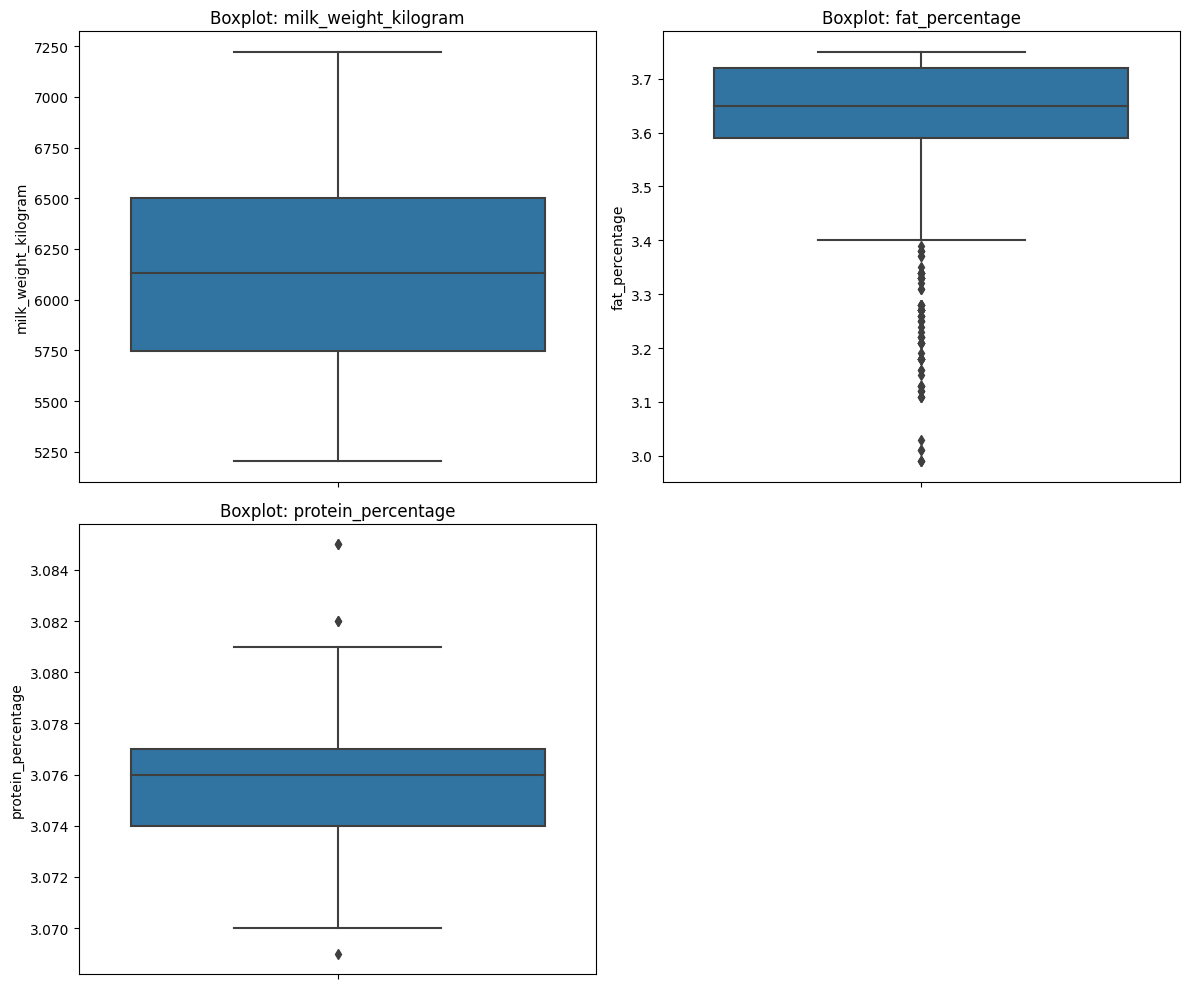

In [24]:
# Создаем визуализатор
viz = Visualizer(ferma.data, translations=dict_column_translations)

# Строим ящик с усами
viz.boxplot(y=['milk_weight_kilogram', 'fat_percentage', 'protein_percentage'])

**Комментарий к графику:**
* По показателю удой выбросы не обнаружены.
* В распределении показателя - жирность молока - есть выбросы ниже 3.4%. Посмотрим, сколько таких значений в датасете.
* В распределении показателя - содержание белка в молоке - есть несколько выбросов выше 3.08% и ниже 3.07%.
* Посмотрим, сколько выбросов в датасете по показателям жирность молока и содержание белка в молоке.

Выявление доли выбросов в датасете по количественным признакам

In [25]:
# Вычислим долю выбросов по столбцу fat_percantage
fat_percentage_anomaly = ferma.data.loc[ferma.data['fat_percentage'] < 3.4, 'fat_percentage'].count() / len(ferma.data)

# Вычислим долю выбросов по столбцу fat_percantage
protein_percentage_anomaly = ferma.data.query('protein_percentage > 3.08 or protein_percentage < 3.07')['protein_percentage'].count() / len(ferma.data)

# Выводим на экран
print(f'Доля выбросов по столбцу fat_percentage = {fat_percentage_anomaly:.2f}, \
по столбцу protein_percentage = {protein_percentage_anomaly:.2f}')

Доля выбросов по столбцу fat_percentage = 0.14, по столбцу protein_percentage = 0.03


По проценту жирности - выбросы составляют 14% датасета, это существенная часть датасета. Далее будем рассматривать эти показатели в разрезе категориальных, чтобы определить, у каких коров появляются самое низкое содержание жиров в молоке.

По содержанию белка - выбросы составляют 3%, эта небольшая часть от всей выборки.

##### Ящик с усами - характеристики молока (Удой, Содержание жиров, Содержание белков) по характеристикам коровы (ВОЗРАСТ)

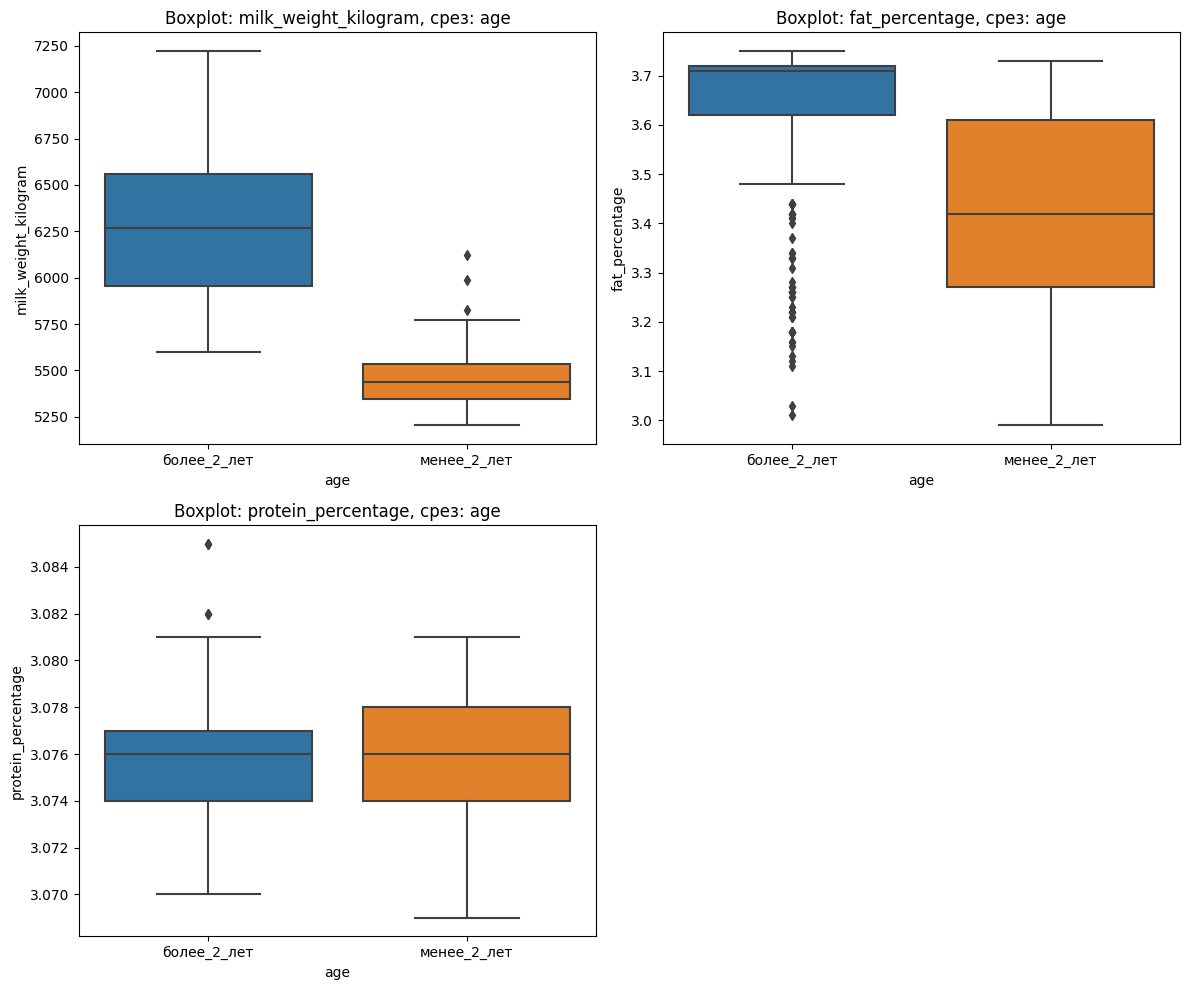

In [26]:
# Создаем визуализатор
viz = Visualizer(ferma.data, translations=dict_column_translations)

# Строим ящик с усами
viz.boxplot(y=['milk_weight_kilogram', 'fat_percentage', 'protein_percentage'], x='age')

**Комментарий к графику**


* На первом графике видно, что удой выше у коров старше 2-х лет. Медиана удоя примерно на 750 кг выше, чем медиана удоя у коров младше 2-х лет.
* Срез по возрасту также помог выявить, что выбросы по содержанию белков и жиров в молоке встречаются только у коров старше 2-х лет.
* Также отметим, что медиана по показателю содержания белка в молоке у коров разного возраста одинакова. Также у коров старше 2-х лет есть выбросы по этому показателю.

##### Гистограмма - показатель Удой в разрезе возраста коровы

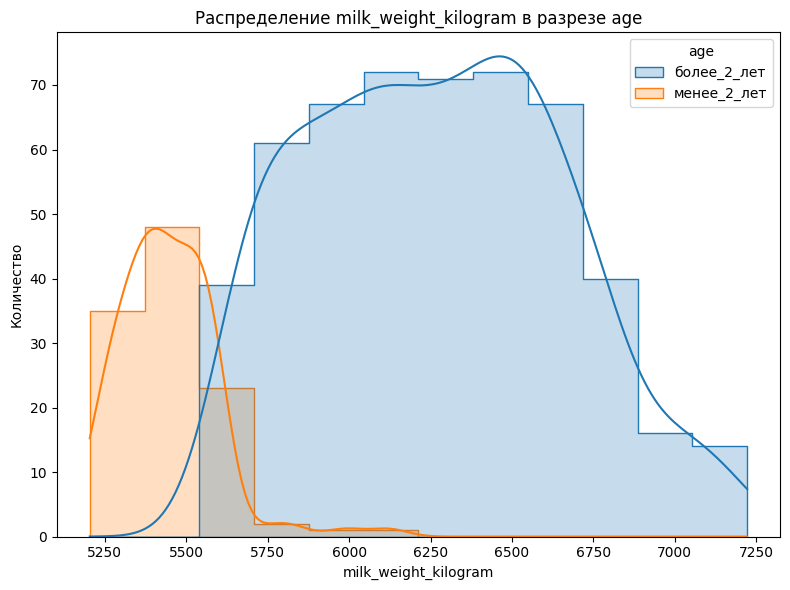

In [27]:
# Строим график
viz.histplot(x='milk_weight_kilogram', hue='age')

**Комментарий к графику**
* На этом графике хорошо видно, что выборка смещена в сторону коров в возрасте более 2-х лет.
* Для пород в возрасте более 2-х лет распределение значений имеет нормальный характер с пиковым количеством в области удоя объемом 6500 кг.
* Для пород в возрасте менее 2-х лет пиковое количество достигается в области удоя объемом 5400 кг.

##### Барплот -  характеристики молока (Содержание жиров, Содержание белков) по характеристикам коровы (ВОЗРАСТ)

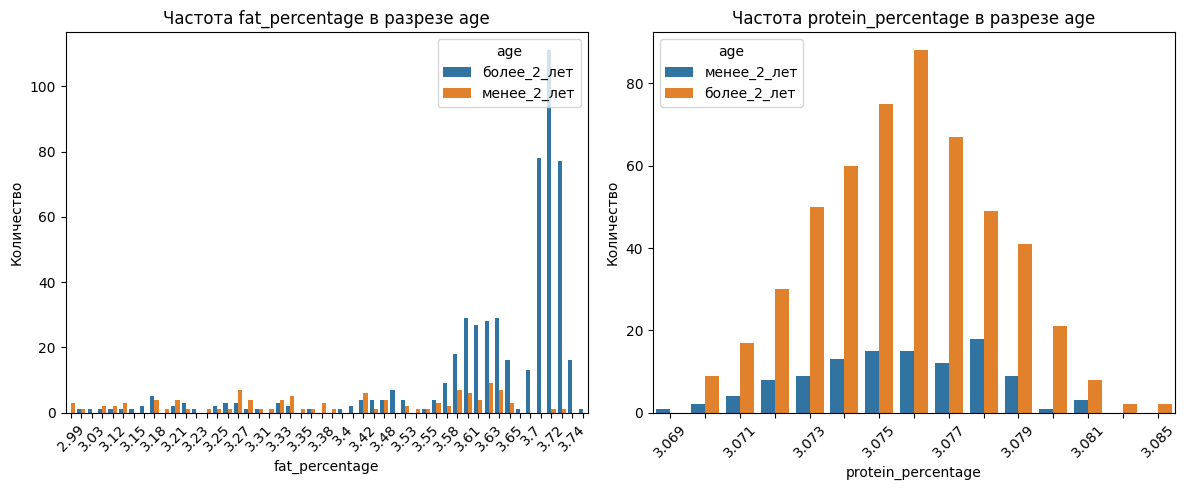

In [28]:
# Строим столбчатую диаграмму
viz.barplot(x=['fat_percentage', 'protein_percentage'], hue='age')

**Комментарий к графику:**
* Пиковые значения жирности приходятся на диапазон 3.72-3.74%.
* Пиковое значение по содержанию белка приходится на 3.076 ед.

##### Ящик с усами - характеристики молока (Удой, Содержание жиров, Содержание белков) по характеристикам коровы (ПОРОДА КОРОВЫ)

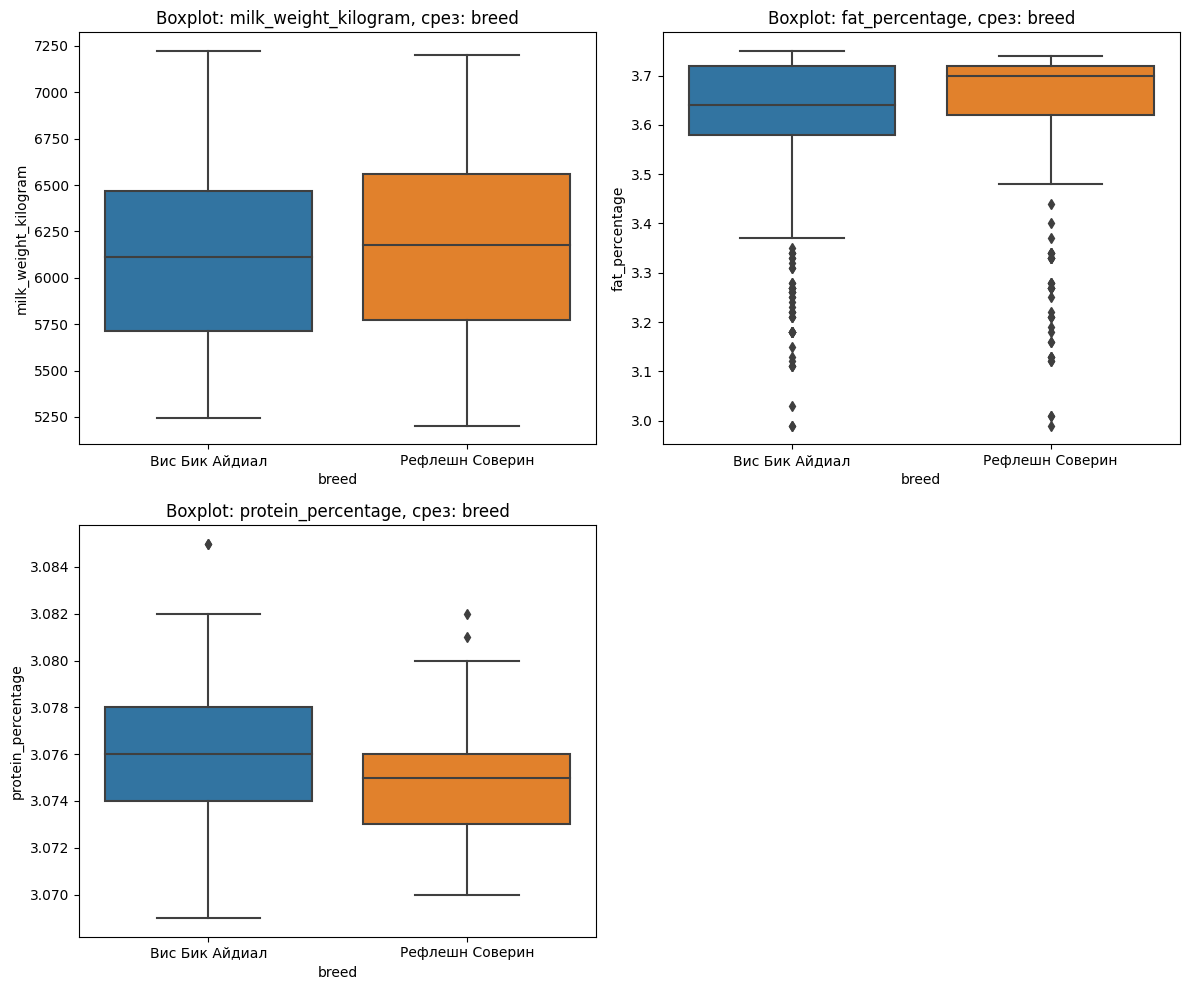

In [29]:
# Создаем визуализатор
viz = Visualizer(ferma.data, translations=dict_column_translations)

# Строим ящик с усами
viz.boxplot(y=['milk_weight_kilogram', 'fat_percentage', 'protein_percentage'], x='breed')

**Комментарий к графику**


* Отсутствие значимых отклонений по удою. Медиана удоя у Соверин немногим выше, чем у породы Айдиал.
* Аномалии по показателю жирности молока у обеих пород, но диапазон жирности шире у породы Айдиал, медиана при этом меньше, чем у Соверин.
* БОльшие значения содержания белка в молоке у породы Айдиал, медиана незначительно больше, чем у Соверин.

##### Гистограмма - показатель Удой, кг в разрезе породы

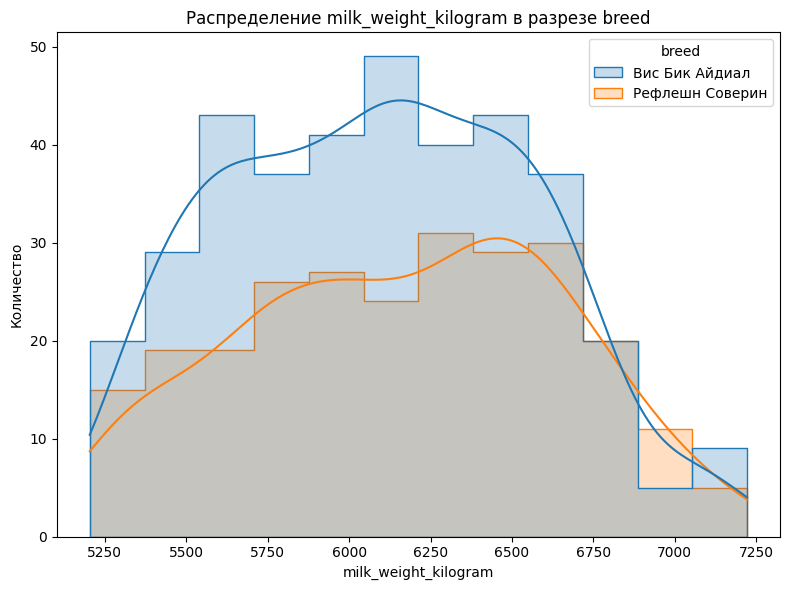

In [30]:
# Строим график
viz.histplot(x='milk_weight_kilogram', hue='breed')

**Комментарий к графику**
* По графику видно, что в выборке бОльшую долю занимают коровы породы Вис Бик Айдиал.
* В целом распределение удоя среди пород имеет схожий характер с тенденцией к снижению после объема удоя 6500 кг.

##### Барплот -  характеристики молока (Содержание жиров, Содержание белков) по характеристикам коровы (ПОРОДА)

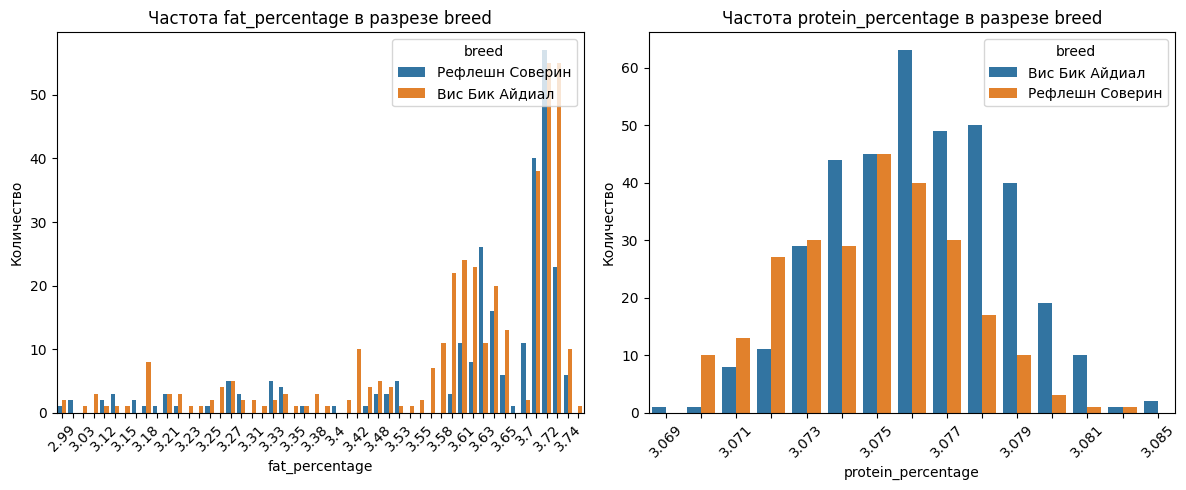

In [31]:
# Строим столбчатую диаграмму
viz.barplot(x=['fat_percentage', 'protein_percentage'], hue='breed')

**Комментарий к графику:**
* Пиковые значения жирности приходятся на диапазон 3.72-3.74%.
* Пиковое значение по содержанию белка приходится на 3.076 ед.

##### Ящик с усами - характеристики молока (Удой, Содержание жиров, Содержание белков) по характеристикам коровы (ПОРОДА ПАПЫ БЫКА)

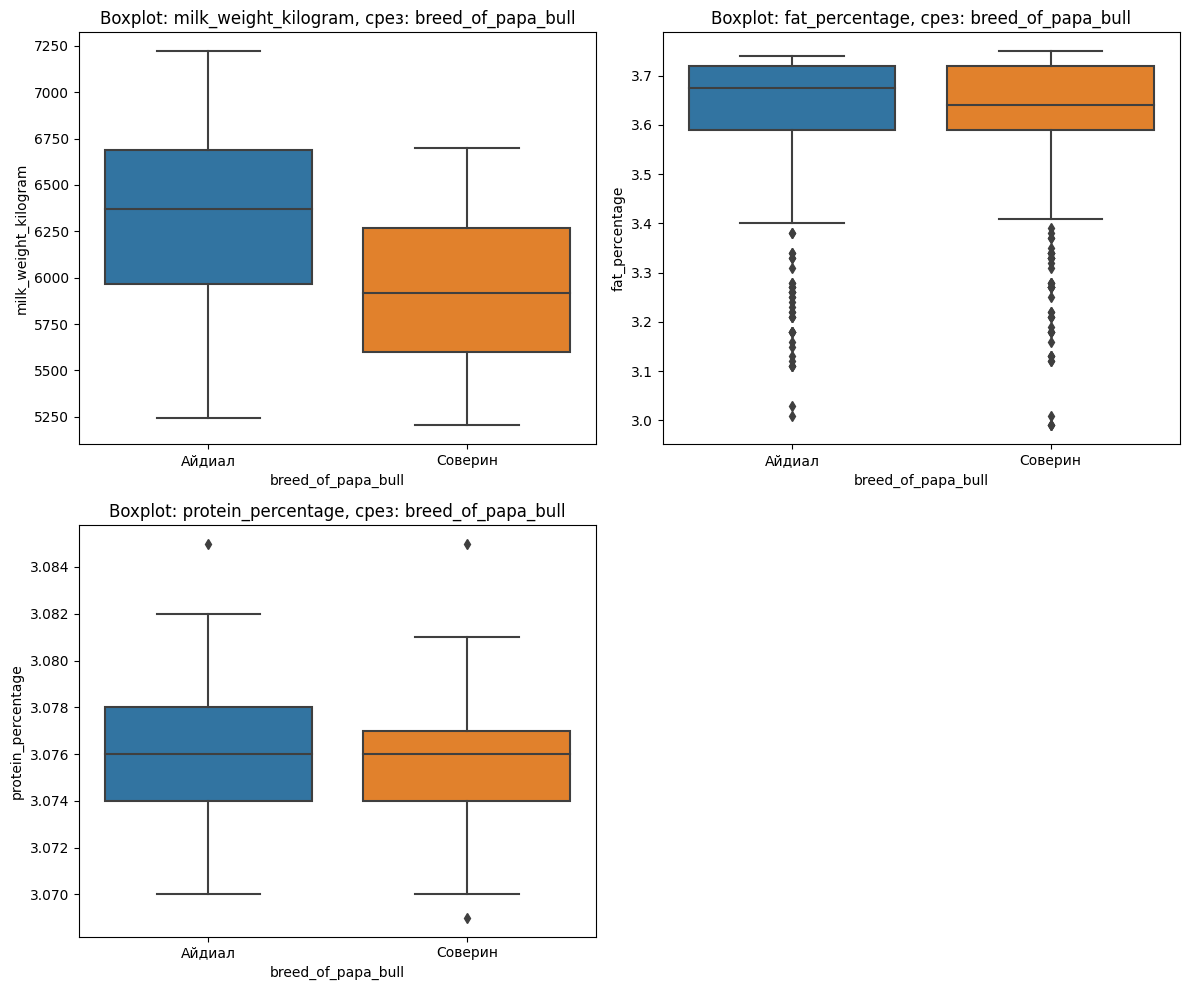

In [32]:
# Создаем визуализатор
viz = Visualizer(ferma.data, translations=dict_column_translations)

# Строим ящик с усами
viz.boxplot(y=['milk_weight_kilogram', 'fat_percentage', 'protein_percentage'], x='breed_of_papa_bull')

**Комментарий к графику**


* На первом графике видно, что удой выше у коров с породой папы Айдиал. Медиана удоя больше, чем у коров с породой папы Соверин примерно на 400 кг.
* Срез по породе папы быка не выявил значимых отличий по диапазону жирности молока - только медиана у коров с породой папы Айдиал выше, выбросы присутствуют в обеих категориях.
* Медиана по содержанию белка в молоке идентична в разрезе данных категорий. Диапазон значений выше у коров с породой папы Айдиал.

##### Гистограмма - показатель Удой, кг в разрезе породы папы коровы

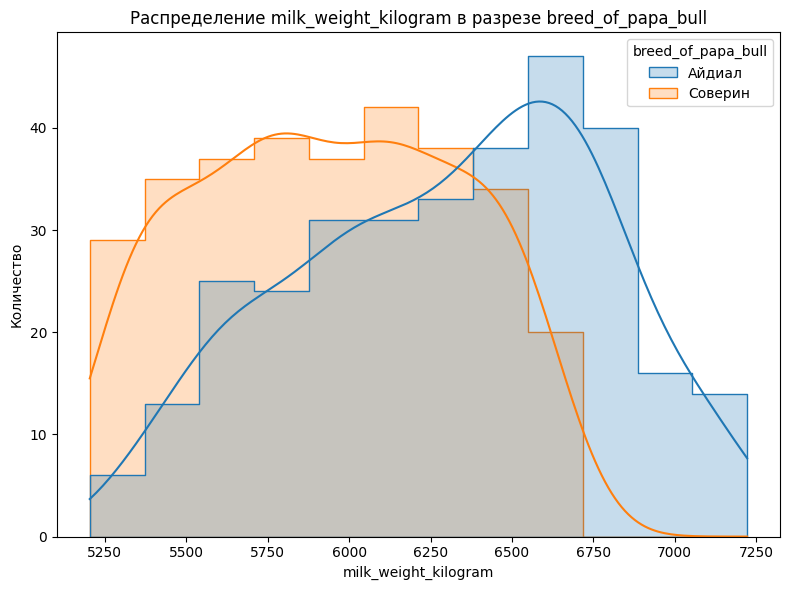

In [33]:
# Строим график
viz.histplot(x='milk_weight_kilogram', hue='breed_of_papa_bull')

**Комментарий к графику**
* Если говорить о количестве коров в разрезе пород папы быка, то выборка достаточно равномерная.
* Распределение коров породы Соверин более пологое, для породы Айдиал - более крутое.
* Это значит, что порода Соверин представлена в целом одинаково коровами с разным уровнем удоя в границах 5300-6500 кг.
* Выборка по породе Айдиал в бОльшей степени представлена породами с высоким уровнем удоя более 6500 кг. 
* Распределение удоя среди пород Соверин имеет тенденцию к снижению после объема удоя 6500 кг.
* Распределение удоя среди пород Айдиал имеет тенденцию к снижению после объема удоя 6650 кг.

##### Барплот -  характеристики молока (Содержание жиров, Содержание белков) по характеристикам коровы (ПОРОДА ПАПЫ БЫКА)

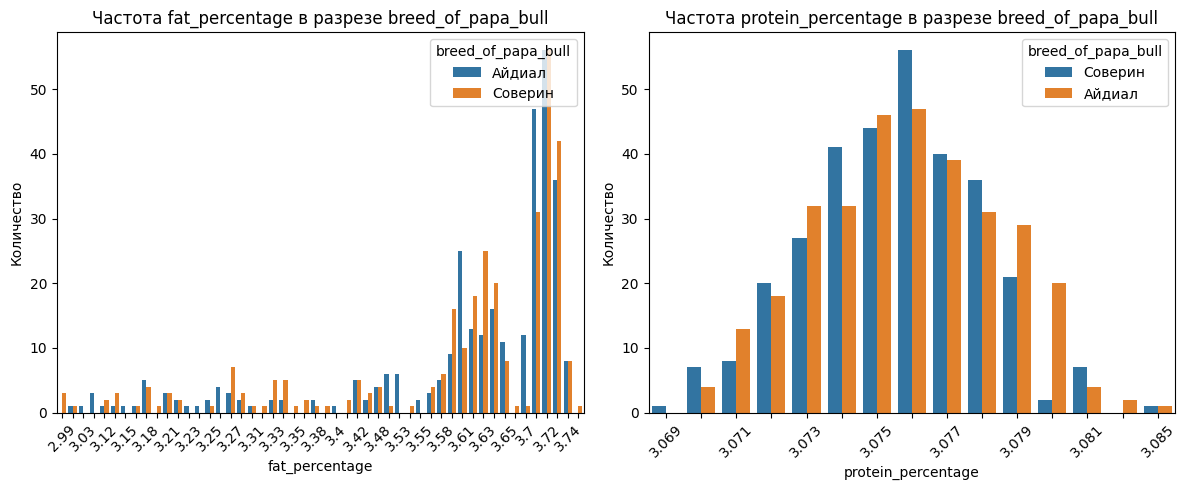

In [34]:
# Строим столбчатую диаграмму
viz.barplot(x=['fat_percentage', 'protein_percentage'], hue='breed_of_papa_bull')

**Комментарий к графику:**
* Пиковые значения жирности приходятся на диапазон 3.72-3.74%.
* Пиковое значение по содержанию белка приходится на 3.076 ед.

##### Ящик с усами - характеристики молока (Удой, Содержание жиров, Содержание белков) по характеристикам пастбища

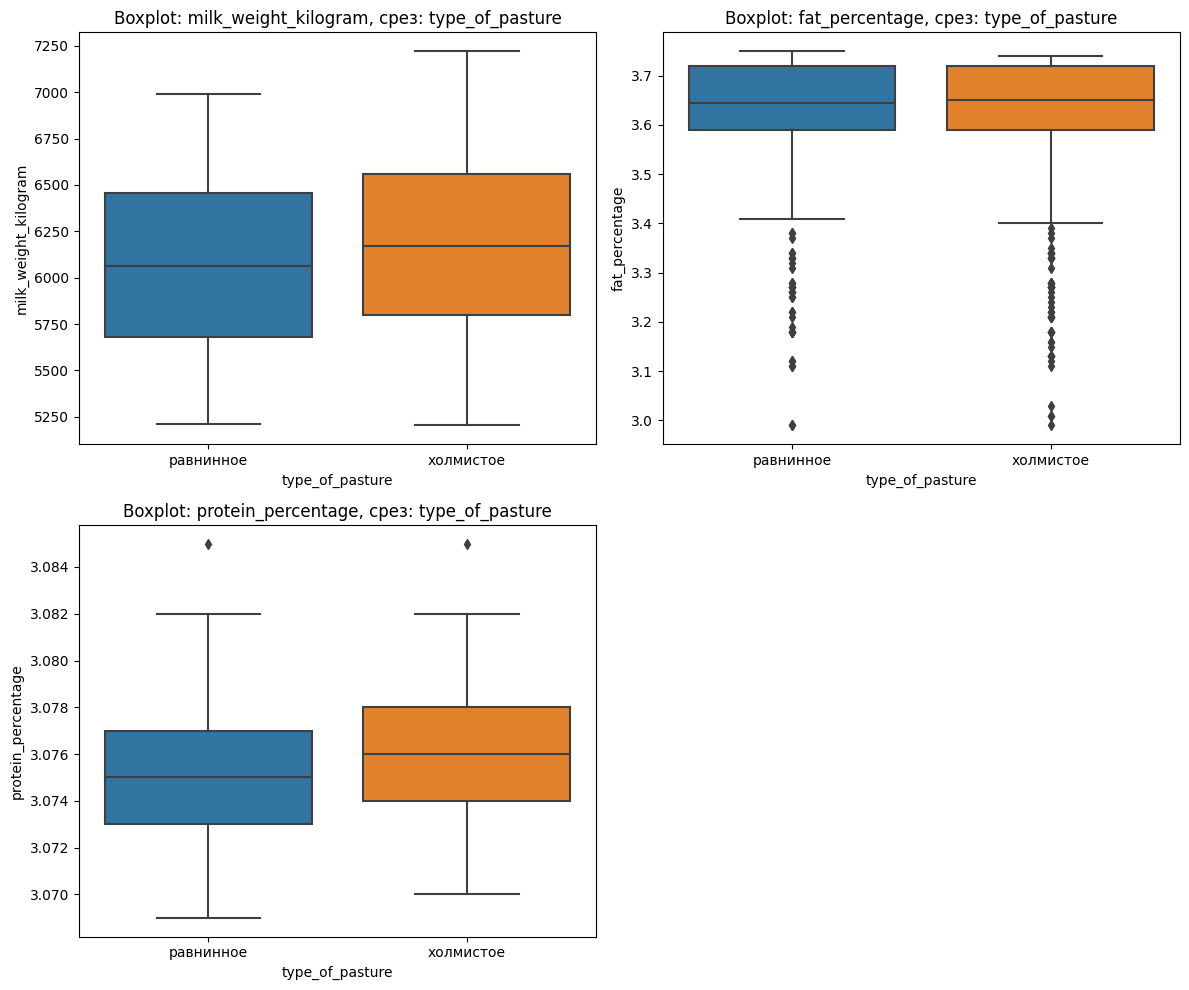

In [35]:
# Создаем визуализатор
viz = Visualizer(ferma.data, translations=dict_column_translations)

# Строим ящик с усами
viz.boxplot(y=['milk_weight_kilogram', 'fat_percentage', 'protein_percentage'], x='type_of_pasture')

**Комментарий к графику**


* На первом графике видно, что удой незначительно выше у коров, которые пасутся на холмистые пастбищах.
* Срез по типу пастбища не выявил значимых отличий по диапазону жирности молока. Аномалии присутствуют в обеих категориях.
* Медиана по содержанию белка в молоке незначительно выше у коров, которые пасутся на холмистые пастбищах.

##### Гистограмма - показатель Удой, кг в разрезе типа пастбища

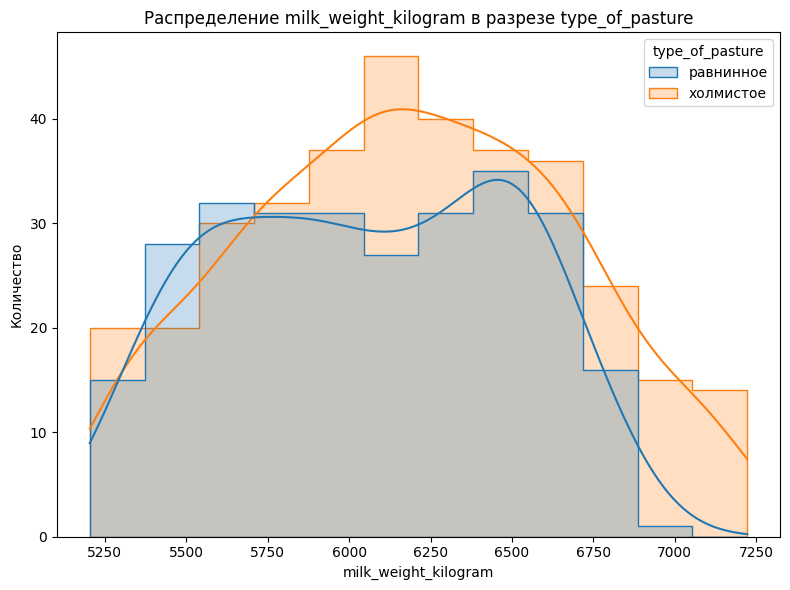

In [36]:
# Строим график
viz.histplot(x='milk_weight_kilogram', hue='type_of_pasture')

**Комментарий к графику**
* Если говорить о количестве коров в разрезе типа пастбища, то в выборке есть перевес в сторону коров, пасущихся на холмистых пастбищах.
* Удой у коров равнинных пастбищ имеет слабо выраженное бимодальное распределение в области 5750 кг и 6500 кг.
* Пиковое значение удоя у коров холмистых пастбищ выше и наступает раньше в области 6100 кг, у равнинных - в области 6500 кг.

##### Барплот -  характеристики молока (Содержание жиров, Содержание белков) по характеристикам пастбища

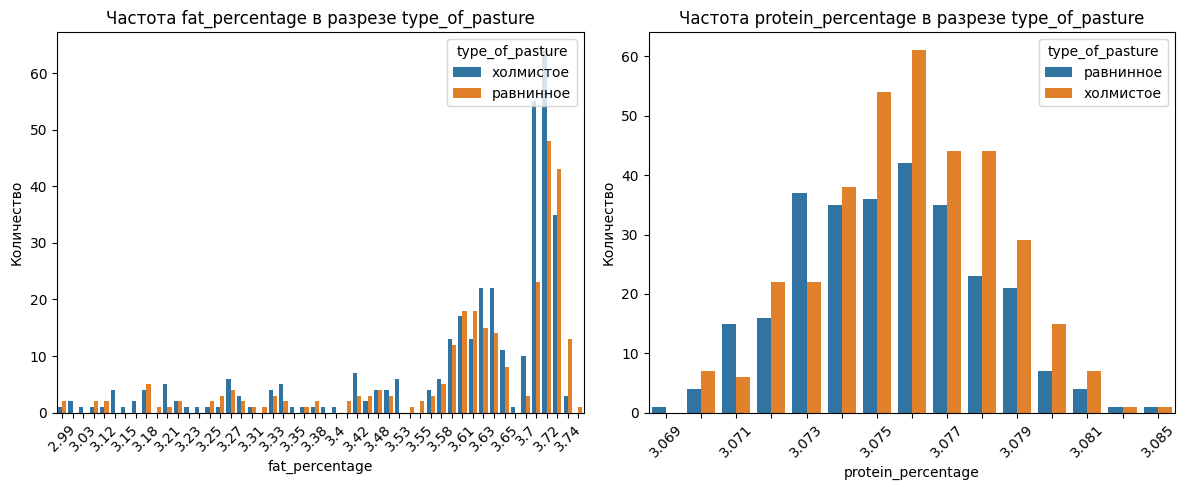

In [37]:
# Строим столбчатую диаграмму
viz.barplot(x=['fat_percentage', 'protein_percentage'], hue='type_of_pasture')

**Комментарий к графику:**
* Пиковые значения жирности приходятся на диапазон 3.72-3.74%.
* Пиковое значение по содержанию белка приходится на 3.076 ед.

#### Построение графиков для количественных признаков - характеристики корма

##### Ящик с усами - характеристики корма (ЭКЕ, сырой протеин, СПО) по характеристикам коровы (ВОЗРАСТ)

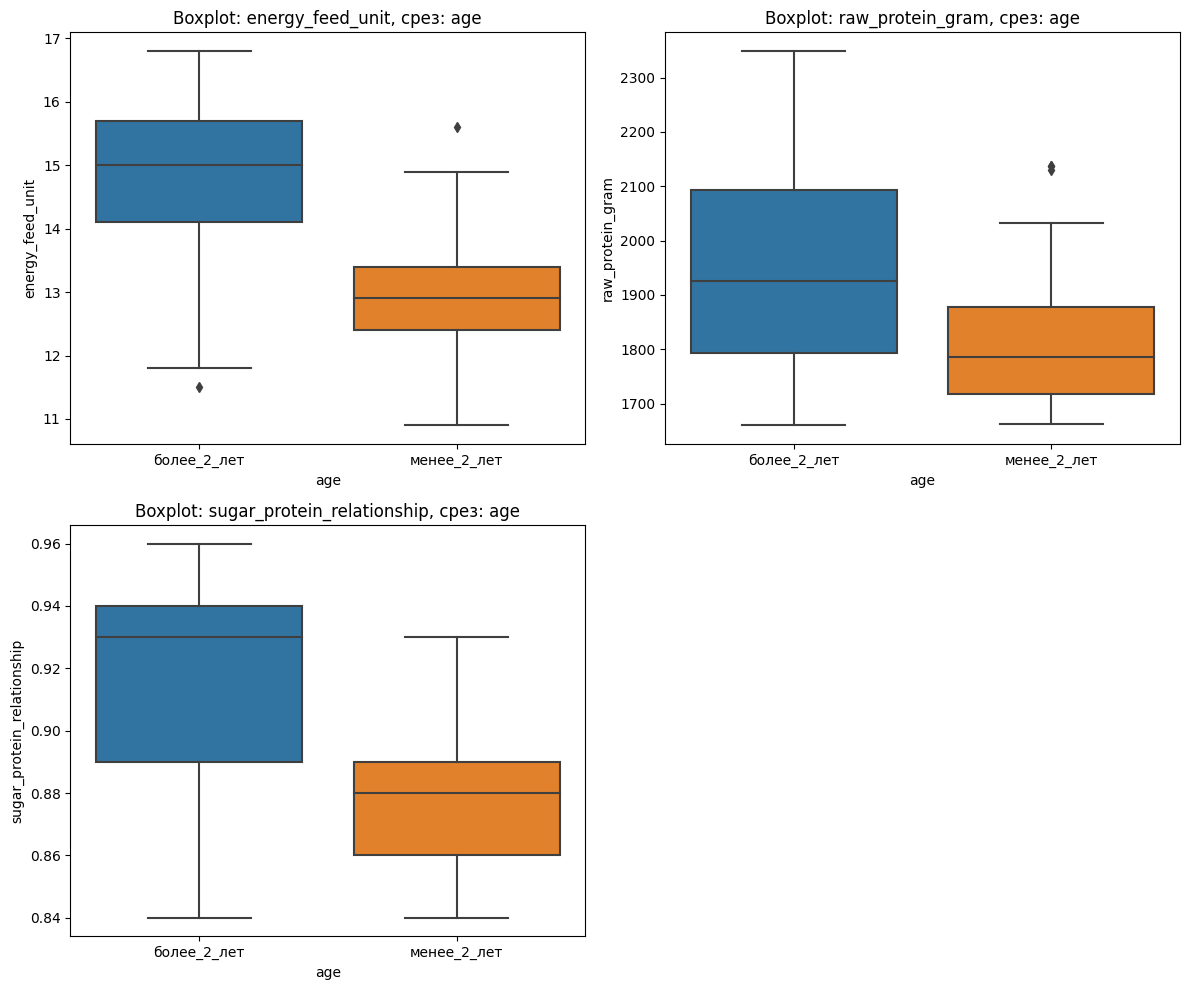

In [38]:
# Создаем визуализатор
viz = Visualizer(ferma.data, translations=dict_column_translations)

# Строим ящик с усами
viz.boxplot(y=['energy_feed_unit', 'raw_protein_gram', 'sugar_protein_relationship'], x='age')

**Комментарий к графику**


* На первом графике видно, что питательность корма выше у коров старше 2-х лет, медиана больше, диапазон значений также больше.
* Аналогичные результаты по сырому протеину и сахарно-протеиновому соотношению.

##### Гистограмма - показатель ЭКЕ и сырого протеина в разрезе возраста коровы

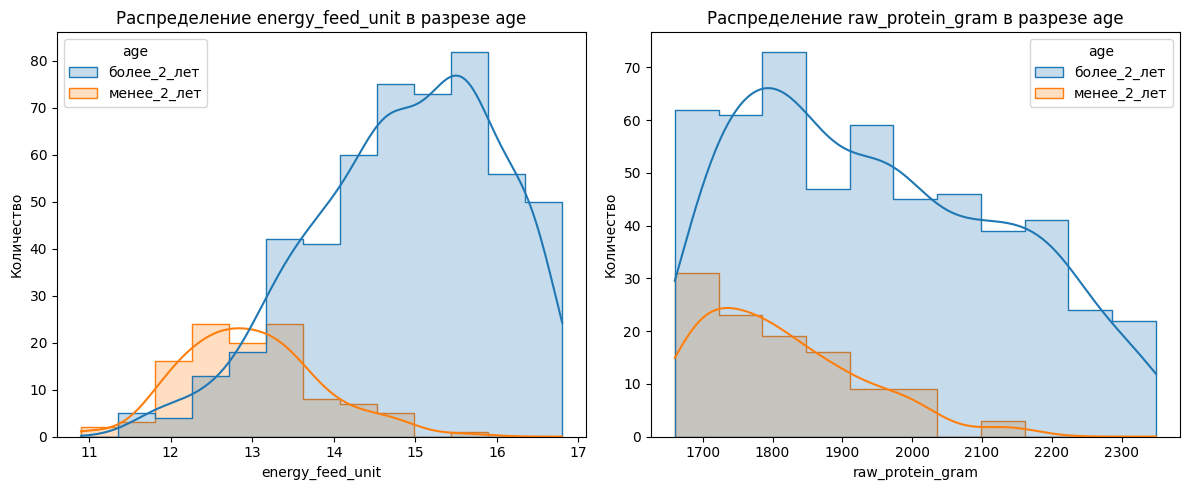

In [39]:
# Строим график
viz.histplot(x=['energy_feed_unit', 'raw_protein_gram'], hue='age')

**Комментарий к графику**
* На этом графике хорошо видно, что выборка смещена в сторону коров в возрасте более 2-х лет.
* Для пород в возрасте младше 2-х лет распределение значений имеет нормальный характер с пиковым количеством в области 13 ЭКЕ.
* Для пород в возрасте старше 2-х лет пиковое количество достигается в области 15.5 ЭКЕ.

* Распределение сырого протеина имеет нисходящий вид с пиком для коров старше 2-х лет в области 1800 г, для коров младше 2-х лет в области 1750 г.

##### Барплот -  показатель СПО по характеристикам коровы (ВОЗРАСТ)

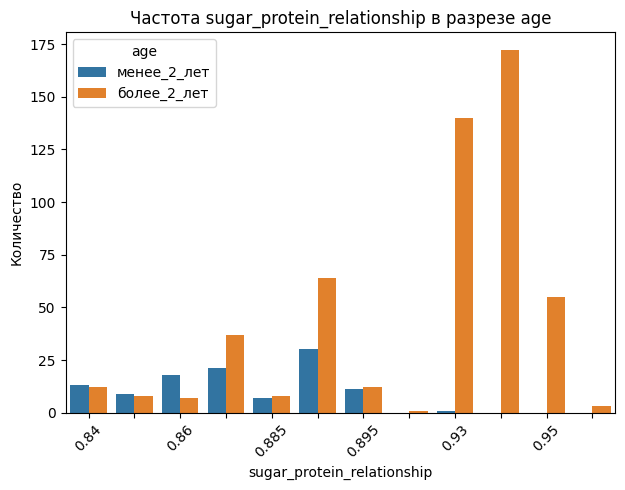

In [40]:
# Строим столбчатую диаграмму
viz.barplot(x=['sugar_protein_relationship'], hue='age')

**Комментарий к графику:**
* По СПО корма можно сказать, что значения визуально разделились на 2 категории:
    * меньше 0.9
    * больше 0.9 (пик в области 0.94)

##### Ящик с усами - характеристики корма (ЭКЕ, сырой протеин, СПО) по характеристикам коровы (ПОРОДА КОРОВЫ)

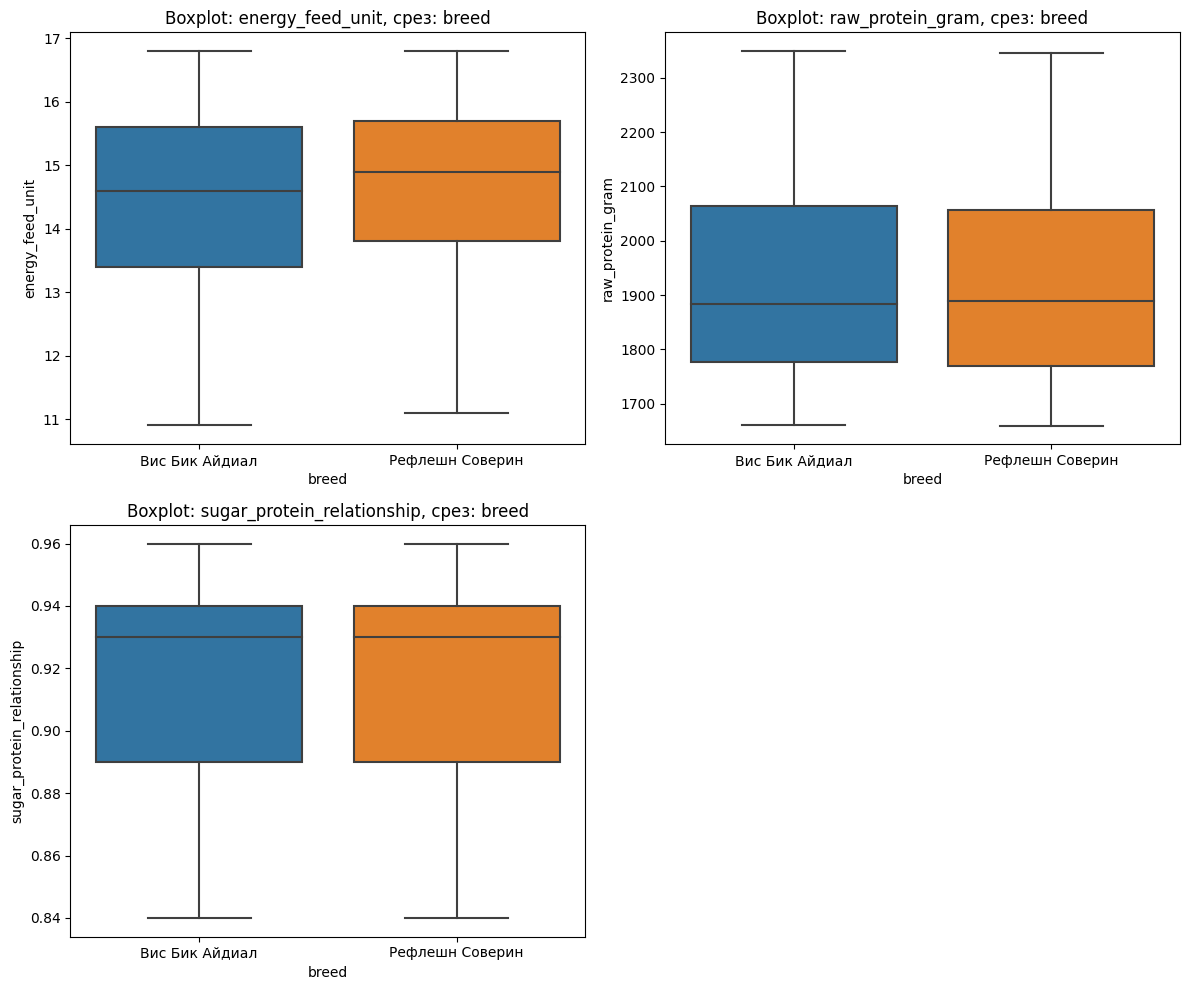

In [41]:
# Создаем визуализатор
viz = Visualizer(ferma.data, translations=dict_column_translations)

# Строим ящик с усами
viz.boxplot(y=['energy_feed_unit', 'raw_protein_gram', 'sugar_protein_relationship'], x='breed')

**Комментарий к графику**


* Отсутствие значимых отклонений по ЭКЕ, сырому протеину и СПО для разных пород коровы.

##### Гистограмма - показатель ЭКЕ и сырого протеина в разрезе породы коровы

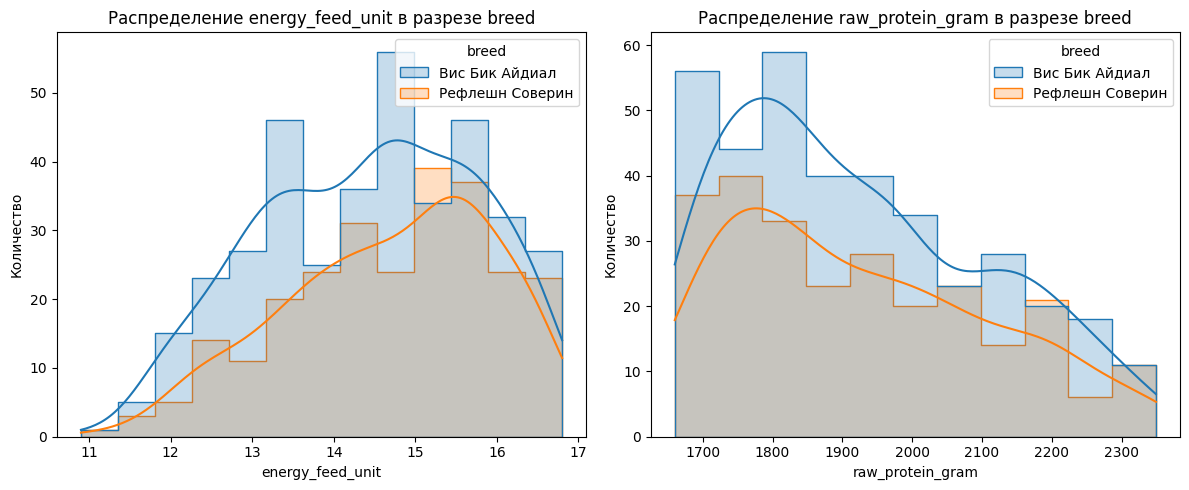

In [42]:
# Строим график
viz.histplot(x=['energy_feed_unit', 'raw_protein_gram'], hue='breed')

**Комментарий к графику**
* Распределение показателя ЭКЕ имеет восходящий вид с пиком в области 14.9-15.5 ед. для обеих категорий.
* Распределение показателя сырого протеина имеет нисходящий вид с пиком в области 1800 г для обеих категорий.

##### Барплот -  показатель СПО по характеристикам коровы (ПОРОДА)

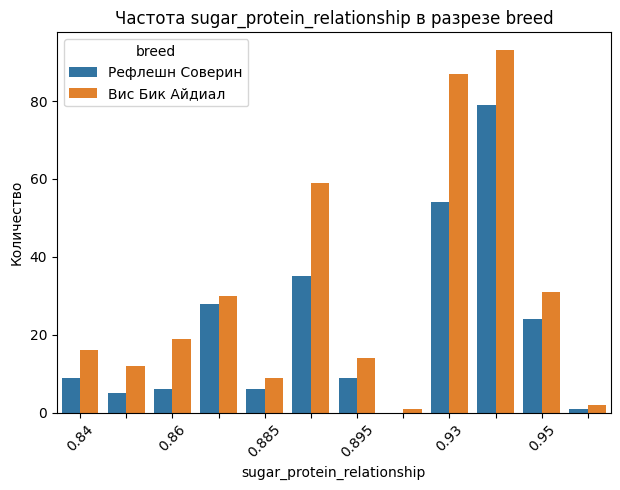

In [43]:
# Строим столбчатую диаграмму
viz.barplot(x=['sugar_protein_relationship'], hue='breed')

**Комментарий к графику:**
* По СПО корма можно сказать, что значения визуально разделились на 2 категории:
    * меньше 0.89
    * больше 0.89 (пик в области 0.94)

##### Ящик с усами - характеристики корма (ЭКЕ, сырой протеин, СПО) по характеристикам коровы (ПОРОДА ПАПЫ БЫКА)

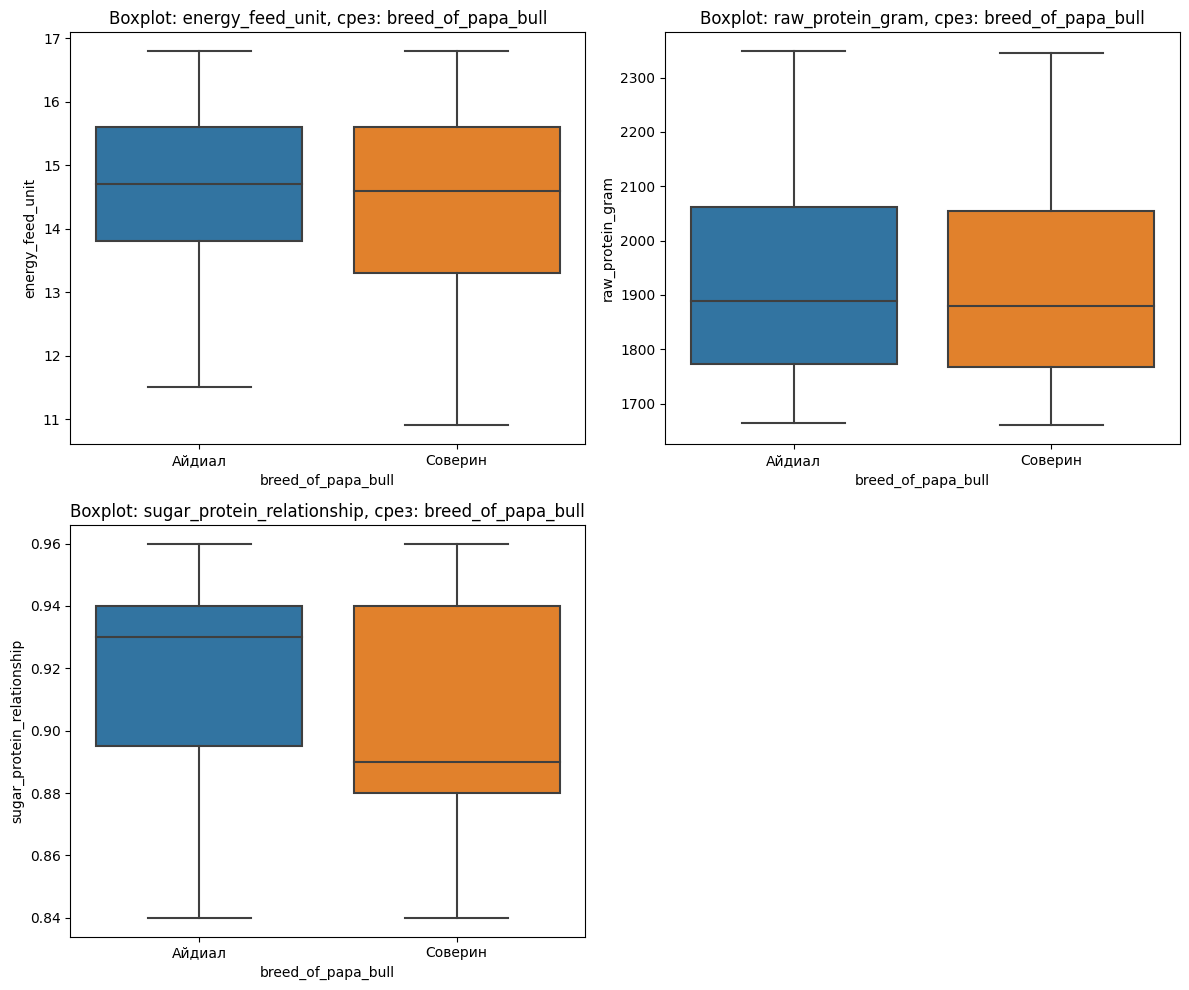

In [44]:
# Создаем визуализатор
viz = Visualizer(ferma.data, translations=dict_column_translations)

# Строим ящик с усами
viz.boxplot(y=['energy_feed_unit', 'raw_protein_gram', 'sugar_protein_relationship'], x='breed_of_papa_bull')

**Комментарий к графику**


* На третьем графике видно, что медиана СПО для коров с породой папы Айдиал уровень СПО выше, чем у других коров.

##### Гистограмма - показатель ЭКЕ и сырого протеина в разрезе породы папы быка

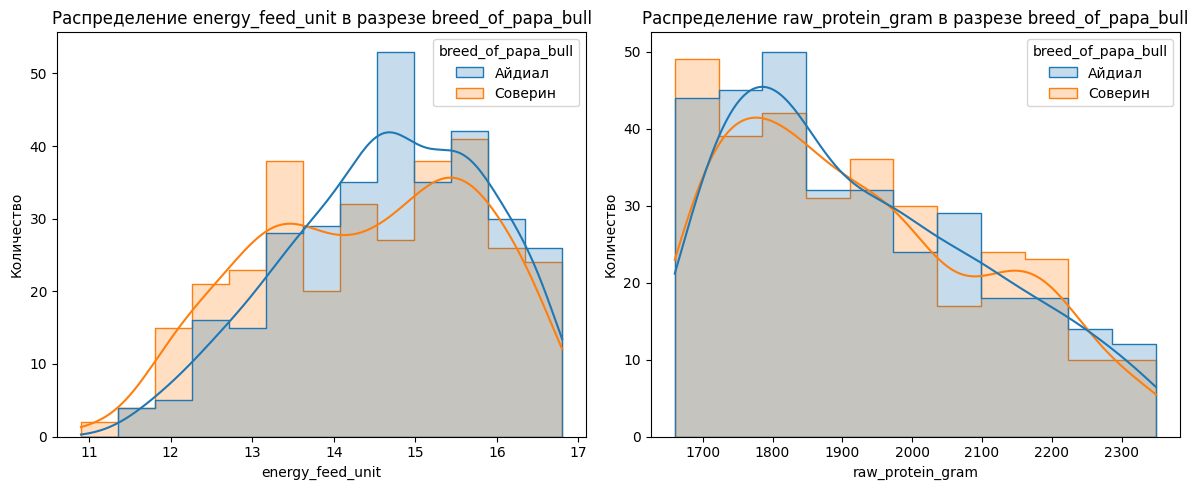

In [45]:
# Строим график
viz.histplot(x=['energy_feed_unit', 'raw_protein_gram'], hue='breed_of_papa_bull')

**Комментарий к графику**
* Распределение показателя ЭКЕ имеет восходящий вид с пиком в области 14.9-15.5 ед. для обеих категорий.
* Распределение сырого протеина имеет нисходящий вид с пиком для коров обеих категорий в области 1800 г.

##### Барплот -  показатель СПО по характеристикам коровы (ПОРОДА ПАПЫ БЫКА)

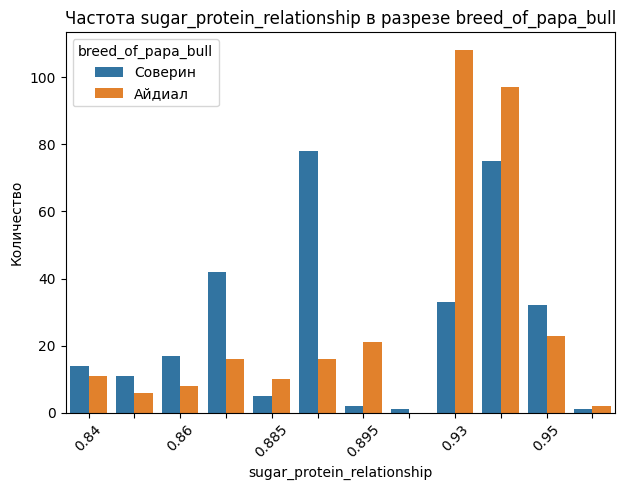

In [46]:
# Строим столбчатую диаграмму
viz.barplot(x=['sugar_protein_relationship'], hue='breed_of_papa_bull')

**Комментарий к графику:**
* По СПО корма можно сказать, что значения визуально разделились на 2 категории:
    * меньше 0.89
    * больше 0.89 (пик в области 0.93-0.94)

##### Ящик с усами - характеристики корма (ЭКЕ, сырой протеин, СПО) по характеристикам пастбища

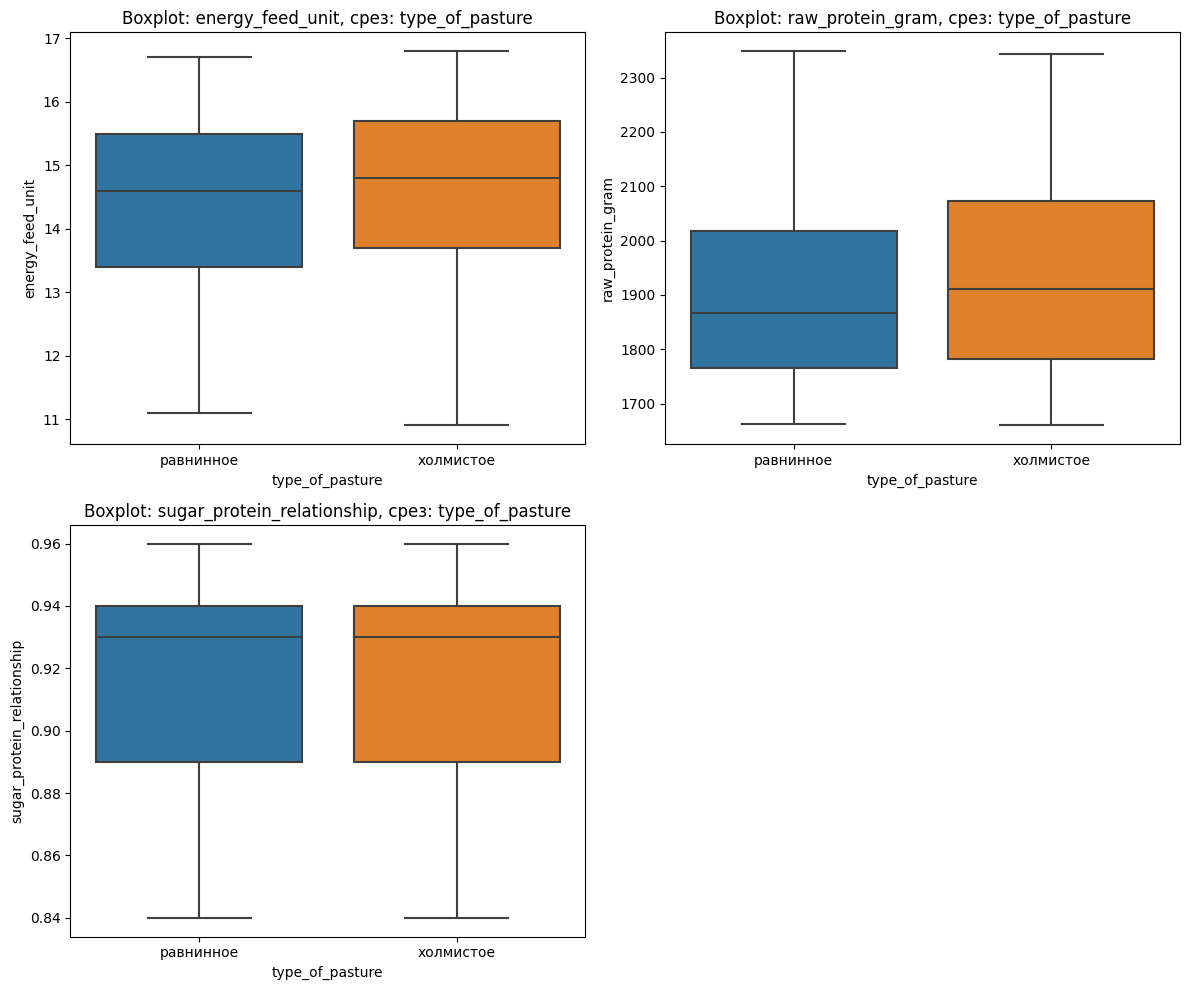

In [47]:
# Создаем визуализатор
viz = Visualizer(ferma.data, translations=dict_column_translations)

# Строим ящик с усами
viz.boxplot(y=['energy_feed_unit', 'raw_protein_gram', 'sugar_protein_relationship'], x='type_of_pasture')

**Комментарий к графику**


* Значимых отклонений на графиках не выявлено.

##### Гистограмма - показатель ЭКЕ и сырого протеина в разрезе типа пастбища

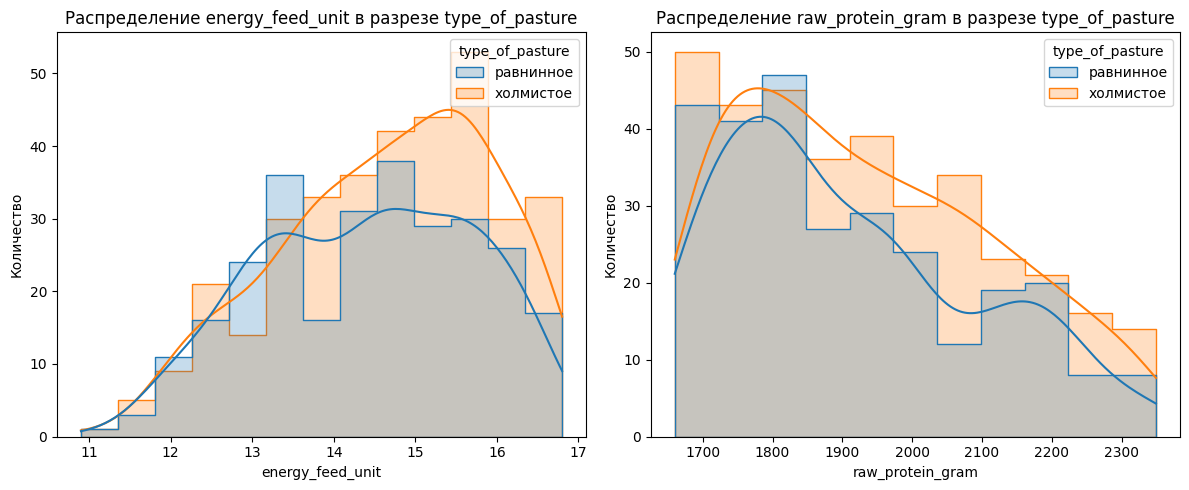

In [48]:
# Строим график
viz.histplot(x=['energy_feed_unit', 'raw_protein_gram'], hue='type_of_pasture')

**Комментарий к графику**
* Распределение показателя ЭКЕ по коровам холмистых пастбищ имеет восходящий вид с пиком в области 15.5 ед., по коровам равнинных пастбищ - распределение более равномерное с пиком в области 15 ед.
* Распределение сырого протеина имеет нисходящий вид с пиком для коров обеих категорий в области 1800 г.

##### Барплот -  показатель СПО по характеристикам пастбища

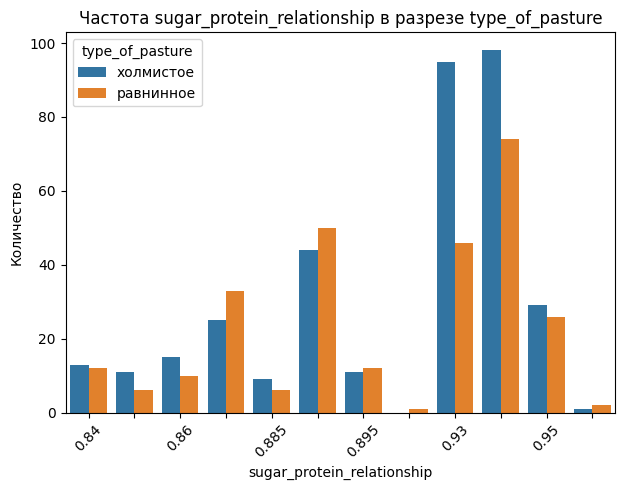

In [49]:
# Строим столбчатую диаграмму
viz.barplot(x=['sugar_protein_relationship'], hue='type_of_pasture')

**Комментарий к графику:**
* По СПО корма можно сказать, что значения визуально разделились на 3 категории:
    * меньше 0.89
    * 0.89 - 0.91
    * больше 0.91 (пик в области 0.93-0.94)

#### Построение графиков для категориальных признаков

##### Столбчатая диаграмма - показатель Вкус молока в разрезе породы

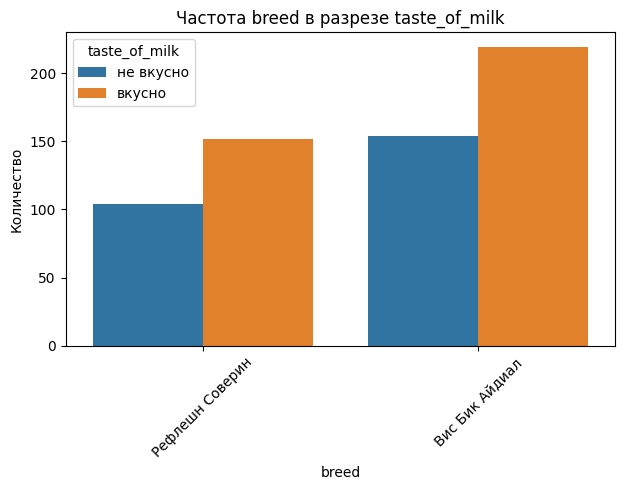

In [50]:
# Строим столбчатую диаграмму
viz.barplot(x='breed', hue='taste_of_milk')

**Комментарий к графику**
* На этом графике хорошо видно, что невкусное молоко у коровы породы Вис Бик Айдиал представлено примерно в том же объеме, что и вкусное молоко коровы породы Рефлешн Соверин
* А вкусного молока коровы породы Вис Бик Айдиал заметно больше, чем вкусного молока коровы породы Рефлешн Соверин
* В целом характерно то, что для разных пород соотношение вкусного и невкусного молока примерно сопоставимо.

##### Столбчатая диаграмма - показатель Вкус молока в разрезе породы папы коровы

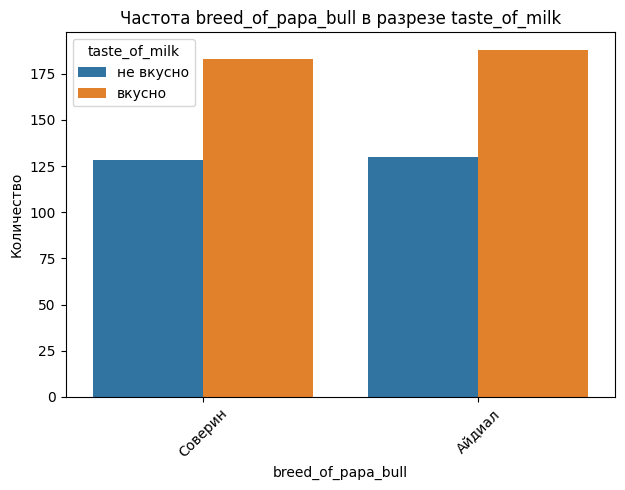

In [51]:
# Строим столбчатую диаграмму
viz.barplot(x='breed_of_papa_bull', hue='taste_of_milk')

**Комментарий к графику**
* В целом характерно то, что для разных пород соотношение вкусного и невкусного молока примерно сопоставимо.

##### Столбчатая диаграмма - показатель Вкус молока в разрезе возраста коровы

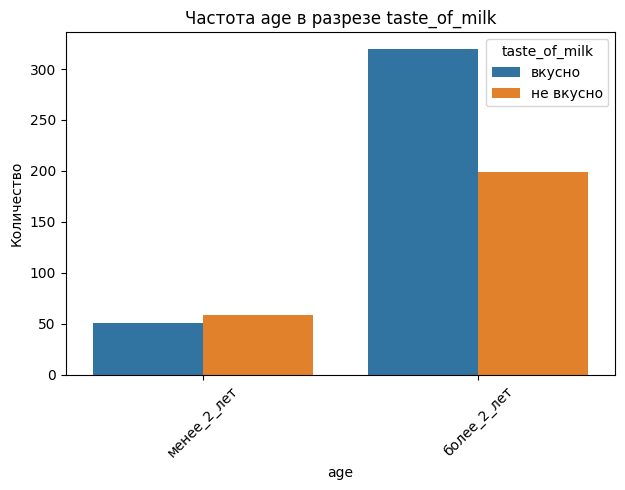

In [52]:
# Строим столбчатую диаграмму
viz.barplot(x='age', hue='taste_of_milk')

**Комментарий к графику**
* На этом графике хорошо видно, что соотношение вкусного / не вкусного молока в целом сопоставима у коров младше 2-х лет
* Для коров старше 2-х лет вкусного молоко больше, чем невкусного примерно на 30%.

### Промежуточные выводы

В рамках статистического анализа данных:
* Выведена описательная статистика количественных признаков, которая показала **аномальное значение по удою по одной строке**. Данная аномалия была преобразована.


* Построены гистограммы и "ящик с усами" для количественных признаков - характеристик **молока** (Удой, Содержание жиров, Содержание белков).
По результатам анализа графиков выявлены:
	* **Неравномерное распределение выборки между коровами**:
		* **разных возрастов** - коров старше 2-х лет значительно больше, чем коров младше 2-х лет.
		* **разных пород** - коров Вис Дик Айдиал больше, чем коров Рифлешн Соверин.
	* **Лидирующие показатели Удоя у коров старше 2-х лет (медианное значение выше примерно на 750 кг), породы Вис Дик Айдиал и породы папы быка Айдиал.**
	* **Наличие выбросов в показателе - Жирность молока. Они характерны для коров старше 2-х лет.** Аномалии составили 14% от всего объема датасета.
	* **Дискретный характер распределения показателей Жирность молока и Содержание белков в молоке**.
        * Пиковые значения жирности приходятся на диапазон 3.72-3.74%.
        * Пиковое значение по содержанию белка приходится на 3.076 ед.

---
* Построены гистограммы и "ящик с усами" для количественных признаков - характеристик **корма** (ЭКЕ, Сырой протеин, Сахарно-протеиновое соотношение).
По результатам анализа графиков выявлены:
	* **Медианные значения больше и диапазон принимаемых значений шире по всем характеристикам корма у коров старше 2-х лет.**
	* Наоборот, **для коров разных пород практически идентичные значения по характеристикам корма.**
	* То есть, похоже на то, что **разный состав корма зависит от возраста, а не от породы коровы или породы папы быка.**
	* Пиковые значения ЭКЕ в районе 15-16 ед., сырого протеина - в районе 1800 грамм.
	* **Дискретный характер распределения показателя Сахарно-протеиновое соотношение.**
		* Значения по СПО корма можно разделить на 3 категории: до 0.87, до 0.91, более 0.91.
	* Значениям по СПО можно присвоить категории и использовать для улучшения обучающей способности моделей.

---
* Построены барплоты для категориальных признаков, при анализе которых выявлено:
	* **Соотношение вкусного молока и невкусного между разными породами коров примерно одинаково.**
	* **Соотношение вкусного молока и невкусного между разными возрастами отличается:**
		* для коров младше 2-х лет держится паритет
		* для коров старше 2-х лет - вкусного молока больше примерно на 30%.

## Корреляционный анализ

### Тепловая карта корреляции количественных признаков

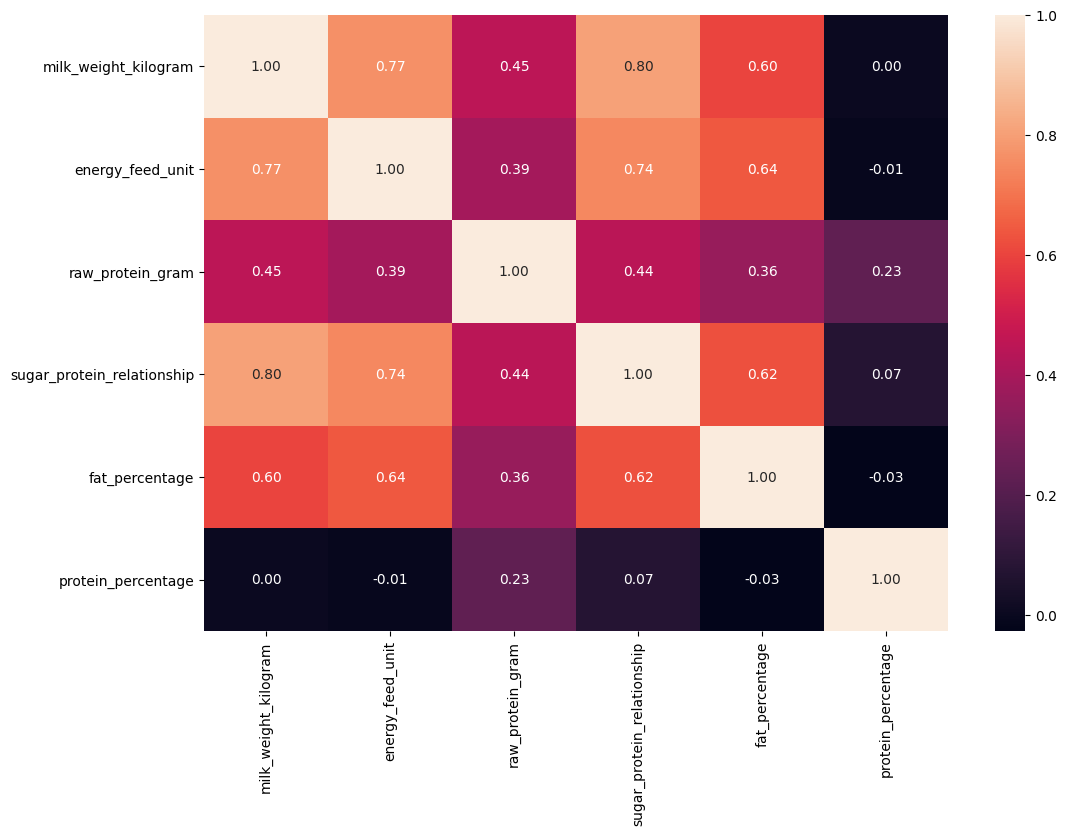

In [53]:
# Строим график с количественными признаками кроме столбца с id
sns.heatmap(ferma.data.loc[:, ['milk_weight_kilogram', 'energy_feed_unit', 'raw_protein_gram',	'sugar_protein_relationship', 'fat_percentage',	'protein_percentage']].corr(), annot=True, fmt='.2f')

# Выводим график
plt.show()

**Комментарий к графику**
* Целевой показатель удоя имеет положительную прямую корреляцию со всеми **характеристиками корма**:
    * высокую корреляцию с показателем энергетической кормовой единицы
    * высокую корреляцию с соотношением сахара и протеина
    * умеренную корреляцию с содержанием сырого протеина
* Если говорить о **характеристиках молока**, то:
    * Удой также имеет заметную прямую положительную корреляцию с содержанием жира в молоке.
    * Но содержание белка в молоке не влияет на объём удоя.
    
Посмотрим, подтвердятся ли наши предположения на диаграммах рассеивания.

### Построение диаграмм рассеивания для признака Удой, кг

#### Диаграмма рассеивания для признака Удой, кг в разрезе породы

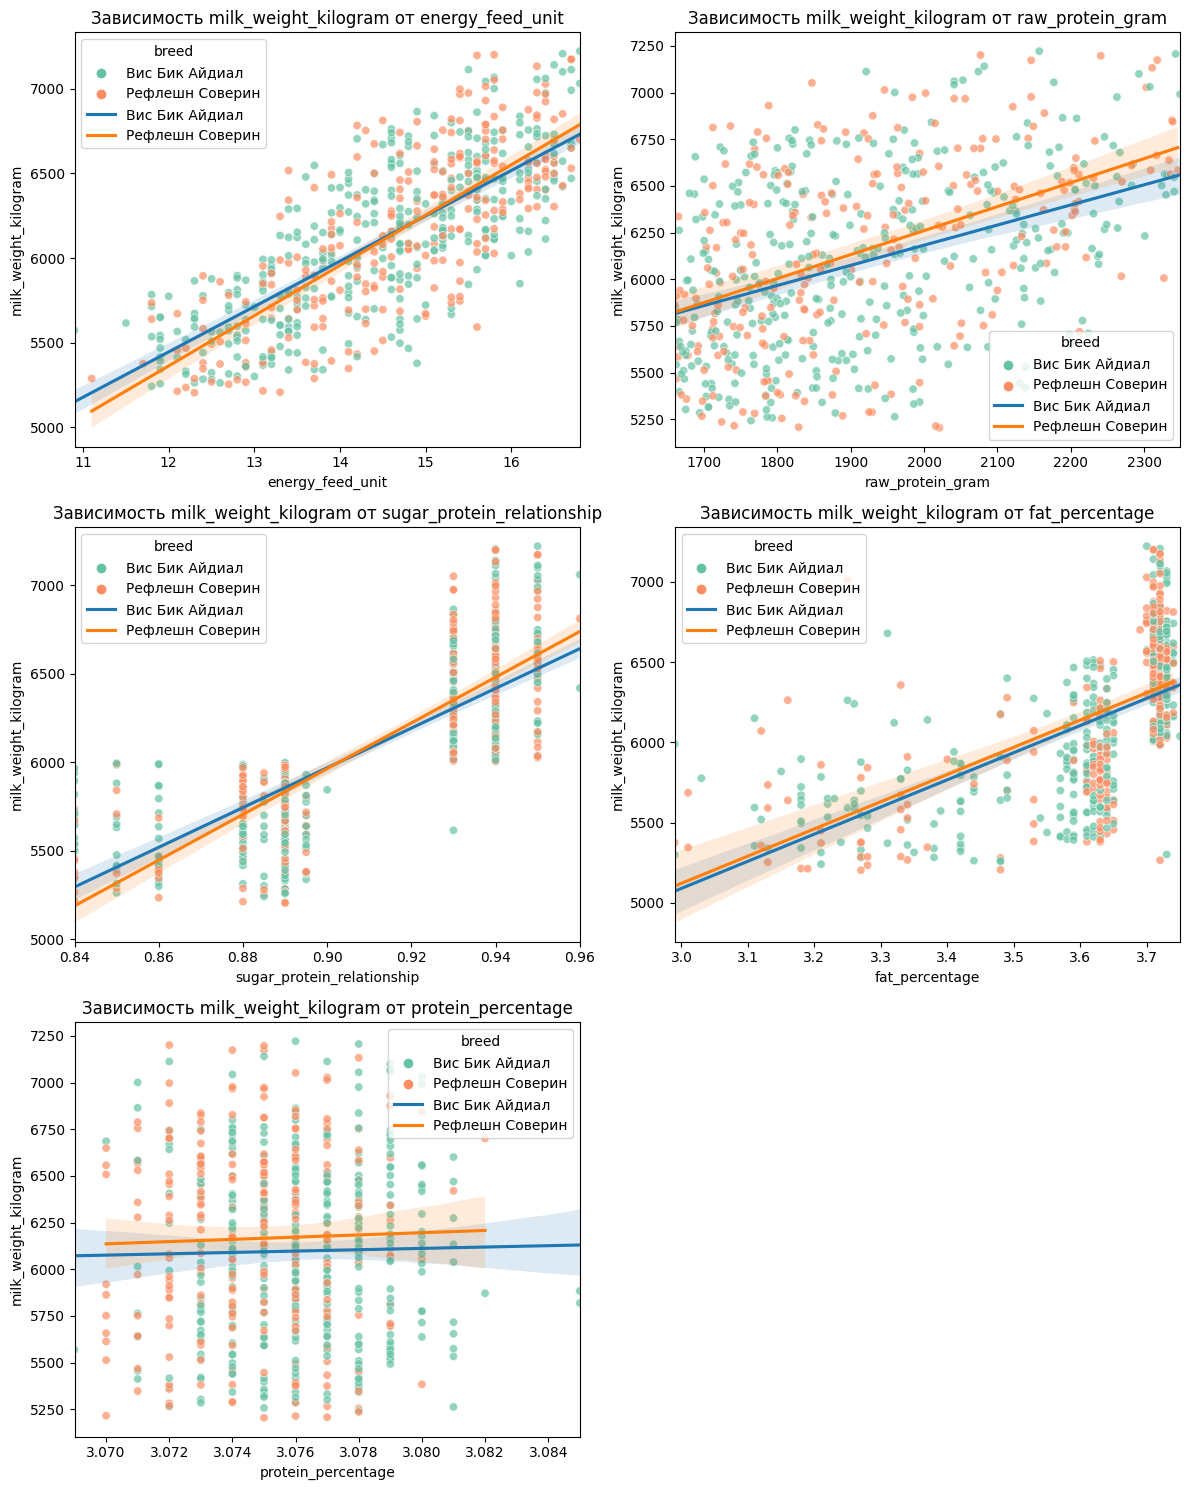

In [54]:
# Строим диаграмму рассеяния для разных пород коровы
viz.scatterplot(x=['energy_feed_unit', 'raw_protein_gram', 'sugar_protein_relationship', 'fat_percentage', \
                   'protein_percentage'], y='milk_weight_kilogram', hue='breed')

**Комментарий к графикам:**

* Подтвердились следующие гипотезы:
    * высокая корреляция объёма удоя с показателем энергетической кормовой единицы в корме
    * умеренная корреляция объёма с содержанием сырого протеина в корме
    
    
* На графиках также видно, что у разных пород коров различается корреляция между удоем и сырым протеином в корме (у породы Соверин корреляция выраженнее, чем у Айдиал)


* Остальные признаки расположены с явно выраженными паттернами, что может быть связано с дискретной природой показетелей:
    * сахарно-проетиновое соотношение
    * содержание жиров в молоке
    * содержание белков в молоке
    
Для этих признаков далее не будем строить диаграммы рассеивания.

#### Диаграмма рассеивания для признака Удой, кг в разрезе породы папы коровы

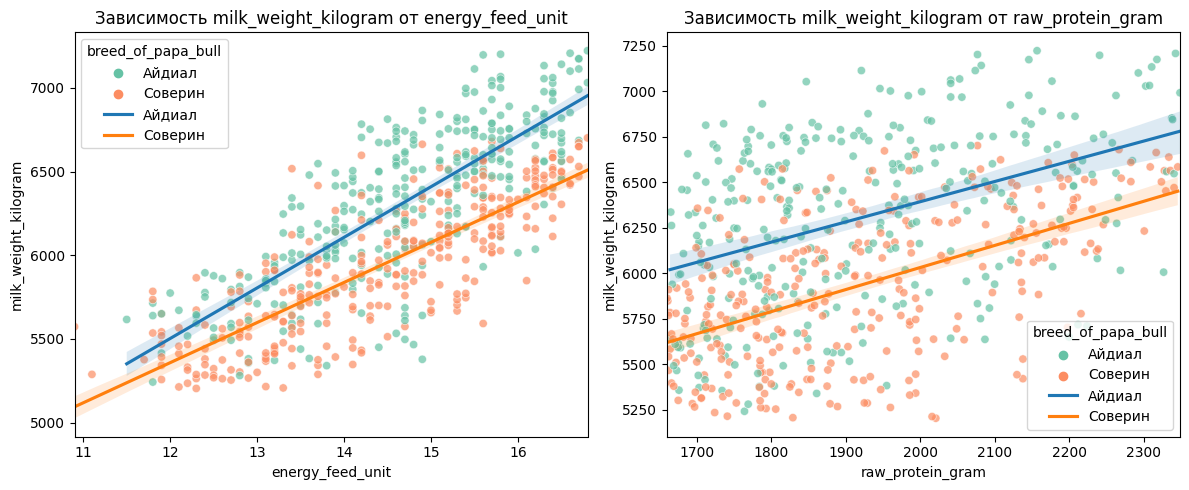

In [55]:
# Строим диаграмму рассеяния для разных имен папы коровы
viz.scatterplot(x=['energy_feed_unit', 'raw_protein_gram'], y='milk_weight_kilogram', hue='breed_of_papa_bull')

**Комментарий к графикам:**

* корреляция энергетической кормовой единицы в корме и удоя сильнее у коров с именем папы Айдиал, чем у коров с именем папы Соверин, такие же результаты у сахарно-протеинового соотношения в корме, содержания жиров в молоке


* если говорить о корреляции сырого протеина в молоке и удоя, то здесь корреляция у коров с разными именами пап сопоставима

#### Диаграмма рассеивания для признака Удой, кг в разрезе возраста коровы

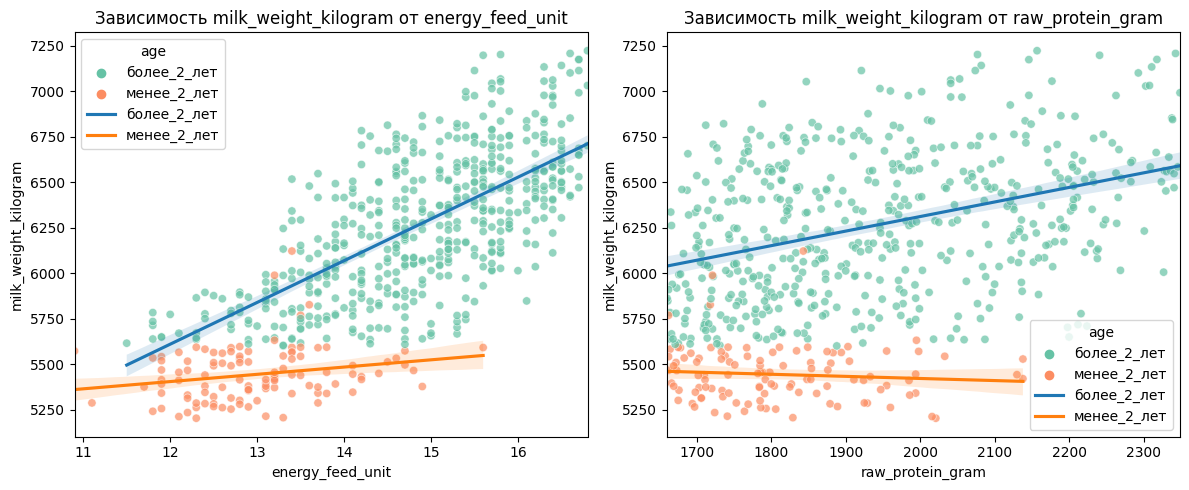

In [56]:
# Строим диаграмму рассеяния для разных возрастов
viz.scatterplot(x=['energy_feed_unit', 'raw_protein_gram'], y='milk_weight_kilogram', hue='age')

**Комментарий к графикам:**

* корреляция энергетической кормовой единицы в корме и удоя сильнее у коров старше 2-х лет, чем у коров младше 2-х лет, у которых корреляции ЭКЕ на удой имеет слабую связь


* если говорить о корреляции сырого протеина в молоке и удоя, то здесь корреляция у коров разного возраста имеет разную направленность:
    * для коров старше 2-х лет - корреляция положительная
    * для коров младше 2-х лет - корреляция отрицательная, хоть и слабая

#### Диаграмма рассеивания для признака Удой, кг в разрезе типа пастбища

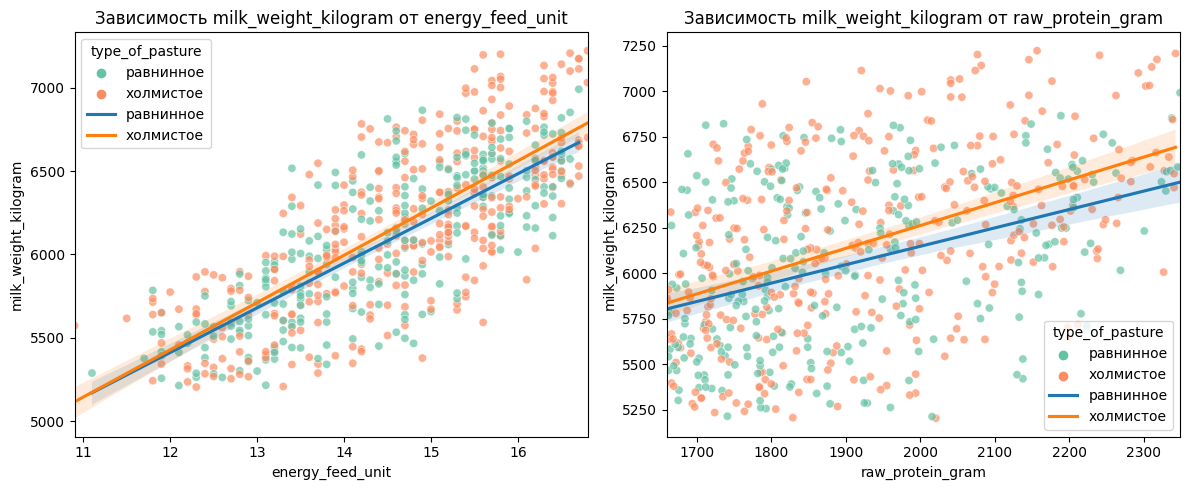

In [57]:
# Строим диаграмму рассеяния для разных типов пастбищ
viz.scatterplot(x=['energy_feed_unit', 'raw_protein_gram'], y='milk_weight_kilogram', hue='type_of_pasture')

**Комментарий к графикам:**

* корреляция энергетической кормовой единицы в корме и удоя сопоставимы у коров, которы пасутся на разных типах пастбищ - заметная положительная корреляция


* если говорить о корреляции сырого протеина в молоке и удоя, то здесь сильнее корреляция у коров, которые пасутся на холмистых пастбищах, чем на равнинных - общим остается умеренный положительный характер корреляции

#### Диаграмма рассеивания для признака Удой, кг в разрезе вкуса молока

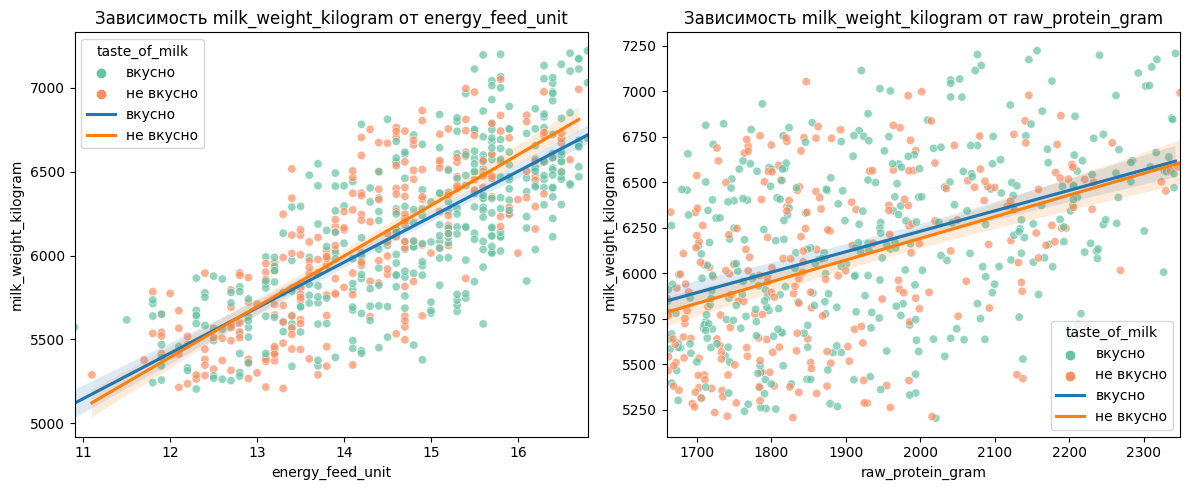

In [58]:
# Строим диаграмму рассеяния в разрезе вкусовых качеств молока
viz.scatterplot(x=['energy_feed_unit', 'raw_protein_gram'], y='milk_weight_kilogram', hue='taste_of_milk')

**Комментарий к графикам:**

* если говорить о энергетической кормовой единицы в корме и удоя, то здесь при росте ЭКЕ удой растет чуть быстрее у коров, дающих невкусное молоко - общим остается заметный положительный характер корреляции


* корреляция сырого протеина в корме и удоя сопоставимы у коров, дающих вкусное и невкусное молоко

### Проверка признаков на мультиколлениарность

In [59]:
# Определяем количественные признаки
num_features = ['energy_feed_unit', 'raw_protein_gram', 'sugar_protein_relationship', 'fat_percentage', \
                'protein_percentage', 'milk_weight_kilogram']

# Выбираем числовые признаки
X = ferma.data[num_features].dropna()
X = add_constant(X)

# Рассчитываем коэффициент инфляции дисперсии
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data['VIF'] = vif_data['VIF'].apply(lambda x: f'{x:,.0f}')
vif_data = vif_data[vif_data['feature'] != 'const']

# Выводим результат
print(vif_data)

                      feature VIF
1            energy_feed_unit   3
2            raw_protein_gram   1
3  sugar_protein_relationship   3
4              fat_percentage   2
5          protein_percentage   1
6        milk_weight_kilogram   4


Коэффициент инфляции дисперсии в пределах 4 - мультиколлениарность не подтвердилась

### Промежуточные выводы

* Тип взаимосвязи целевого признака Удой, кг и всех количественных признаков определен на диаграммах рассеивания
* Линейная прямая связь определена между удоем и сырым протеином в корме
* Нелинейный характер связи определен между удоем и энергетической кормовой единицей в корме
* Показатель сахарно-протеинового соотношения предлагается закодировать в категориальный признак, т.к. на графике рассеивания отчетливо видны паттерны распределения точек
* Показатель содержания белка и жиров в молоке оставить без изменений - т.к. связь между этими показателемя отсутствует
* Проверка количественных признаков на мультиколлениарность не подтвердила её наличие (коэффициент инфляции дисперсии в пределах 4)

## Обучение модели линейной регрессии

### Подготовка данных и обучение модели линейной регрессии (1-я итерация)

Согласно результатам построения диаграмм рассеивания для обучения модели линейной регресси в первой итерации воспользуемся:
* характеристиками коровы: порода коровы, порода папы коровы, возраст
* характеристиками корма: энергетическая кормовая единица, сырой протеин, сахарно-протеиновое соотношение
* характеристикой пастбища: тип пастбища

#### Разделение датасета на тренировочную и валидационную выборки

In [60]:
# Отбираем признаки
ferma.select_features(['milk_weight_kilogram', 'energy_feed_unit', 'raw_protein_gram', \
                       'sugar_protein_relationship', 'breed', 'type_of_pasture', \
                       'breed_of_papa_bull', 'age'])

print()

# Запускаем функцию разделения выборки на тренировочную и тестовую
ferma.split(target_column='milk_weight_kilogram')

Выбраны следующие признаки: ['milk_weight_kilogram', 'energy_feed_unit', 'raw_protein_gram', 'sugar_protein_relationship', 'breed', 'type_of_pasture', 'breed_of_papa_bull', 'age']

Разделение завершено: обучающая выборка - (471, 11), тестовая - (158, 11)


#### Анализ категориальных признаков

In [61]:
# Отберем список категориальных признаков
cat_col_names = ['breed', 'type_of_pasture', 'breed_of_papa_bull', 'age']

# Выведем на экран количество уникальных значений в категорильаных признаках тренировочной выборки
print(ferma.X_train[cat_col_names].nunique())

breed                 2
type_of_pasture       2
breed_of_papa_bull    2
age                   2
dtype: int64


#### Анализ количественных признаков

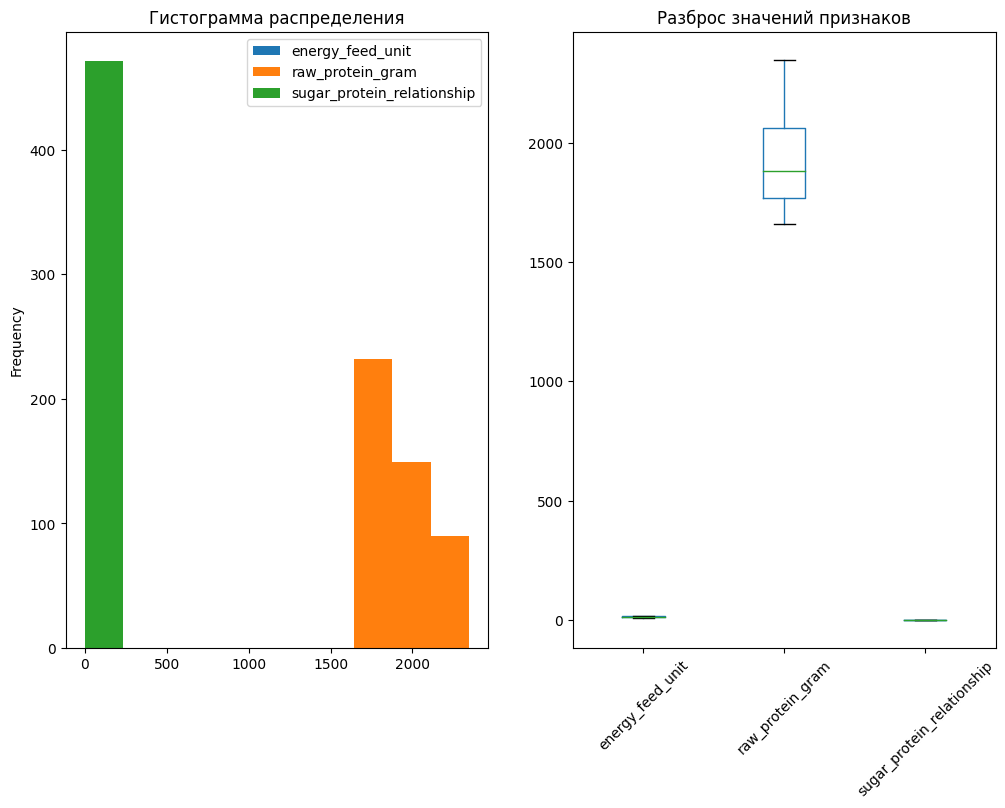

In [62]:
# Отберем список количественных признаков
num_col_names = ['energy_feed_unit', 'raw_protein_gram', 'sugar_protein_relationship']

# Построим графики для количественных признаков тренировочного датасета:
# гистограмму частотности распределения и ящик с усами
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

# Настройка гистограмм
ferma.X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')

ferma.X_train[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')

# Выводим на экран
plt.show()

#### Масштабирование количественных признаков

In [63]:
# Создаем переменную с экзамепляром класса StandardScaler()
scaler_lr_v1 = StandardScaler()

# Обучаем и трансформируем количественные признаки из тренировочной выборки
ferma.X_train_scaled = scaler_lr_v1.fit_transform(ferma.X_train[num_col_names])

# Выполняем преобразование количественных признаков в тестовой выборке
ferma.X_test_scaled = scaler_lr_v1.transform(ferma.X_test[num_col_names])

#### Масштабирование и кодирование категориальных признаков

In [64]:
# Создаем переменную с экземпляром класса OneHotEncoder()
# включаем параметр для избегания дамми-ошибок
# отключаем sparse-отображение
encoder_lr_v1 = OneHotEncoder(drop='first', sparse=False)

# Обучаем и трансформируем категориальные признаки из тренировочной выборки
ferma.X_train_ohe = encoder_lr_v1.fit_transform(ferma.X_train[cat_col_names])

# Выполняем преобразование категориальных признаков в тестовой выборке
ferma.X_test_ohe = encoder_lr_v1.transform(ferma.X_test[cat_col_names])

# Получаем от кодировщика список новых столбцов и сохраняем в новой переменной
encoder_col_names = encoder_lr_v1.get_feature_names()

# Создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов указываем из переменной encoder_col_names
ferma.X_train_ohe = pd.DataFrame(ferma.X_train_ohe, columns=encoder_col_names)
ferma.X_test_ohe = pd.DataFrame(ferma.X_test_ohe, columns=encoder_col_names)

ferma.X_train_scaled = pd.DataFrame(ferma.X_train_scaled, columns=num_col_names)
ferma.X_test_scaled = pd.DataFrame(ferma.X_test_scaled, columns=num_col_names)

# Объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
ferma.X_train = pd.concat([ferma.X_train_ohe, ferma.X_train_scaled], axis=1).reset_index(drop=True)
ferma.X_test = pd.concat([ferma.X_test_ohe, ferma.X_test_scaled], axis=1).reset_index(drop=True)

# Вывод пяти первых строк из тренировочной выборки
print(ferma.X_train.head())

   x0_Рефлешн Соверин  x1_холмистое  x2_Соверин  x3_менее_2_лет  \
0                 0.0           0.0         0.0             0.0   
1                 0.0           0.0         0.0             0.0   
2                 0.0           1.0         0.0             0.0   
3                 0.0           0.0         0.0             0.0   
4                 1.0           1.0         0.0             0.0   

   energy_feed_unit  raw_protein_gram  sugar_protein_relationship  
0          0.016344          0.248479                    0.814135  
1          0.095707         -1.392310                   -1.072496  
2          0.016344          1.124306                    0.499697  
3         -1.174092          0.858232                   -0.758057  
4          0.571881         -0.671693                    0.499697  


#### Количественные признаки после масштабирования

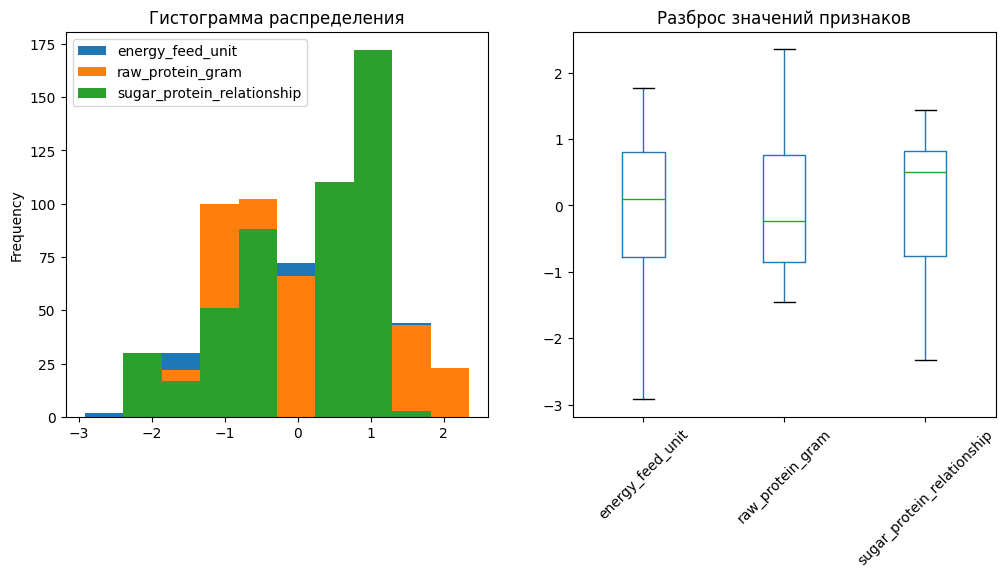

In [65]:
# Создание фигуры и осей
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Настройка гистограмм
ferma.X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')

ferma.X_train[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')

# Выводим на экран
plt.show()

#### Обучение и тестирование модели, оценка качества

In [66]:
# Инициализируем модель линейной регрессии
model_lr_v1  = LinearRegression()

# Обучаем модель на тренировочных данных
model_lr_v1.fit(ferma.X_train, ferma.y_train)

# Получаем предсказания модели на тестовых данных 
# Сохраняем результат в переменную predictions
predictions_v1 = model_lr_v1.predict(ferma.X_test)

# Посчитаем значение R2
r2 = r2_score(ferma.y_test, predictions_v1)

# Вывод метрики на экран
print(f'R2 LinearRegression = {r2:.2f}')

R2 LinearRegression = 0.82


#### Анализ остатков

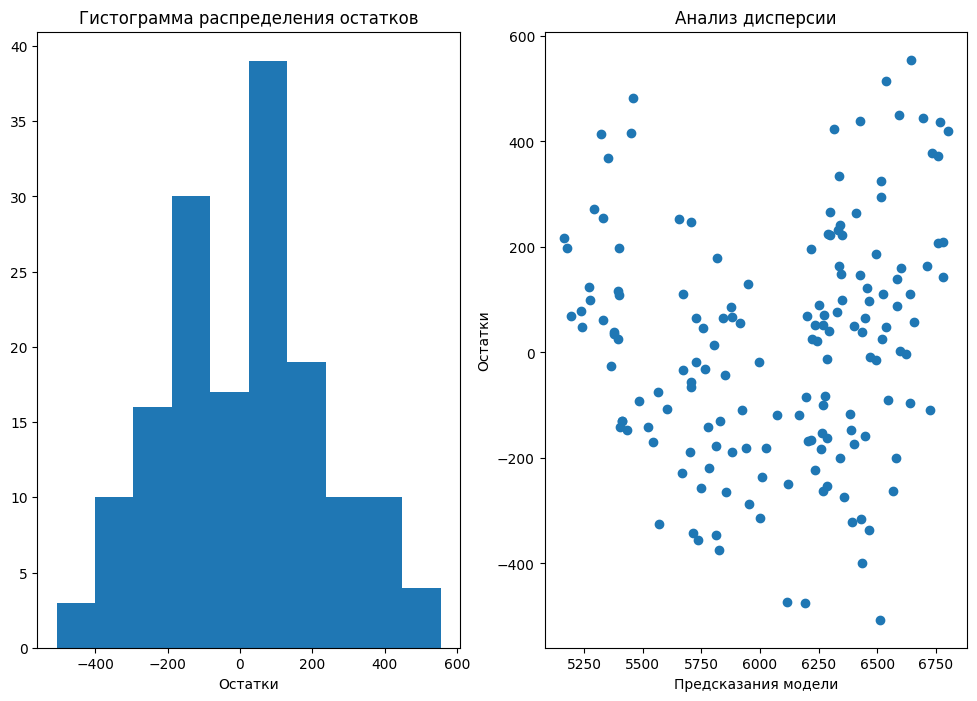

In [67]:
# Проведем анализ остатков, предварительно рассчитаем остатки
residuals_v1 = ferma.y_test - predictions_v1

# Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axes[0].hist(residuals_v1)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_v1, y=residuals_v1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

# Вывод на экран
plt.show()

#### Промежуточные выводы

* В рамках подготовки данных к обучению были:
    * проанализированы категориальные и количественные признаки (AS IS по результатам предобработки данных)
    * масштабированы количественные признаки, масштабированы и кодированы категориальные признаки
* Проведена оценка качестве модели по Коэффициенту детерминации R2, который составил 0.82, что говорит о хорошей точности модели.
* Дополнительно проанализировав остатки, пришли к заключению, что:
    * Распределение остатков имеет несимметричный мультимодальный характер
    * Дисперсия неравномерная
    * Вывод: точность модели необходимо улучшить.

### Подготовка данных и обучение модели линейной регрессии (2-я итерация)

#### Изменения, вносимые в датасет

В рамках этапа построения диаграмм рассеивания была обнаружена нелинейная связь между целевой переменной Удой и входными признаками Сахарно-протеиновое соотношение (СПО) и Энергетическая кормовая единица (ЭКЕ).

Для повышения точности модели:
   * Превратим признак СПО из количественного в категориальный бинарный признак (граница между категория 0.91)
   * Показатель ЭКЕ возведем в квадрат.

In [68]:
# Сбрасываем отобранные фичи
ferma.reset_features()

# Смотрим результат
ferma.show_info()

Сброшен выбор признаков — используются все признаки.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          629 non-null    int64  
 1   milk_weight_kilogram        629 non-null    int64  
 2   energy_feed_unit            629 non-null    float64
 3   raw_protein_gram            629 non-null    int64  
 4   sugar_protein_relationship  629 non-null    float64
 5   breed                       629 non-null    object 
 6   type_of_pasture             629 non-null    object 
 7   breed_of_papa_bull          629 non-null    object 
 8   fat_percentage              629 non-null    float64
 9   protein_percentage          629 non-null    float64
 10  taste_of_milk               629 non-null    object 
 11  age                         629 non-null    object 
dtypes: float64(4), int64(3), object(5)
memo

In [69]:
# Вводим новый бинарный категориальный признак
ferma.data.loc[:, 'SPR_category'] = (ferma.data['sugar_protein_relationship'] > 0.91).astype(int)

# Смотрим результат
ferma.data['SPR_category'].value_counts()

1    371
0    258
Name: SPR_category, dtype: int64

In [70]:
# Возводим показатель ЭКЕ в квадрат
ferma.data.loc[:, 'energy_feed_unit_squared'] = np.power(ferma.data['energy_feed_unit'], 2)

# Смотрим результат
print(ferma.data['energy_feed_unit'].describe())
print('-' * 10)
print(ferma.data['energy_feed_unit_squared'].describe())

count    629.000000
mean      14.543879
std        1.306408
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: energy_feed_unit, dtype: float64
----------
count    629.000000
mean     213.228410
std       37.531084
min      118.810000
25%      182.250000
50%      216.090000
75%      243.360000
max      282.240000
Name: energy_feed_unit_squared, dtype: float64


In [71]:
# Смотрим результат
ferma.show_info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          629 non-null    int64  
 1   milk_weight_kilogram        629 non-null    int64  
 2   energy_feed_unit            629 non-null    float64
 3   raw_protein_gram            629 non-null    int64  
 4   sugar_protein_relationship  629 non-null    float64
 5   breed                       629 non-null    object 
 6   type_of_pasture             629 non-null    object 
 7   breed_of_papa_bull          629 non-null    object 
 8   fat_percentage              629 non-null    float64
 9   protein_percentage          629 non-null    float64
 10  taste_of_milk               629 non-null    object 
 11  age                         629 non-null    object 
 12  SPR_category                629 non-null    int64  
 13  energy_feed_unit_squared    629 non

#### Разделение датасета на тренировочную и валидационную выборки

In [72]:
# Отбираем признаки
ferma.select_features(['milk_weight_kilogram', 'energy_feed_unit_squared', 'raw_protein_gram', \
                       'SPR_category', 'breed', 'type_of_pasture', 'breed_of_papa_bull', 'age'])

print()

# Запускаем функцию разделения выборки на тренировочную и тестовую
ferma.split(target_column='milk_weight_kilogram')

Выбраны следующие признаки: ['milk_weight_kilogram', 'energy_feed_unit_squared', 'raw_protein_gram', 'SPR_category', 'breed', 'type_of_pasture', 'breed_of_papa_bull', 'age']

Разделение завершено: обучающая выборка - (471, 13), тестовая - (158, 13)


#### Анализ категориальных признаков

In [73]:
# Отберем список категориальных признаков
cat_col_names = ['SPR_category', 'breed', 'type_of_pasture', 'breed_of_papa_bull', 'age']

# Выведем на экран количество уникальных значений в категорильаных признаках тренировочной выборки
print(ferma.X_train[cat_col_names].nunique())

SPR_category          2
breed                 2
type_of_pasture       2
breed_of_papa_bull    2
age                   2
dtype: int64


#### Анализ количественных признаков

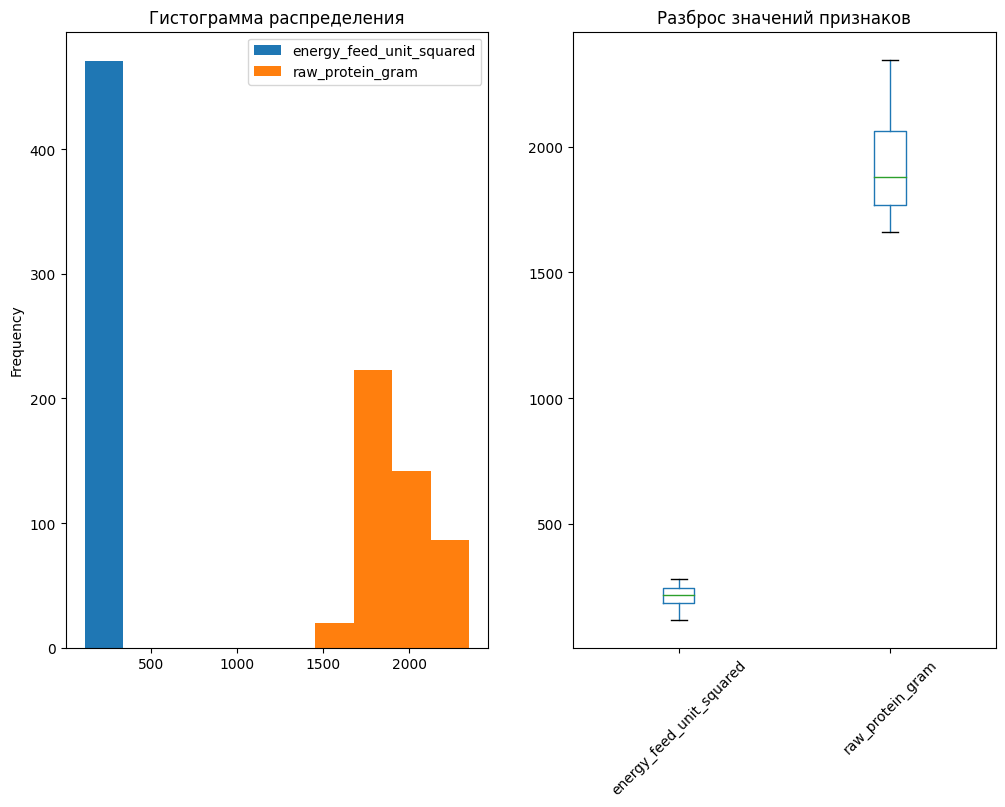

In [74]:
# Отберем список количественных признаков
num_col_names = ['energy_feed_unit_squared', 'raw_protein_gram']

# Построим графики для количественных признаков тренировочного датасета:
# гистограмму частотности распределения и ящик с усами
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

# Настройка гистограмм
ferma.X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')

ferma.X_train[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')

# Выводим на экран
plt.show()

#### Масштабирование количественных признаков

In [75]:
# Создаем переменную с экзамепляром класса StandardScaler()
scaler_lr_v2 = StandardScaler()

# Обучаем и трансформируем количественные признаки из тренировочной выборки
ferma.X_train_scaled = scaler_lr_v2.fit_transform(ferma.X_train[num_col_names])

# Выполняем преобразование количественных признаков в тестовой выборке
ferma.X_test_scaled = scaler_lr_v2.transform(ferma.X_test[num_col_names])

#### Масштабирование и кодирование категориальных признаков

In [76]:
# Создаем переменную с экземпляром класса OneHotEncoder()
# включаем параметр для избегания дамми-ошибок
# отключаем sparse-отображение
encoder_lr_v2 = OneHotEncoder(drop='first', sparse=False)

# Обучаем и трансформируем категориальные признаки из тренировочной выборки
ferma.X_train_ohe = encoder_lr_v2.fit_transform(ferma.X_train[cat_col_names])

# Выполняем преобразование категориальных признаков в тестовой выборке
ferma.X_test_ohe = encoder_lr_v2.transform(ferma.X_test[cat_col_names])

# Получаем от кодировщика список новых столбцов и сохраняем в новой переменной
encoder_col_names = encoder_lr_v2.get_feature_names()

# Создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов указываем из переменной encoder_col_names
ferma.X_train_ohe = pd.DataFrame(ferma.X_train_ohe, columns=encoder_col_names)
ferma.X_test_ohe = pd.DataFrame(ferma.X_test_ohe, columns=encoder_col_names)

ferma.X_train_scaled = pd.DataFrame(ferma.X_train_scaled, columns=num_col_names)
ferma.X_test_scaled = pd.DataFrame(ferma.X_test_scaled, columns=num_col_names)

# Объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
ferma.X_train = pd.concat([ferma.X_train_ohe, ferma.X_train_scaled], axis=1).reset_index(drop=True)
ferma.X_test = pd.concat([ferma.X_test_ohe, ferma.X_test_scaled], axis=1).reset_index(drop=True)

# Вывод пяти первых строк из тренировочной выборки
print(ferma.X_train.head())

   x0_1  x1_Рефлешн Соверин  x2_холмистое  x3_Соверин  x4_менее_2_лет  \
0   1.0                 0.0           0.0         0.0             0.0   
1   0.0                 0.0           0.0         0.0             0.0   
2   1.0                 0.0           1.0         0.0             0.0   
3   0.0                 0.0           0.0         0.0             0.0   
4   1.0                 1.0           1.0         0.0             0.0   

   energy_feed_unit_squared  raw_protein_gram  
0                 -0.027210          0.248479  
1                  0.053583         -1.392310  
2                 -0.027210          1.124306  
3                 -1.172927          0.858232  
4                  0.549923         -0.671693  


#### Количественные признаки после масштабирования

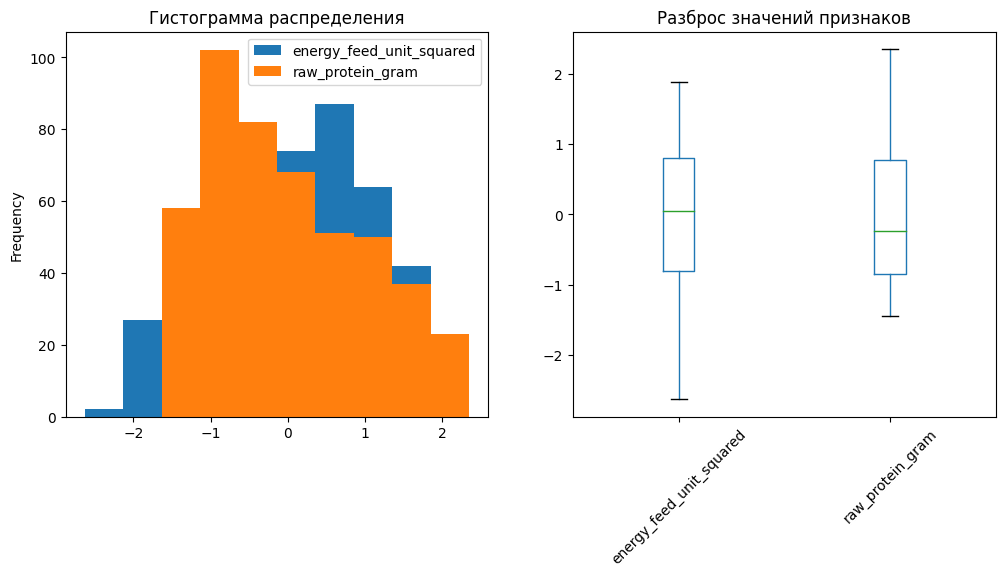

In [77]:
# Создание фигуры и осей
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Настройка гистограмм
ferma.X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')

ferma.X_train[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')

# Выводим на экран
plt.show()

#### Обучение и тестирование модели, оценка качества

In [78]:
# Инициализируем модель линейной регрессии
model_lr_v2  = LinearRegression()

# Обучаем модель на тренировочных данных
model_lr_v2.fit(ferma.X_train, ferma.y_train)

# Получаем предсказания модели на тестовых данных 
# Сохраняем результат в переменную predictions
predictions_v2 = model_lr_v2.predict(ferma.X_test)

# Посчитаем значение R2
r2 = r2_score(ferma.y_test, predictions_v2)

# Вывод метрики на экран
print(f'R2 LinearRegression = {r2:.2f}')

R2 LinearRegression = 0.84


#### Анализ остатков

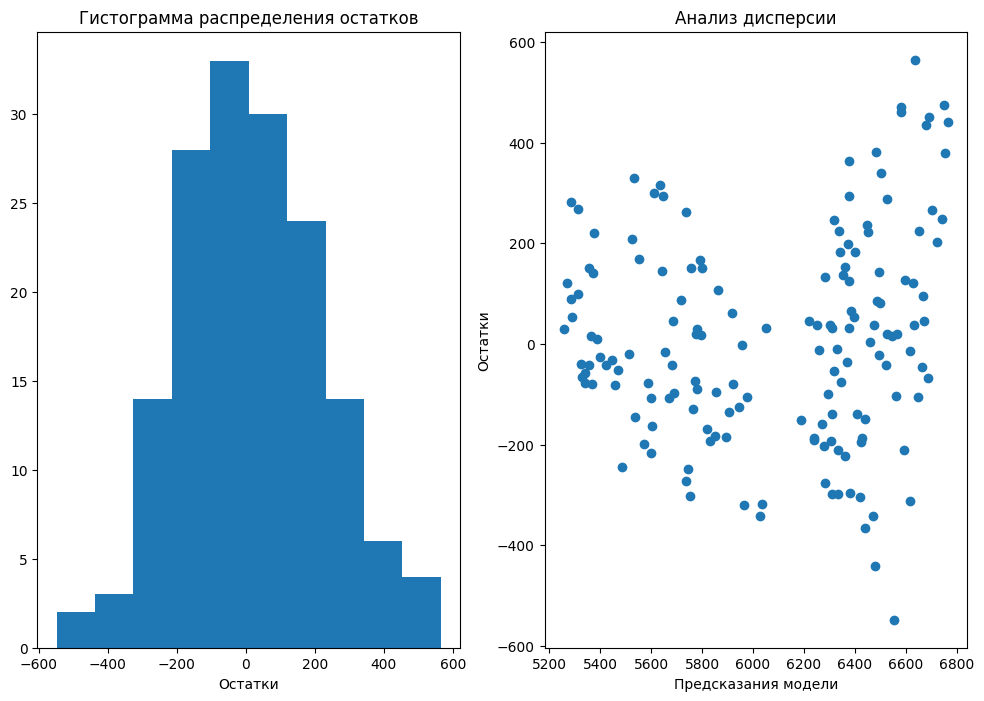

In [79]:
# Проведем анализ остатков, предварительно рассчитаем остатки
residuals_v2 = ferma.y_test - predictions_v2

# Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axes[0].hist(residuals_v2)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_v2, y=residuals_v2)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

# Вывод на экран
plt.show()

#### Промежуточные выводы

* В рамках подготовки данных к обучению были изменены 2 входных признака (характеристики корма):
    * ЭКЕ - значения возведены в квадраты
    * СПО - значения перекодированы в категориальный бинарный вид
* Далее пройдены этапы, аналогичные подготовке модели в первой итерации.
* Проведена оценка качества модели по Коэффициенту детерминации R2, который составил 0.84, что говорит о повышении точности модели.
* Дополнительно проанализировав остатки модели во второй итерации, пришли к заключению, что:
    * Распределение остатков имеет симметричный унимодальный характер с небольшим смещением влево (модель немного завышает прогнозные значения)
    * Дисперсия всё также неравномерная
    * Вывод: точность модели необходимо улучшить.

### Подготовка данных и обучение модели линейной регрессии (3-я итерация)

#### Изменения, вносимые в датасет

Для повышения точности модели добавим в данные новый признак: `papa_bull_name` из датасета **ferma_dad**

In [80]:
# Проверим совпадающие id
common_ids = ferma.data['id'].isin(dad.data['id']).sum()
print(f'Совпадающих id: {common_ids} из {len(ferma.data)}')

Совпадающих id: 629 из 629


In [81]:
# Добавим новый столбец из датасета dad
ferma.data = pd.merge(ferma.data, dad.data, on='id', how='left')

# Смотрим результат
ferma.show_info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          629 non-null    int64  
 1   milk_weight_kilogram        629 non-null    int64  
 2   energy_feed_unit            629 non-null    float64
 3   raw_protein_gram            629 non-null    int64  
 4   sugar_protein_relationship  629 non-null    float64
 5   breed                       629 non-null    object 
 6   type_of_pasture             629 non-null    object 
 7   breed_of_papa_bull          629 non-null    object 
 8   fat_percentage              629 non-null    float64
 9   protein_percentage          629 non-null    float64
 10  taste_of_milk               629 non-null    object 
 11  age                         629 non-null    object 
 12  SPR_category                629 non-null    int64  
 13  energy_feed_unit_squared    629 non

#### Разделение датасета на тренировочную и валидационную выборки

In [82]:
# Отбираем признаки
ferma.select_features(['milk_weight_kilogram', 'energy_feed_unit_squared', 'raw_protein_gram', \
                       'papa_bull_name', 'SPR_category', 'breed', 'type_of_pasture', 'breed_of_papa_bull', 'age'])

print()

# Запускаем функцию разделения выборки на тренировочную и тестовую
ferma.split(target_column='milk_weight_kilogram')

Выбраны следующие признаки: ['milk_weight_kilogram', 'energy_feed_unit_squared', 'raw_protein_gram', 'papa_bull_name', 'SPR_category', 'breed', 'type_of_pasture', 'breed_of_papa_bull', 'age']

Разделение завершено: обучающая выборка - (471, 14), тестовая - (158, 14)


#### Анализ категориальных признаков

In [83]:
# Отберем список категориальных признаков
cat_col_names = ['papa_bull_name', 'SPR_category', 'breed', 'type_of_pasture', 'breed_of_papa_bull', 'age']

# Выведем на экран количество уникальных значений в категорильаных признаках тренировочной выборки
print(ferma.X_train[cat_col_names].nunique())

papa_bull_name        4
SPR_category          2
breed                 2
type_of_pasture       2
breed_of_papa_bull    2
age                   2
dtype: int64


#### Анализ количественных признаков

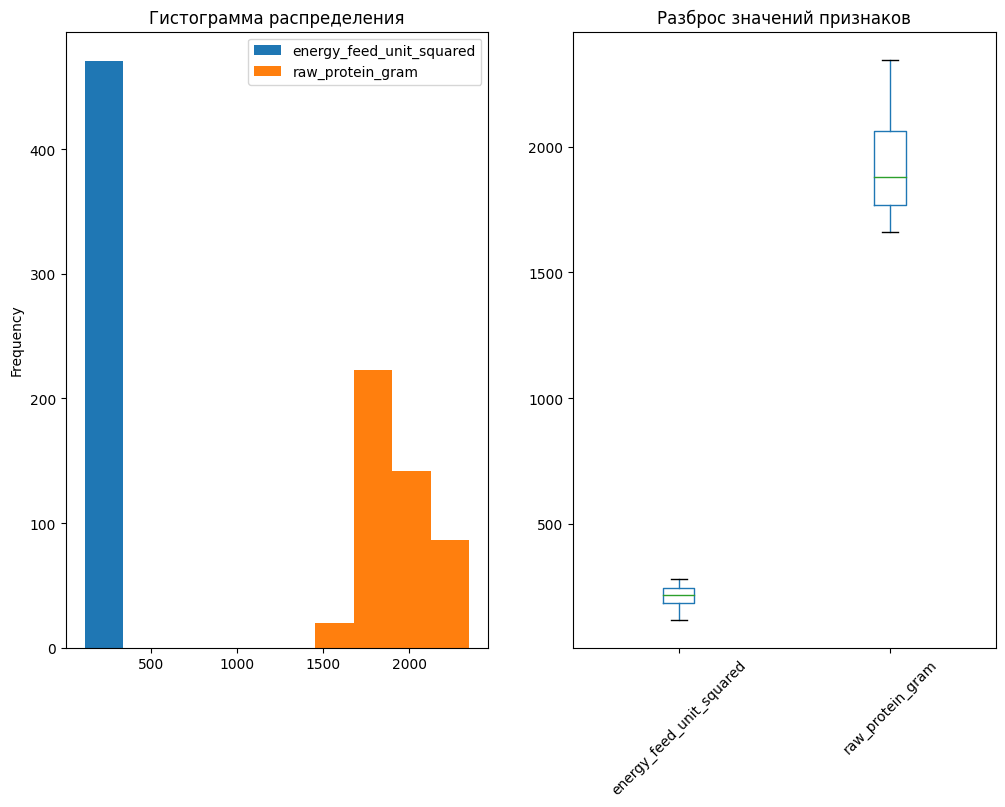

In [84]:
# Отберем список количественных признаков
num_col_names = ['energy_feed_unit_squared', 'raw_protein_gram']

# Построим графики для количественных признаков тренировочного датасета:
# гистограмму частотности распределения и ящик с усами
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

# Настройка гистограмм
ferma.X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')

ferma.X_train[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')

# Выводим на экран
plt.show()

#### Масштабирование количественных признаков

In [85]:
# Создаем переменную с экзамепляром класса StandardScaler()
scaler_lr_v3 = StandardScaler()

# Обучаем и трансформируем количественные признаки из тренировочной выборки
ferma.X_train_scaled = scaler_lr_v3.fit_transform(ferma.X_train[num_col_names])

# Выполняем преобразование количественных признаков в тестовой выборке
ferma.X_test_scaled = scaler_lr_v3.transform(ferma.X_test[num_col_names])

#### Масштабирование и кодирование категориальных признаков

In [86]:
# Создаем переменную с экземпляром класса OneHotEncoder()
# включаем параметр для избегания дамми-ошибок
# отключаем sparse-отображение
encoder_lr_v3 = OneHotEncoder(drop='first', sparse=False)

# Обучаем и трансформируем категориальные признаки из тренировочной выборки
ferma.X_train_ohe = encoder_lr_v3.fit_transform(ferma.X_train[cat_col_names])

# Выполняем преобразование категориальных признаков в тестовой выборке
ferma.X_test_ohe = encoder_lr_v3.transform(ferma.X_test[cat_col_names])

# Получаем от кодировщика список новых столбцов и сохраняем в новой переменной
encoder_col_names = encoder_lr_v3.get_feature_names()

# Создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов указываем из переменной encoder_col_names
ferma.X_train_ohe = pd.DataFrame(ferma.X_train_ohe, columns=encoder_col_names)
ferma.X_test_ohe = pd.DataFrame(ferma.X_test_ohe, columns=encoder_col_names)

ferma.X_train_scaled = pd.DataFrame(ferma.X_train_scaled, columns=num_col_names)
ferma.X_test_scaled = pd.DataFrame(ferma.X_test_scaled, columns=num_col_names)

# Объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
ferma.X_train = pd.concat([ferma.X_train_ohe, ferma.X_train_scaled], axis=1).reset_index(drop=True)
ferma.X_test = pd.concat([ferma.X_test_ohe, ferma.X_test_scaled], axis=1).reset_index(drop=True)

# Вывод пяти первых строк из тренировочной выборки
print(ferma.X_train.head())

   x0_Буйный  x0_Геркулес  x0_Соловчик  x1_1  x2_Рефлешн Соверин  \
0        1.0          0.0          0.0   1.0                 0.0   
1        1.0          0.0          0.0   0.0                 0.0   
2        1.0          0.0          0.0   1.0                 0.0   
3        0.0          1.0          0.0   0.0                 0.0   
4        1.0          0.0          0.0   1.0                 1.0   

   x3_холмистое  x4_Соверин  x5_менее_2_лет  energy_feed_unit_squared  \
0           0.0         0.0             0.0                 -0.027210   
1           0.0         0.0             0.0                  0.053583   
2           1.0         0.0             0.0                 -0.027210   
3           0.0         0.0             0.0                 -1.172927   
4           1.0         0.0             0.0                  0.549923   

   raw_protein_gram  
0          0.248479  
1         -1.392310  
2          1.124306  
3          0.858232  
4         -0.671693  


#### Количественные признаки после масштабирования

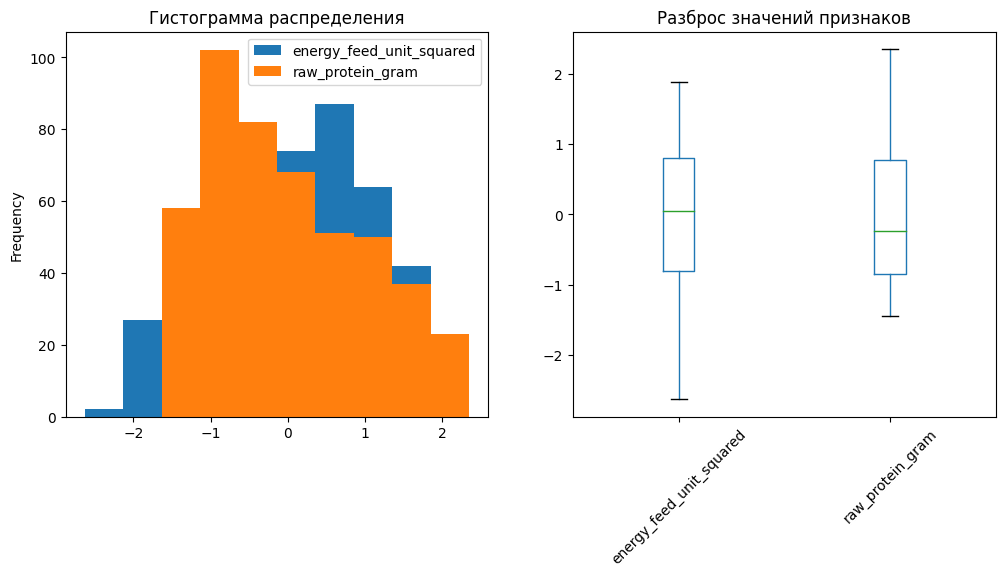

In [87]:
# Создание фигуры и осей
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Настройка гистограмм
ferma.X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')

ferma.X_train[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')

# Выводим на экран
plt.show()

#### Обучение и тестирование модели, оценка качества

In [88]:
# Инициализируем модель линейной регрессии
model_lr_v3  = LinearRegression()

# Обучаем модель на тренировочных данных
model_lr_v3.fit(ferma.X_train, ferma.y_train)

# Получаем предсказания модели на тестовых данных 
# Сохраняем результат в переменную predictions
predictions_v3 = model_lr_v3.predict(ferma.X_test)

# Посчитаем значение R2
r2 = r2_score(ferma.y_test, predictions_v3)

# Вывод метрики на экран
print(f'R2 LinearRegression = {r2:.2f}')

R2 LinearRegression = 0.86


#### Анализ остатков

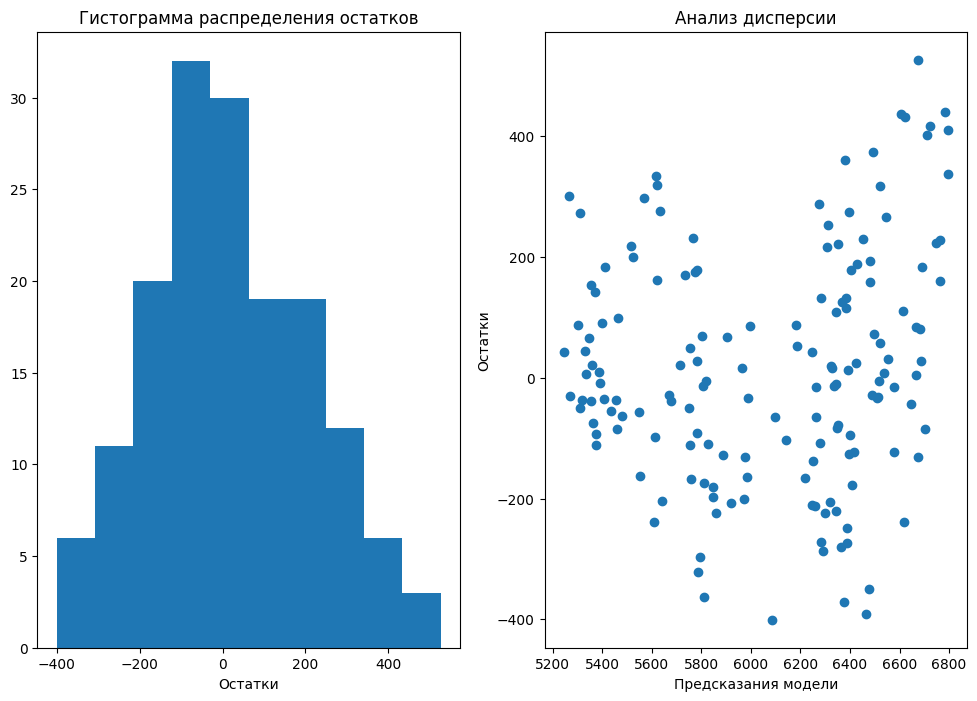

In [89]:
# Проведем анализ остатков, предварительно рассчитаем остатки
residuals_v3 = ferma.y_test - predictions_v3

# Построим графики по количественным признакам — гистограмму частотности распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axes[0].hist(residuals_v3)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x=predictions_v3, y=residuals_v3)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

# Вывод на экран
plt.show()

#### Промежуточные выводы

* В рамках подготовки данных к обучению был добавлен 1 входной признак из датасета dad (характеристики коровы):
    * имя папы быка - категориальный признак
* Далее пройдены этапы, аналогичные подготовке моделей в первой и второй итерациях.
* Проведена оценка качества модели по Коэффициенту детерминации R2, который составил 0.86, что говорит о повышении точности модели.
* Дополнительно проанализировав остатки модели во второй итерации, пришли к заключению, что:
    * Распределение остатков имеет симметричный унимодальный характер с небольшим смещением влево (модель немного завышает прогнозные значения)
    * Дисперсия стала чуть более предсказуемой - облако точек заполнило значения ближе к оси X (что говорит о положительном влиянии на точность модели).

### Сравнение качества трех моделей

In [90]:
# Присваиваем значение целевой переменной
y_true = ferma.y_test

# Считаем метрики по всем моделям
df_metrics = ferma.count_linear_regression_metrics(
    y_true_list=[y_true, y_true, y_true],
    y_pred_list=[predictions_v1, predictions_v2, predictions_v3],
    model_names=['Base', 'Encoded', 'Extra feature']
)

# Выводим таблицу с результатами
print(df_metrics)

           Model       MSE    RMSE     MAE    R2
0           Base  49470.60  222.42  180.80  0.82
1        Encoded  42729.68  206.71  164.12  0.84
2  Extra feature  37613.18  193.94  153.51  0.86


### Прогноз удоя коров

In [91]:
# Считаем средние значения
means = ferma.data[['energy_feed_unit', 'raw_protein_gram', 'sugar_protein_relationship']].mean() * 1.05

# Добавляем средние значения к датасету cow
cow_combined = cow.data.assign(**means)

# Создаем новый объект класса Data
cow_combined_data = Data(cow_combined)

# Выводим результат на экран
cow_combined_data.print_head()

breed type_of_pasture breed_of_papa_bull papa_bull_name  \
0   Вис Бик Айдиал       холмистое             Айдиал       Геркулес   
1   Вис Бик Айдиал       равнинное            Соверин         Буйный   
2  Рефлешн Соверин       равнинное            Соверин          Барин   
3  Рефлешн Соверин       холмистое             Айдиал         Буйный   
4  Рефлешн Соверин       равнинное             Айдиал         Буйный   

   fat_percentage  protein_percentage          age  energy_feed_unit  \
0            3.58               3.076  более_2_лет         15.271073   
1            3.54               3.081  менее_2_лет         15.271073   
2            3.59               3.074  более_2_лет         15.271073   
3            3.40               3.061  более_2_лет         15.271073   
4            3.64               3.074  более_2_лет         15.271073   

   raw_protein_gram  sugar_protein_relationship  
0       2019.532273                    0.958772  
1       2019.532273                    0.958772  
2       2019.532273                    0.958772  
3       2019.532273                    0.958772  
4       2019.532273                    0.958772

In [92]:
# Проверяем, есть ли пустые строки
cow_combined_data.count_missing_values()

breed                         0
type_of_pasture               0
breed_of_papa_bull            0
papa_bull_name                0
fat_percentage                0
protein_percentage            0
age                           0
energy_feed_unit              0
raw_protein_gram              0
sugar_protein_relationship    0
dtype: int64

#### Добавление признаков

In [93]:
# Вводим новый бинарный категориальный признак
cow_combined_data.data.loc[:, 'SPR_category'] = (cow_combined_data.data['sugar_protein_relationship'] > 0.92).astype(int)

# Смотрим результат
cow_combined_data.data['SPR_category'].value_counts()

1    20
Name: SPR_category, dtype: int64

In [94]:
# Возводим показатель ЭКЕ в квадрат
cow_combined_data.data.loc[:, 'energy_feed_unit_squared'] = np.power(cow_combined_data.data['energy_feed_unit'], 2)

# Смотрим результат
print(cow_combined_data.data['energy_feed_unit'].describe())
print('-' * 10)
print(cow_combined_data.data['energy_feed_unit_squared'].describe())

count    2.000000e+01
mean     1.527107e+01
std      3.645007e-15
min      1.527107e+01
25%      1.527107e+01
50%      1.527107e+01
75%      1.527107e+01
max      1.527107e+01
Name: energy_feed_unit, dtype: float64
----------
count     20.000000
mean     233.205675
std        0.000000
min      233.205675
25%      233.205675
50%      233.205675
75%      233.205675
max      233.205675
Name: energy_feed_unit_squared, dtype: float64


#### Анализ категориальных признаков

In [95]:
# Присвоим датасету имя X_predict
cow_combined_data.X_predict = cow_combined_data.data

# Отберем список категориальных признаков
cat_col_names = ['papa_bull_name', 'SPR_category', 'breed', 'type_of_pasture', 'breed_of_papa_bull', 'age']

# Выведем на экран количество уникальных значений в категорильаных признаках тренировочной выборки
print(cow_combined_data.X_predict[cat_col_names].nunique())

papa_bull_name        4
SPR_category          1
breed                 2
type_of_pasture       2
breed_of_papa_bull    2
age                   2
dtype: int64


In [96]:
cow_combined_data.show_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   breed                       20 non-null     object 
 1   type_of_pasture             20 non-null     object 
 2   breed_of_papa_bull          20 non-null     object 
 3   papa_bull_name              20 non-null     object 
 4   fat_percentage              20 non-null     float64
 5   protein_percentage          20 non-null     float64
 6   age                         20 non-null     object 
 7   energy_feed_unit            20 non-null     float64
 8   raw_protein_gram            20 non-null     float64
 9   sugar_protein_relationship  20 non-null     float64
 10  SPR_category                20 non-null     int64  
 11  energy_feed_unit_squared    20 non-null     float64
dtypes: float64(6), int64(1), object(5)
memory usage: 2.0+ KB


#### Анализ количественных признаков

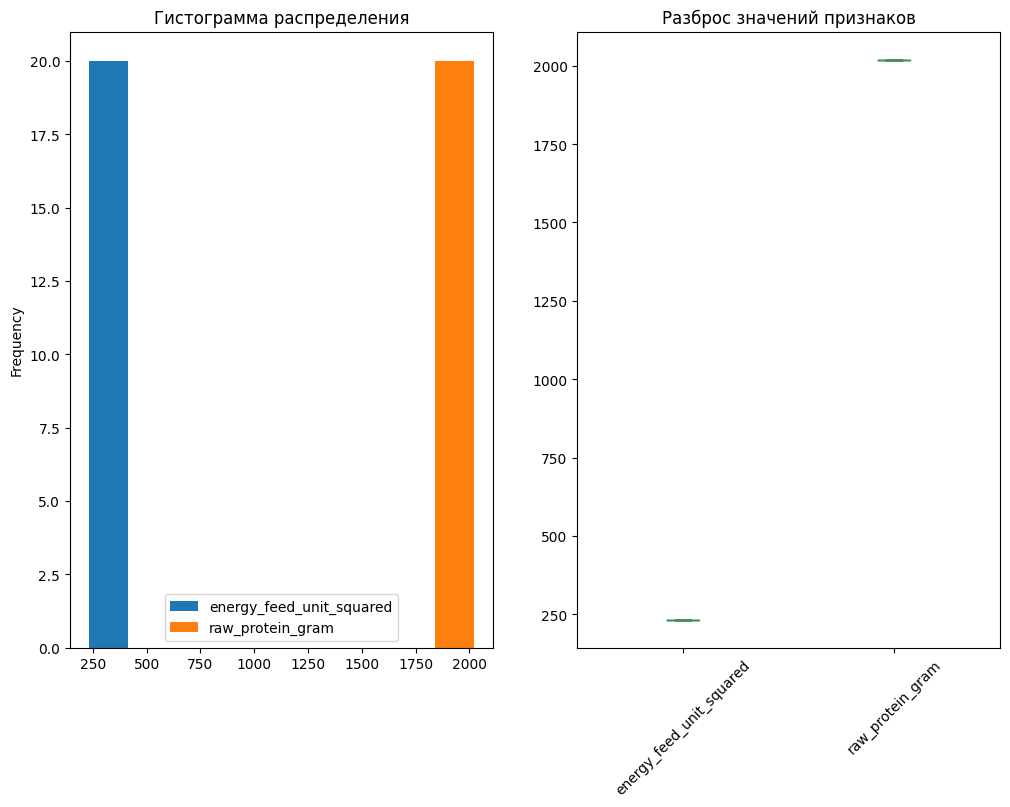

In [97]:
# Отберем список количественных признаков
num_col_names = ['energy_feed_unit_squared', 'raw_protein_gram']

# Построим графики для количественных признаков тренировочного датасета:
# гистограмму частотности распределения и ящик с усами
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

# Настройка гистограмм
cow_combined_data.X_predict[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')

cow_combined_data.X_predict[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')

# Выводим на экран
plt.show()

#### Масштабирование количественных признаков

In [98]:
# Трансформируем количественные признаки из тестовой выборки
cow_combined_data.X_predict_scaled = scaler_lr_v3.transform(cow_combined_data.X_predict[num_col_names])

#### Масштабирование и кодирование категориальных признаков

In [99]:
# Выполняем преобразование категориальных признаков в тестовой выборке
cow_combined_data.X_predict_ohe = encoder_lr_v3.transform(cow_combined_data.X_predict[cat_col_names])

# Получаем от кодировщика список новых столбцов и сохраняем в новой переменной
encoder_col_names = encoder_lr_v3.get_feature_names()

# Создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов указываем из переменной encoder_col_names
cow_combined_data.X_predict_ohe = pd.DataFrame(cow_combined_data.X_predict_ohe, columns=encoder_col_names)

cow_combined_data.X_predict_scaled = pd.DataFrame(cow_combined_data.X_predict_scaled, columns=num_col_names)

# Объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
cow_combined_data.X_predict = pd.concat([cow_combined_data.X_predict_ohe, cow_combined_data.X_predict_scaled], axis=1).reset_index(drop=True)

# Вывод пяти первых строк из тренировочной выборки
print(cow_combined_data.X_predict.head())

   x0_Буйный  x0_Геркулес  x0_Соловчик  x1_1  x2_Рефлешн Соверин  \
0        0.0          1.0          0.0   1.0                 0.0   
1        1.0          0.0          0.0   1.0                 0.0   
2        0.0          0.0          0.0   1.0                 1.0   
3        1.0          0.0          0.0   1.0                 1.0   
4        1.0          0.0          0.0   1.0                 1.0   

   x3_холмистое  x4_Соверин  x5_менее_2_лет  energy_feed_unit_squared  \
0           1.0         0.0             0.0                  0.525538   
1           0.0         1.0             1.0                  0.525538   
2           0.0         1.0             0.0                  0.525538   
3           1.0         0.0             0.0                  0.525538   
4           0.0         0.0             0.0                  0.525538   

   raw_protein_gram  
0          0.539677  
1          0.539677  
2          0.539677  
3          0.539677  
4          0.539677  


#### Количественные признаки после масштабирования

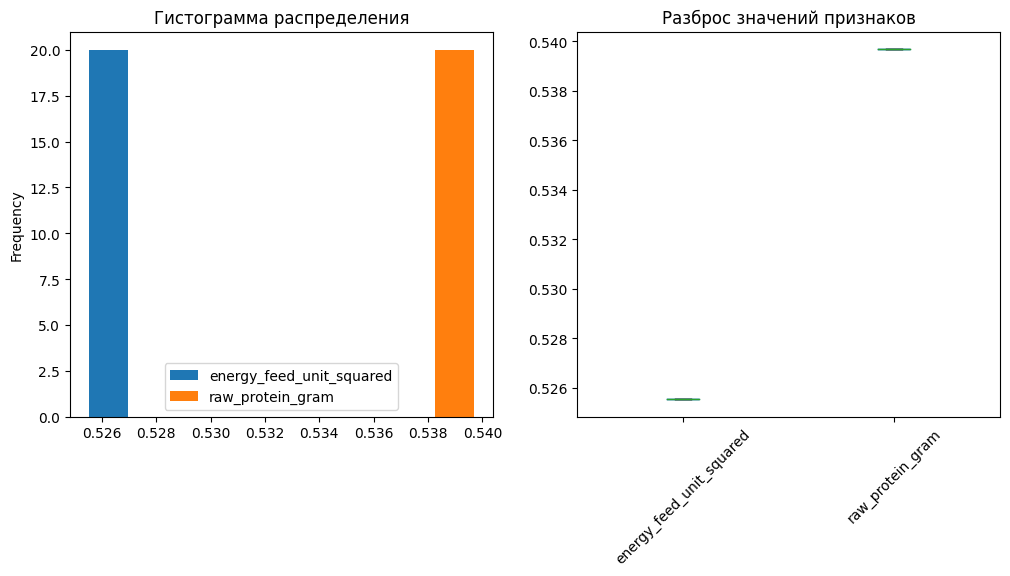

In [100]:
# Создание фигуры и осей
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Настройка гистограмм
cow_combined_data.X_predict[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')

cow_combined_data.X_predict[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')

# Выводим на экран
plt.show()

#### Тестирование модели

In [101]:
# Получаем предсказания модели на тестовых данных 
# Сохраняем результат в переменную predictions
predictions_v4 = model_lr_v3.predict(cow_combined_data.X_predict)

# Проверяем размерность
print(len(predictions_v4), len(cow_combined_data.data))

20 20


In [102]:
# Присваиваем новому столбцу прогнозные значения
cow_combined_data.data['milk_weight_kilogram'] = predictions_v4

# Смотрим результат
cow_combined_data.print_head()

breed type_of_pasture breed_of_papa_bull papa_bull_name  \
0   Вис Бик Айдиал       холмистое             Айдиал       Геркулес   
1   Вис Бик Айдиал       равнинное            Соверин         Буйный   
2  Рефлешн Соверин       равнинное            Соверин          Барин   
3  Рефлешн Соверин       холмистое             Айдиал         Буйный   
4  Рефлешн Соверин       равнинное             Айдиал         Буйный   

   fat_percentage  protein_percentage          age  energy_feed_unit  \
0            3.58               3.076  более_2_лет         15.271073   
1            3.54               3.081  менее_2_лет         15.271073   
2            3.59               3.074  более_2_лет         15.271073   
3            3.40               3.061  более_2_лет         15.271073   
4            3.64               3.074  более_2_лет         15.271073   

   raw_protein_gram  sugar_protein_relationship  SPR_category  \
0       2019.532273                    0.958772             1   
1       2019.532273                    0.958772             1   
2       2019.532273                    0.958772             1   
3       2019.532273                    0.958772             1   
4       2019.532273                    0.958772             1   

   energy_feed_unit_squared  milk_weight_kilogram  
0                233.205675           6548.894758  
1                233.205675           6296.356138  
2                233.205675           6288.075446  
3                233.205675           6593.392859  
4                233.205675           6542.740613

In [103]:
print(ferma.data['milk_weight_kilogram'].describe())
print('-' * 10)
print(cow_combined_data.data['milk_weight_kilogram'].describe())

count     629.000000
mean     6125.157393
std       475.912622
min      5204.000000
25%      5746.000000
50%      6132.000000
75%      6501.000000
max      7222.000000
Name: milk_weight_kilogram, dtype: float64
----------
count      20.000000
mean     6424.477801
std       139.715005
min      6087.432987
25%      6332.744695
50%      6444.874499
75%      6548.894758
max      6593.392859
Name: milk_weight_kilogram, dtype: float64


#### Промежуточные выводы

* Для прогнозирования значений удоя в тестовой выборке выбрана модель №3 (с модернизацией входных признаков и добавлением новых признаков).
* Тестовая выборка составил 20 строк. Среднее значение удоя 6424 кг, медиана 6444 кг, минимум 6087 кг, максимум 6593 кг.
* За исключением максимума, все остальные статистики выше показателей модели, обученной на тренировочной выборке.
* Данные показатели ожидаемы с учетом анализа остатков модели, где распределение значений было смещено влево, то есть модель склонна делать позитивный прогноз значений по удою (завышать его).

### Промежуточные выводы

**Построение модели линейной регрессии (итерация №1)**
* В рамках подготовки данных к обучению были:
    * проанализированы категориальные и количественные признаки (AS IS по результатам предобработки данных)
    * масштабированы количественные признаки, масштабированы и кодированы категориальные признаки
* Проведена оценка качестве модели по Коэффициенту детерминации R2, который составил 0.82, что говорит о хорошей точности модели.
* Дополнительно проанализировав остатки, пришли к заключению, что:
    * Распределение остатков имеет несимметричный мультимодальный характер
    * Дисперсия неравномерная
    * Вывод: точность модели необходимо улучшить.

---
**Построение модели линейной регрессии (итерация №2)**
* В рамках подготовки данных к обучению были изменены 2 входных признака (характеристики корма):
        * ЭКЕ - значения возведены в квадраты
        * СПО - значения перекодированы в категориальный бинарный вид
* Далее пройдены этапы, аналогичные подготовке модели в первой итерации.
* Проведена оценка качества модели по Коэффициенту детерминации R2, который составил 0.84, что говорит о повышении точности модели.
* Дополнительно проанализировав остатки модели во второй итерации, пришли к заключению, что:
    * Распределение остатков имеет симметричный унимодальный характер с небольшим смещением влево (модель немного завышает прогнозные значения)
    * Дисперсия всё также неравномерная
    * Вывод: точность модели необходимо улучшить.

---
**Построение модели линейной регрессии (итерация №3) - лучшая**
* В рамках подготовки данных к обучению был добавлен 1 входной признак из датасета dad (характеристики коровы):
        * имя папы быка - категориальный признак
* Далее пройдены этапы, аналогичные подготовке моделям в первой и второй итерациях.
* Проведена оценка качества модели по Коэффициенту детерминации R2, который составил 0.86, что говорит о повышении точности модели.
* Дополнительно проанализировав остатки модели во второй итерации, пришли к заключению, что:
    * Распределение остатков имеет симметричный унимодальный характер с небольшим смещением влево (модель немного завышает прогнозные значения)
    * Дисперсия стала чуть более предсказуемой - облако точек заполнило значения ближе к оси X (что говорит о положительном влиянии на точность модели).

---
**Прогнозирование удоя с помощью модели линейной регрессии (итерация №3)**
* Для прогнозирования значений удоя в тестовой выборке выбрана модель №3 (с модернизацией входных признаков и добавлением новых признаков).
* Тестовая выборка составил 20 строк. Среднее значение удоя 6278 кг, медиана 6461 кг, минимум 5496 кг, максимум 6658 кг.
* За исключением максимума, все остальные статистики выше показателей модели, обученной на тренировочной выборке).
* Данные показатели ожидаемы с учетом анализа остатков модели, где распределение значений было смещено влево, то есть модель склонна делать позитивный прогноз значений по удою (завышать его).

## Обучение модели логистической регрессии

### Подготовка данных и обучение модели логистической регрессии

#### Разделение датасета на тренировочную и валидационную выборки

In [104]:
# Перекодируем столбец taste_of_milk в категориальный
ferma.data['taste_of_milk'] = (ferma.data['taste_of_milk'] == 'вкусно').astype(int)

# Смотрим на результат
ferma.data.sample(10)

id  milk_weight_kilogram  energy_feed_unit  raw_protein_gram  \
157  158                  5415              12.8              1911   
66    67                  6006              14.6              2327   
35    36                  6401              16.4              1768   
131  132                  5906              14.7              1720   
580  581                  6097              15.5              2028   
117  118                  5895              14.1              1800   
208  209                  6164              16.1              2229   
418  419                  5751              12.4              2081   
388  389                  6472              16.2              2073   
308  309                  6373              15.1              2205   

     sugar_protein_relationship            breed type_of_pasture  \
157                        0.86   Вис Бик Айдиал       холмистое   
66                         0.93  Рефлешн Соверин       холмистое   
35                         0.93  Рефлешн Соверин       холмистое   
131                        0.89   Вис Бик Айдиал       равнинное   
580                        0.94   Вис Бик Айдиал       холмистое   
117                        0.89   Вис Бик Айдиал       холмистое   
208                        0.94   Вис Бик Айдиал       равнинное   
418                        0.89  Рефлешн Соверин       равнинное   
388                        0.93  Рефлешн Соверин       холмистое   
308                        0.94  Рефлешн Соверин       холмистое   

    breed_of_papa_bull  fat_percentage  protein_percentage  taste_of_milk  \
157            Соверин            3.59               3.075              1   
66              Айдиал            3.71               3.077              1   
35              Айдиал            3.71               3.073              1   
131            Соверин            3.58               3.074              1   
580            Соверин            3.71               3.075              1   
117            Соверин            3.58               3.076              0   
208            Соверин            3.74               3.076              1   
418             Айдиал            3.61               3.070              1   
388            Соверин            3.71               3.072              0   
308            Соверин            3.74               3.075              1   

             age  SPR_category  energy_feed_unit_squared papa_bull_name  
157  менее_2_лет             0                    163.84          Барин  
66   более_2_лет             1                    213.16       Соловчик  
35   более_2_лет             1                    268.96          Барин  
131  более_2_лет             0                    216.09          Барин  
580  более_2_лет             1                    240.25          Барин  
117  более_2_лет             0                    198.81       Соловчик  
208  более_2_лет             1                    259.21          Барин  
418  более_2_лет             0                    153.76         Буйный  
388  более_2_лет             1                    262.44       Соловчик  
308  более_2_лет             1                    228.01          Барин

In [105]:
# Отбираем признаки
ferma.select_features(['milk_weight_kilogram', 'energy_feed_unit_squared', 'raw_protein_gram', 'fat_percentage', 'protein_percentage', \
                       'sugar_protein_relationship', 'papa_bull_name', 'SPR_category', 'breed', 'type_of_pasture', 'breed_of_papa_bull', 'age', 'taste_of_milk'])
                        
print()

# Запускаем функцию разделения выборки на тренировочную и тестовую
ferma.split(target_column='taste_of_milk')

Выбраны следующие признаки: ['milk_weight_kilogram', 'energy_feed_unit_squared', 'raw_protein_gram', 'fat_percentage', 'protein_percentage', 'sugar_protein_relationship', 'papa_bull_name', 'SPR_category', 'breed', 'type_of_pasture', 'breed_of_papa_bull', 'age', 'taste_of_milk']

Разделение завершено: обучающая выборка - (471, 14), тестовая - (158, 14)


#### Анализ категориальных признаков

In [106]:
# Отберем список категориальных признаков
cat_col_names = ['breed', 'type_of_pasture', 'breed_of_papa_bull', 'papa_bull_name', 'age', 'SPR_category']

# Выведем на экран количество уникальных значений в категорильаных признаках тренировочной выборки
print(ferma.X_train[cat_col_names].nunique())

breed                 2
type_of_pasture       2
breed_of_papa_bull    2
papa_bull_name        4
age                   2
SPR_category          2
dtype: int64


#### Анализ количественных признаков

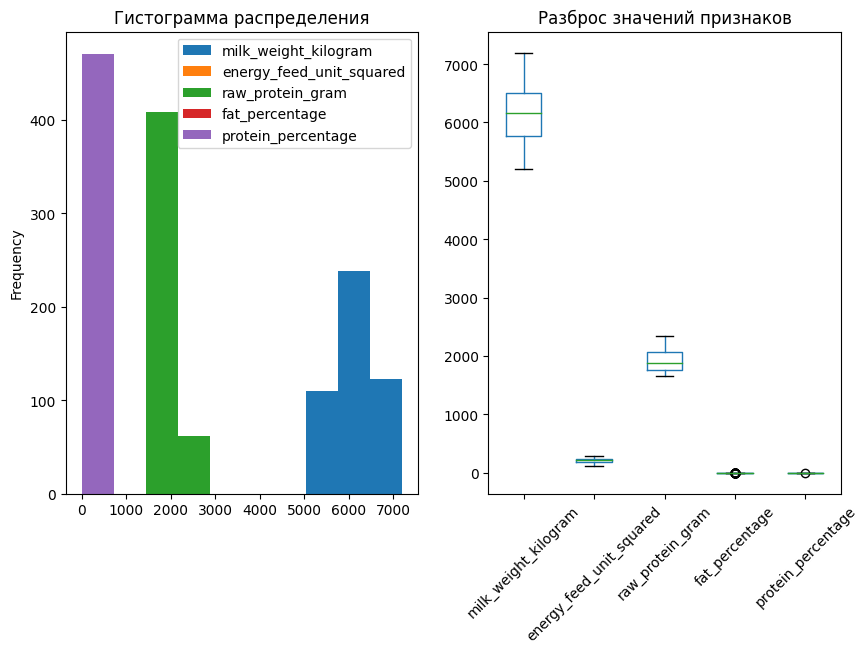

In [107]:
# Отберем список количественных признаков
num_col_names = ['milk_weight_kilogram', 'energy_feed_unit_squared', 'raw_protein_gram', 'fat_percentage', 'protein_percentage']

# Построим графики для количественных признаков тренировочного датасета:
# гистограмму частотности распределения и ящик с усами
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

# Настройка гистограмм
ferma.X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')

ferma.X_train[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')

# Выводим на экран
plt.show()

#### Масштабирование количественных признаков

In [108]:
# Создаем переменную с экземпляром класса StandardScaler()
scaler_clf = StandardScaler()

# Обучаем и трансформируем количественные признаки из тренировочной выборки
ferma.X_train_scaled = scaler_clf.fit_transform(ferma.X_train[num_col_names])

# Выполняем преобразование количественных признаков в тестовой выборке
ferma.X_test_scaled = scaler_clf.transform(ferma.X_test[num_col_names])

#### Масштабирование и кодирование категориальных признаков

In [109]:
# Создаем переменную с экземпляром класса OneHotEncoder()
# включаем параметр для избегания дамми-ошибок
# отключаем sparse-отображение
encoder_clf = OneHotEncoder(drop='first', sparse=False)

# Обучаем и трансформируем категориальные признаки из тренировочной выборки
ferma.X_train_ohe = encoder_clf.fit_transform(ferma.X_train[cat_col_names])

# Выполняем преобразование категориальных признаков в тестовой выборке
ferma.X_test_ohe = encoder_clf.transform(ferma.X_test[cat_col_names])

# Получаем от кодировщика список новых столбцов и сохраняем в новой переменной
encoder_col_names = encoder_clf.get_feature_names()

# Создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов указываем из переменной encoder_col_names
ferma.X_train_ohe = pd.DataFrame(ferma.X_train_ohe, columns=encoder_col_names)
ferma.X_test_ohe = pd.DataFrame(ferma.X_test_ohe, columns=encoder_col_names)

ferma.X_train_scaled = pd.DataFrame(ferma.X_train_scaled, columns=num_col_names)
ferma.X_test_scaled = pd.DataFrame(ferma.X_test_scaled, columns=num_col_names)

# Объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
ferma.X_train = pd.concat([ferma.X_train_ohe, ferma.X_train_scaled], axis=1).reset_index(drop=True)
ferma.X_test = pd.concat([ferma.X_test_ohe, ferma.X_test_scaled], axis=1).reset_index(drop=True)

# Вывод пяти первых строк из тренировочной выборки
print(ferma.X_train.head())

   x0_Рефлешн Соверин  x1_холмистое  x2_Соверин  x3_Буйный  x3_Геркулес  \
0                 0.0           0.0         0.0        1.0          0.0   
1                 0.0           0.0         0.0        1.0          0.0   
2                 0.0           1.0         0.0        1.0          0.0   
3                 0.0           0.0         0.0        0.0          1.0   
4                 1.0           1.0         0.0        1.0          0.0   

   x3_Соловчик  x4_менее_2_лет  x5_1  milk_weight_kilogram  \
0          0.0             0.0   1.0              0.001935   
1          0.0             0.0   0.0             -1.154086   
2          0.0             0.0   1.0              0.497997   
3          0.0             0.0   0.0             -0.666765   
4          0.0             0.0   1.0              0.915388   

   energy_feed_unit_squared  raw_protein_gram  fat_percentage  \
0                 -0.027210          0.248479        0.199205   
1                  0.053583         -1.392310 

#### Количественные признаки после масштабирования

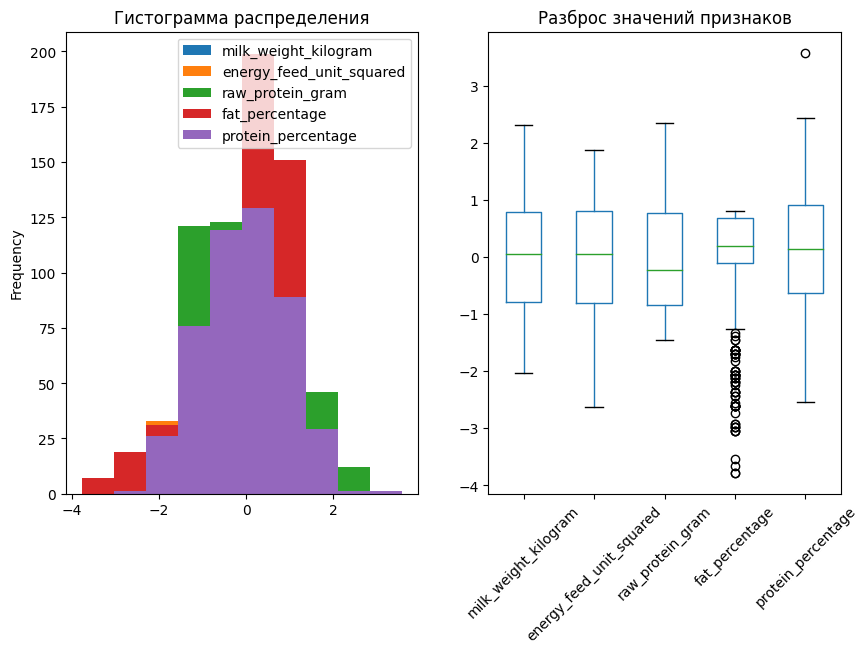

In [110]:
# Создание фигуры и осей
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Настройка гистограмм
ferma.X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')

ferma.X_train[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')

# Выводим на экран
plt.show()

#### Обучение и тестирование модели, оценка качества

In [111]:
# Инициализируем модель логистической регрессии
model_clf  = LogisticRegression()

# Обучаем модель на тренировочных данных
model_clf.fit(ferma.X_train, ferma.y_train)

# Получаем предсказания модели на тестовых данных 
# Сохраняем результат в переменную predictions
predictions = model_clf.predict(ferma.X_test)

# Выводим метрики для оценки модели
ferma.count_logistic_regression_metrics(ferma.y_test, predictions)

accuracy  recall  precision
0      0.68    0.76       0.73

In [112]:
ferma.show_info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          629 non-null    int64  
 1   milk_weight_kilogram        629 non-null    int64  
 2   energy_feed_unit            629 non-null    float64
 3   raw_protein_gram            629 non-null    int64  
 4   sugar_protein_relationship  629 non-null    float64
 5   breed                       629 non-null    object 
 6   type_of_pasture             629 non-null    object 
 7   breed_of_papa_bull          629 non-null    object 
 8   fat_percentage              629 non-null    float64
 9   protein_percentage          629 non-null    float64
 10  taste_of_milk               629 non-null    int64  
 11  age                         629 non-null    object 
 12  SPR_category                629 non-null    int64  
 13  energy_feed_unit_squared    629 non

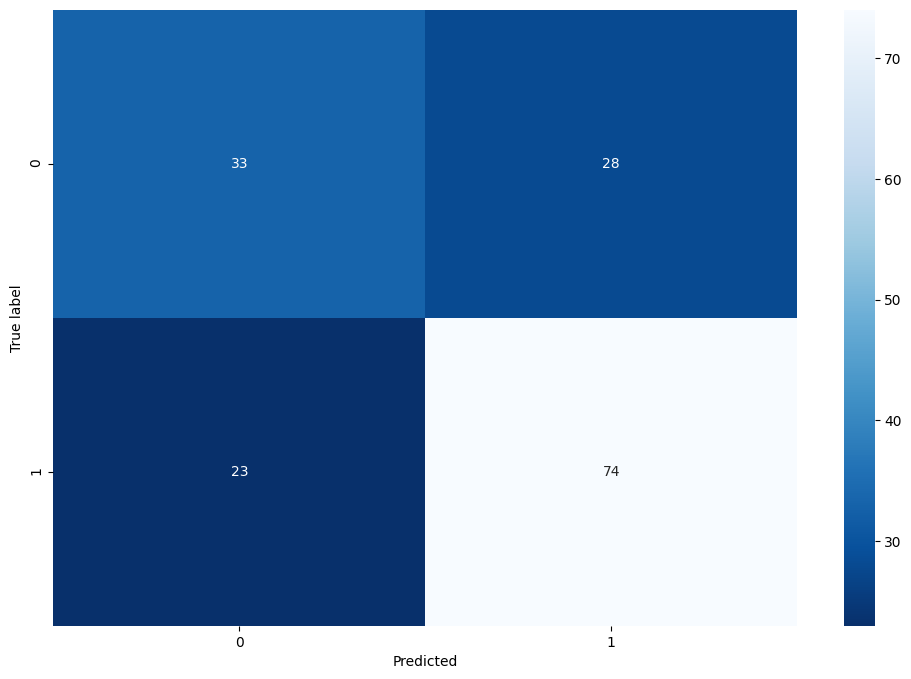

In [113]:
# Построим матрицу ошибок
# Создадим матрицу 2*2 с нулями и заполним её. Каждое предсказание сравниваем с целевым признаком в тестовой выборке и относим к одной из четырёх категорий
cm = confusion_matrix(ferma.y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.show()

#### Промежуточные выводы

При оценке модели классификации воспользуемся условием задачи - главное для заказчика это вкусное молоко. Значит, ему важно отобрать всё вкусное молоко. При покупке невкусного молока заказчик понесет убытки. Значит, ему нужно свести к минимуму ложно-положительные ошибки (ошибка первого рода). Воспользуемся метрикой Precision.

#### Результаты работы модели при разных порогах

In [114]:
y_proba = model_clf.predict_proba(ferma.X_test)[:,1]

data = pd.DataFrame(zip(ferma.y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

print(data.head())

     y_valid   y_proba
85         1  0.874241
56         1  0.870165
17         1  0.847088
77         1  0.836518
135        0  0.833288


In [115]:
# Выведем таблицу с метриками Precision, Recall при разных порогах
table = ferma.threshold_table(ferma.y_test, y_proba)
display(table)

Порог  Recall  Precision  Accuracy  Количество False Positive  \
0    0.00   1.000      0.614  0.613924                         61   
1    0.02   1.000      0.614  0.613924                         61   
2    0.04   1.000      0.614  0.613924                         61   
3    0.06   1.000      0.614  0.613924                         61   
4    0.08   1.000      0.614  0.613924                         61   
5    0.10   1.000      0.614  0.613924                         61   
6    0.12   1.000      0.614  0.613924                         61   
7    0.14   1.000      0.614  0.613924                         61   
8    0.16   1.000      0.614  0.613924                         61   
9    0.18   1.000      0.614  0.613924                         61   
10   0.20   1.000      0.614  0.613924                         61   
11   0.22   1.000      0.622  0.626582                         59   
12   0.24   0.990      0.623  0.626582                         58   
13   0.26   0.990      0.623  0.626582                         58   
14   0.28   0.990      0.636  0.645570                         55   
15   0.30   0.969      0.631  0.632911                         55   
16   0.32   0.938      0.632  0.626582                         53   
17   0.34   0.897      0.635  0.620253                         50   
18   0.36   0.887      0.632  0.613924                         50   
19   0.38   0.866      0.641  0.620253                         47   
20   0.40   0.866      0.661  0.645570                         43   
21   0.42   0.856      0.664  0.645570                         42   
22   0.44   0.835      0.664  0.639241                         41   
23   0.46   0.825      0.690  0.664557                         36   
24   0.48   0.804      0.703  0.670886                         33   
25   0.50   0.763      0.725  0.677215                         28   
26   0.52   0.742      0.735  0.677215                         26   
27   0.54   0.722      0.753  0.683544                         23   
28   0.56   0.670      0.765  0.670886                         20   
29   0.58   0.629      0.792  0.670886                         16   
30   0.60   0.588      0.814  0.664557                         13   
31   0.62   0.515      0.820  0.632911                         11   
32   0.64   0.454      0.800  0.594937                         11   
33   0.66   0.402      0.812  0.575949                          9   
34   0.68   0.330      0.821  0.544304                          7   
35   0.70   0.309      0.833  0.537975                          6   
36   0.72   0.278      0.844  0.525316                          5   
37   0.74   0.227      0.815  0.493671                          5   
38   0.76   0.186      0.783  0.468354                          5   
39   0.78   0.155      0.833  0.462025                          3   
40   0.80   0.103      0.909  0.443038                          1   
41   0.82   0.072      0.875  0.424051                          1   
42   0.84   0.031      1.000  0.405063                          0   
43   0.86   0.021      1.000  0.398734                          0   
44   0.88   0.000      0.000  0.386076                          0   
45   0.90   0.000      0.000  0.386076                          0   
46   0.92   0.000      0.000  0.386076                          0   
47   0.94   0.000      0.000  0.386076                          0   
48   0.96   0.000      0.000  0.386076                          0   
49   0.98   0.000      0.000  0.386076                          0   

    Количество False Negative  Число предсказанных объектов  \
0                           0                           158   
1                           0                           158   
2                           0                           158   
3                           0                           158   
4                           0                           158   
5                           0                           158   
6                           0              

In [116]:
# Посмотрим на случайное решение задачи

# Создаем пустой список
y_random = []

# Генерируем случайные решения
for i in range(len(ferma.y_test)):
    x = random.randint(0,1)
    y_random.append(x)

# Посчитаем количество вкусного молока, полученного случайным образом
sum(y_random)

73

#### Промежуточные выводы

* Наша модель при пороге классификации 0.5 показывает количество предсказанных объектов класса 1 - 102 при реальном количестве в 97. Количество ложноположительных предсказаний 28.
* Для целей снижения ошибок первого рода до 0 можем определить новый порог классификации в 0.84, в этом случае количество предсказанных объектов класса 1 будет 3.

### Прогноз вкуса молока коров

In [117]:
# Посмотрим на датасет
cow_combined_data.print_head()

breed type_of_pasture breed_of_papa_bull papa_bull_name  \
0   Вис Бик Айдиал       холмистое             Айдиал       Геркулес   
1   Вис Бик Айдиал       равнинное            Соверин         Буйный   
2  Рефлешн Соверин       равнинное            Соверин          Барин   
3  Рефлешн Соверин       холмистое             Айдиал         Буйный   
4  Рефлешн Соверин       равнинное             Айдиал         Буйный   

   fat_percentage  protein_percentage          age  energy_feed_unit  \
0            3.58               3.076  более_2_лет         15.271073   
1            3.54               3.081  менее_2_лет         15.271073   
2            3.59               3.074  более_2_лет         15.271073   
3            3.40               3.061  более_2_лет         15.271073   
4            3.64               3.074  более_2_лет         15.271073   

   raw_protein_gram  sugar_protein_relationship  SPR_category  \
0       2019.532273                    0.958772             1   
1       2019.532273                    0.958772             1   
2       2019.532273                    0.958772             1   
3       2019.532273                    0.958772             1   
4       2019.532273                    0.958772             1   

   energy_feed_unit_squared  milk_weight_kilogram  
0                233.205675           6548.894758  
1                233.205675           6296.356138  
2                233.205675           6288.075446  
3                233.205675           6593.392859  
4                233.205675           6542.740613

#### Анализ категориальных признаков

In [118]:
# Присвоим датасету имя X_predict
cow_combined_data.X_predict = cow_combined_data.data

# Отберем список категориальных признаков
cat_col_names = ['breed', 'type_of_pasture', 'breed_of_papa_bull', 'papa_bull_name', 'age', 'SPR_category']

# Выведем на экран количество уникальных значений в категорильаных признаках тренировочной выборки
print(cow_combined_data.X_predict[cat_col_names].nunique())

breed                 2
type_of_pasture       2
breed_of_papa_bull    2
papa_bull_name        4
age                   2
SPR_category          1
dtype: int64


In [119]:
cow_combined_data.show_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   breed                       20 non-null     object 
 1   type_of_pasture             20 non-null     object 
 2   breed_of_papa_bull          20 non-null     object 
 3   papa_bull_name              20 non-null     object 
 4   fat_percentage              20 non-null     float64
 5   protein_percentage          20 non-null     float64
 6   age                         20 non-null     object 
 7   energy_feed_unit            20 non-null     float64
 8   raw_protein_gram            20 non-null     float64
 9   sugar_protein_relationship  20 non-null     float64
 10  SPR_category                20 non-null     int64  
 11  energy_feed_unit_squared    20 non-null     float64
 12  milk_weight_kilogram        20 non-null     float64
dtypes: float64(7), int64(1), object(5)
me

#### Анализ количественных признаков

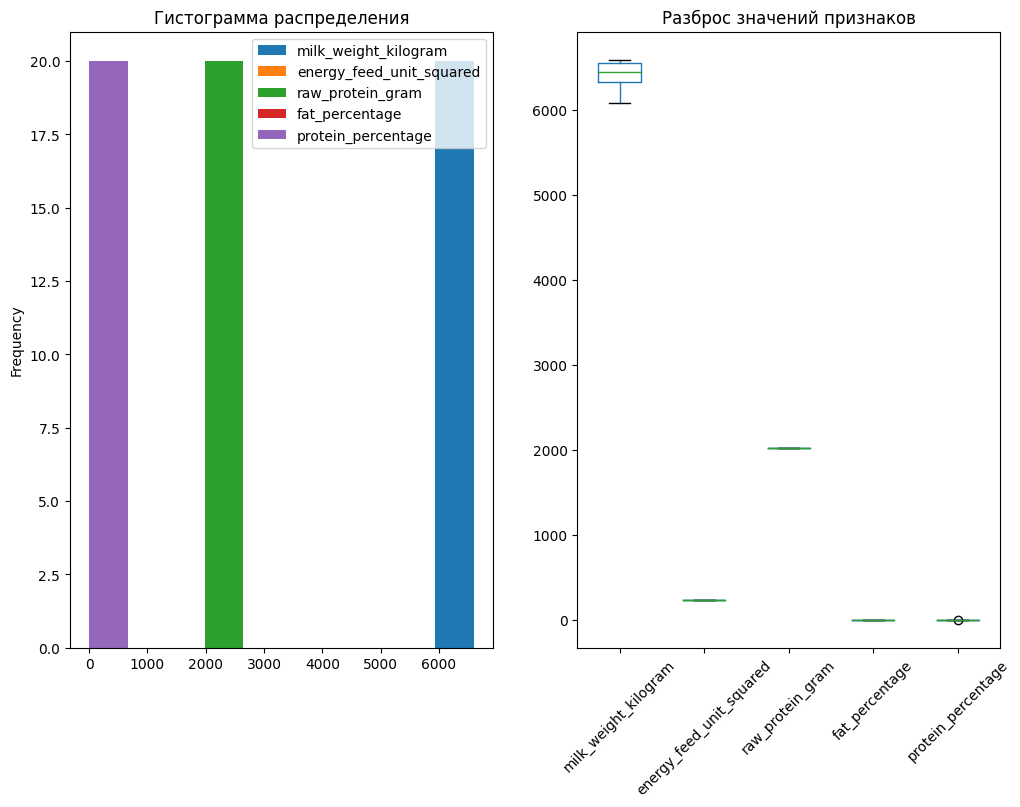

In [120]:
# Отберем список количественных признаков
num_col_names = ['milk_weight_kilogram', 'energy_feed_unit_squared', 'raw_protein_gram', 'fat_percentage', 'protein_percentage']

# Построим графики для количественных признаков тренировочного датасета:
# гистограмму частотности распределения и ящик с усами
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

# Настройка гистограмм
cow_combined_data.X_predict[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')

cow_combined_data.X_predict[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')

# Выводим на экран
plt.show()

#### Масштабирование количественных признаков

In [121]:
# Трансформируем количественные признаки из тестовой выборки
cow_combined_data.X_predict_scaled = scaler_clf.transform(cow_combined_data.X_predict[num_col_names])

#### Масштабирование и кодирование категориальных признаков

In [122]:
# Выполняем преобразование категориальных признаков в тестовой выборке
cow_combined_data.X_predict_ohe = encoder_clf.transform(cow_combined_data.X_predict[cat_col_names])

# Получаем от кодировщика список новых столбцов и сохраняем в новой переменной
encoder_col_names = encoder_clf.get_feature_names()

# Создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов указываем из переменной encoder_col_names
cow_combined_data.X_predict_ohe = pd.DataFrame(cow_combined_data.X_predict_ohe, columns=encoder_col_names)

cow_combined_data.X_predict_scaled = pd.DataFrame(cow_combined_data.X_predict_scaled, columns=num_col_names)

# Объединяем все преобразованные данные в тренировочный и тестовый датафреймы
# сбрасываем индексы в датафрейме с числовыми индексами, чтобы избежать ошибок
cow_combined_data.X_predict = pd.concat([cow_combined_data.X_predict_ohe, cow_combined_data.X_predict_scaled], axis=1).reset_index(drop=True)

# Вывод пяти первых строк из тренировочной выборки
print(cow_combined_data.X_predict.head())

   x0_Рефлешн Соверин  x1_холмистое  x2_Соверин  x3_Буйный  x3_Геркулес  \
0                 0.0           1.0         0.0        0.0          1.0   
1                 0.0           0.0         1.0        1.0          0.0   
2                 1.0           0.0         1.0        0.0          0.0   
3                 1.0           1.0         0.0        1.0          0.0   
4                 1.0           0.0         0.0        1.0          0.0   

   x3_Соловчик  x4_менее_2_лет  x5_1  milk_weight_kilogram  \
0          0.0             0.0   1.0              0.897675   
1          0.0             1.0   1.0              0.345804   
2          0.0             0.0   1.0              0.327708   
3          0.0             0.0   1.0              0.994917   
4          0.0             0.0   1.0              0.884227   

   energy_feed_unit_squared  raw_protein_gram  fat_percentage  \
0                  0.525538          0.539677       -0.168258   
1                  0.525538          0.539677 

#### Количественные признаки после масштабирования

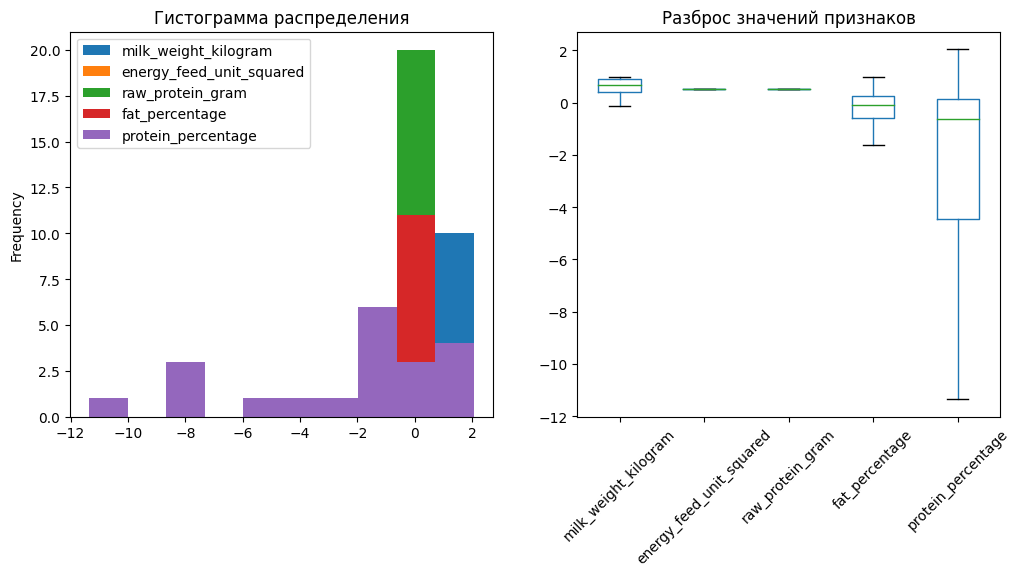

In [123]:
# Создание фигуры и осей
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Настройка гистограмм
cow_combined_data.X_predict[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')

cow_combined_data.X_predict[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')

# Выводим на экран
plt.show()

#### Тестирование модели

In [124]:
# Получаем предсказания модели на тестовых данных 
# Сохраняем результат в переменную predictions
predictions_milk = model_clf.predict(cow_combined_data.X_predict)

# Проверяем размерность
print(len(predictions_milk), len(cow_combined_data.data))

20 20


In [125]:
# 1. Получаем вероятности принадлежности к классу 1
proba = model_clf.predict_proba(cow_combined_data.X_predict)[:, 1]

# 2. Применяем новый порог для снижения ошибки первого рода до 0
threshold = 0.84
predictions_milk = (proba >= threshold).astype(int)

In [126]:
# Присваиваем новому столбцу прогнозные значения
cow_combined_data.data['taste_of_milk'] = predictions_milk

# Смотрим результат
display(cow_combined_data.data)

breed type_of_pasture breed_of_papa_bull papa_bull_name  \
0    Вис Бик Айдиал       холмистое             Айдиал       Геркулес   
1    Вис Бик Айдиал       равнинное            Соверин         Буйный   
2   Рефлешн Соверин       равнинное            Соверин          Барин   
3   Рефлешн Соверин       холмистое             Айдиал         Буйный   
4   Рефлешн Соверин       равнинное             Айдиал         Буйный   
5   Рефлешн Соверин       равнинное            Соверин       Геркулес   
6    Вис Бик Айдиал       холмистое             Айдиал       Геркулес   
7    Вис Бик Айдиал       равнинное            Соверин         Буйный   
8   Рефлешн Соверин       равнинное            Соверин          Барин   
9   Рефлешн Соверин       холмистое             Айдиал         Буйный   
10   Вис Бик Айдиал       холмистое            Соверин       Соловчик   
11  Рефлешн Соверин       равнинное            Соверин       Геркулес   
12   Вис Бик Айдиал       холмистое             Айдиал       Геркулес   
13   Вис Бик Айдиал       холмистое            Соверин          Барин   
14  Рефлешн Соверин       равнинное            Соверин          Барин   
15  Рефлешн Соверин       холмистое             Айдиал         Буйный   
16   Вис Бик Айдиал       холмистое            Соверин       Соловчик   
17  Рефлешн Соверин       равнинное            Соверин       Геркулес   
18   Вис Бик Айдиал       равнинное            Соверин         Буйный   
19  Рефлешн Соверин       равнинное             Айдиал         Буйный   

    fat_percentage  protein_percentage          age  energy_feed_unit  \
0             3.58               3.076  более_2_лет         15.271073   
1             3.54               3.081  менее_2_лет         15.271073   
2             3.59               3.074  более_2_лет         15.271073   
3             3.40               3.061  более_2_лет         15.271073   
4             3.64               3.074  более_2_лет         15.271073   
5             3.63               3.053  менее_2_лет         15.271073   
6             3.58               3.076  более_2_лет         15.271073   
7             3.57               3.079  более_2_лет         15.271073   
8             3.59               3.074  более_2_лет         15.271073   
9             3.40               3.079  менее_2_лет         15.271073   
10            3.73               3.055  более_2_лет         15.271073   
11            3.73               3.073  более_2_лет         15.271073   
12            3.68               3.046  более_2_лет         15.271073   
13            3.42               3.075  менее_2_лет         15.271073   
14            3.59               3.074  более_2_лет         15.271073   
15            3.40               3.065  более_2_лет         15.271073   
16            3.73               3.079  более_2_лет         15.271073   
17            3.77               3.053  менее_2_лет         15.271073   
18            3.34               3.069  более_2_лет         15.271073   
19            3.64               3.074  более_2_лет         15.271073   

    raw_protein_gram  sugar_protein_relationship  SPR_category  \
0        2019.532273                    0.958772             1   
1        2019.532273                    0.958772             1   
2        2019.532273                    0.958772             1   
3        2019.532273                    0.958772             1   
4        2019.532273                    0.958772             1   
5        2019.532273                    0.958772             1   
6        2019.532273                    0.958772             1   
7        2019.532273                    0.958772             1   
8        2019.532273                    0.958772             1   
9        2019.532273                    0.958772             1   
10       2019.532273                    0.958772             1   
11       2019.532273                    0.958772             1   
12       2019.532273                    0.958772             1   
13       2019.532273  

#### Промежуточные выводы

**Построение модели логистической регрессии**
* В рамках подготовки данных к обучению были:
    * проанализированы категориальные и количественные признаки (AS IS по результатам предобработки данных)
    * масштабированы количественные признаки, масштабированы и кодированы категориальные признаки
* Проведена оценка качестве модели по метрикам
    * Accuracy 0.68
    * Recall 0.76
    * Precision 0.73
* В соответствии с запросом заказчика на главный таргет - вкус молока, определена более важная метрика Precision (учитывает ошибки первого рода).
* Проанализированы пороги классификации с шагом 0.2, в результате выявлено, что наиболее оптимальными значениями метрик являются:
    * Порог классификации 0.84
    * Recall 0.03
    * Precision 1.0
    * Accuracy 0.40.

## Итоговые выводы

### Отбор коров

In [127]:
# Оставим в выборке только коров с удоем более 6000 кг и маркером "вкусное молоко"
cow_to_advice = cow_combined_data.data.query('milk_weight_kilogram > 6000 and taste_of_milk == 1')

# Смотрим на результат
len(cow_to_advice)

0

In [128]:
# Смотрим на перечень коров к покупке с минимальным риском
cow_to_advice.query('breed == "Вис Бик Айдиал"')

Empty DataFrame
Columns: [breed, type_of_pasture, breed_of_papa_bull, papa_bull_name, fat_percentage, protein_percentage, age, energy_feed_unit, raw_protein_gram, sugar_protein_relationship, SPR_category, energy_feed_unit_squared, milk_weight_kilogram, taste_of_milk]
Index: []

#### Промежуточные выводы

* Мы видим, что с выбранным порогом классификации, при котором сводится до 0 ошибка первого рода, ни одна корова не соответствует запросу заказчика по вкусу молока.
* Необходимо провести дополнительную коммуникацию с заказчиком на предмет возможного допуска какого-то процента ошибок первого рода, при которой покупка коров станет осуществима.

### Выводы

**Проанализированы датасеты на вход:**

**ferma_main**
* 634 строки
* отсутствуют пропущенные значения
* наименования столбцов необходимо перевести на английский и привести к типу snake_case
* необходимо скорректировать типы данных на следующие:
    * ЭКЕ (Энергетическая кормовая единица) -> float
    * СПО (Сахаро-протеиновое соотношение) -> float
    * Жирность,% -> float
    * Белок,% -> float

**ferma_dad**
* 629 строк
* отсутствуют пропущенные значения
* наименования столбцов необходимо перевести на английский и привести к типу snake_case

**cow_buy**
* 20 строк
* отсутствуют пропущенные значения
* наименования столбцов необходимо перевести на английский и привести к типу snake_case
* необходимо скорректировать типы данных на следующие:
    * Текущая_жирность,% -> float
    * Текущий_уровень_белок,% -> float

---
**Выполнена предобработка данных. Результаты:**
* Типы данных для столбцов `ЭКЕ (Энергетическая кормовая единица)`, `СПО (Сахаро-протеиновое соотношение)`, `Жирность,%`, `Белок,%`, `Текущая_жирность,%`, `Текущий_уровень_белок,%` изменены на float64
* Имена столбцов унифицированы: приведены к виду snake_case, переведены на английский язык
* Явные и неявные дубликаты обработаны

---
**Проведён исследовательские анализ данных. Результаты:**

В рамках статистического анализа данных:
* Выведена описательная статистика количественных признаков, которая показала **аномальное значение по удою по одной строке**. Данная аномалия была преобразована.

Построены гистограммы и диаграммы размаха для количественных признаков - характеристик **молока** (Удой, Содержание жиров, Содержание белков).
По результатам анализа графиков выявлены:
* **Неравномерное распределение выборки между коровами**:
    * **разных возрастов** - коров старше 2-х лет значительно больше, чем коров младше 2-х лет.
    * **разных пород** - коров Вис Дик Айдиал больше, чем коров Рифлешн Соверин.
* **Лидирующие показатели Удоя у коров старше 2-х лет (медианное значение выше примерно на 750 кг), породы Вис Дик Айдиал и породы папы быка Айдиал.**
* **Наличие выбросов в показателе - Жирность молока. Они характерны для коров старше 2-х лет.** Аномалии составили 14% от всего объема датасета.
* **Дискретный характер распределения показателей Жирность молока и Содержание белков в молоке**.
    * Пиковые значения жирности приходятся на диапазон 3.72-3.74%.
    * Пиковое значение по содержанию белка приходится на 3.076 ед.

Построены гистограммы и диаграммы размаха для количественных признаков - характеристик **корма** (ЭКЕ, Сырой протеин, Сахарно-протеиновое соотношение).
По результатам анализа графиков выявлены:
* **Медианные значения больше и диапазон принимаемых значений шире по всем характеристикам корма у коров старше 2-х лет.**
* Наоборот, **для коров разных пород практически идентичные значения по характеристикам корма.**
* То есть, похоже на то, что **разный состав корма зависит от возраста, а не от породы коровы или породы папы быка.**
* Пиковые значения ЭКЕ в районе 15-16 ед., сырого протеина - в районе 1800 грамм.
* **Дискретный характер распределения показателя Сахарно-протеиновое соотношение.**
    * Значения по СПО корма можно разделить на 3 категории: до 0.87, до 0.91, более 0.91.
* Значениям по СПО можно присвоить категории и использовать для улучшения обучающей способности моделей.

Построены столбчатые диаграммы для категориальных признаков, при анализе которых выявлено:
* **Соотношение вкусного молока и невкусного между разными породами коров примерно одинаково.**
* **Соотношение вкусного молока и невкусного между разными возрастами отличается:**
    * для коров младше 2-х лет держится паритет
    * для коров старше 2-х лет - вкусного молока больше примерно на 30%.

---
**Проведён корреляционный анализ признаков. Результаты:**
* Тип взаимосвязи целевого признака Удой, кг и всех количественных признаков определен на диаграммах рассеивания
* Линейная прямая связь определена между удоем и сырым протеином в корме
* Нелинейный характер связи определен между удоем и энергетической кормовой единицей в корме
* Показатель сахарно-протеинового соотношения предлагается закодировать в категориальный признак, т.к. на графике рассеивания отчетливо видны паттерны распределения точек
* Показатель содержания белка и жиров в молоке оставить без изменений - т.к. связь между этими показателемя отсутствует
* Проверка количественных признаков на мультиколлениарность не подтвердила её наличие (коэффициент инфляции дисперсии в пределах 4)

---
**Проведено обучение моделей линейной регресии в 3-х итерациях, выполнена оценка точности модели. Результаты:**

**Построена модель линейной регрессии (итерация №1 - AS IS)**
* В рамках подготовки данных к обучению были:
    * проанализированы категориальные и количественные признаки (AS IS по результатам предобработки данных)
    * масштабированы количественные признаки, масштабированы и кодированы категориальные признаки
* Проведена оценка качестве модели по Коэффициенту детерминации R2, который составил 0.82, что говорит о хорошей точности модели.
* Дополнительно проанализировав остатки, пришли к заключению, что:
    * Распределение остатков имеет несимметричный мультимодальный характер
    * Дисперсия неравномерная
    * Вывод: точность модели необходимо улучшить.


**Построена модель линейной регрессии (итерация №2 - с трансформацией 2-х количественных признаков)**
* В рамках подготовки данных к обучению были изменены 2 входных признака (характеристики корма):
        * ЭКЕ - значения возведены в квадраты
        * СПО - значения перекодированы в категориальный бинарный вид
* Далее пройдены этапы, аналогичные подготовке модели в первой итерации.
* Проведена оценка качества модели по Коэффициенту детерминации R2, который составил 0.84, что говорит о повышении точности модели.
* Дополнительно проанализировав остатки модели во второй итерации, пришли к заключению, что:
    * Распределение остатков имеет симметричный унимодальный характер с небольшим смещением влево (модель немного завышает прогнозные значения)
    * Дисперсия всё также неравномерная
    * Вывод: точность модели необходимо улучшить.


**Построена модель линейной регрессии (итерация №3 - с добавлением 1 входного признака) - лучшая**
* В рамках подготовки данных к обучению был добавлен 1 входной признак из датасета dad (характеристики коровы):
        * имя папы быка - категориальный признак
* Далее пройдены этапы, аналогичные подготовке моделям в первой и второй итерациях.
* Проведена оценка качества модели по Коэффициенту детерминации R2, который составил 0.86, что говорит о повышении точности модели.
* Дополнительно проанализировав остатки модели во второй итерации, пришли к заключению, что:
    * Распределение остатков имеет симметричный унимодальный характер с небольшим смещением влево (модель немного завышает прогнозные значения)
    * Дисперсия стала чуть более предсказуемой - облако точек заполнило значения ближе к оси X (что говорит о положительном влиянии на точность модели).


**Спрогнозирован удой молока с помощью модели линейной регрессии (итерация №3)**
* Для прогнозирования значений удоя в тестовой выборке выбрана модель №3 (с модернизацией входных признаков и добавлением новых признаков).
* Тестовая выборка составил 20 строк. Среднее значение удоя 6424 кг, медиана 6444 кг, минимум 6087 кг, максимум 6593 кг.
* За исключением максимума, все остальные статистики выше показателей модели, обученной на тренировочной выборке.
* Данные показатели ожидаемы с учетом анализа остатков модели, где распределение значений было смещено влево, то есть модель склонна делать позитивный прогноз значений по удою (завышать его).

**Повысить результаты модели линейной регресии не представляется возможнным** в связи с отсутствием новых входных признаков и ограниченным перечнем количественных признаков, влияющих на удой.

---
**Проведено обучение модели логистической регресии, выполнена оценка точности модели, спрогнозирован вкус молока для коров, доступных к продаже. Результаты:**
* В рамках подготовки данных к обучению были:
    * проанализированы категориальные и количественные признаки (AS IS по результатам предобработки данных)
    * масштабированы количественные признаки, масштабированы и кодированы категориальные признаки
* Проведена оценка качестве модели по метрикам Accuracy, Recall, Precision. Результаты:
    * Accuracy 0.68
    * Recall 0.76
    * Precision 0.73
* В соответствии с запросом заказчика на главный таргет - вкус молока, определена более важная метрика Precision (учитывает ошибки первого рода).
* Проанализированы пороги классификации с шагом 0.2, в результате выявлено, что наиболее оптимальными значениями метрик являются:
    * Порог классификации 0.84
    * Recall 0.03
    * Precision 1.0
    * Accuracy 0.40.

---
**Отбор коров к покупке с минимальным риском**
* В качестве параметром к отбору коров определены:
    * удой в размере 6000 кг в год
    * марке молока как вкусного
* Мы видим, что с выбранным порогом классификации, при котором сводится до 0 ошибка первого рода, ни одна корова не соответствует запросу заказчика по вкусу молока.
* Необходимо провести дополнительную коммуникацию с заказчиком на предмет возможного допуска какого-то процента ошибок первого рода, при которой покупка коров станет осуществима.